In [1]:
%load_ext autoreload
%autoreload 2


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [505]:
import sys
sys.path.insert(0, '..')

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['font.sans-serif'] = "Ubuntu"
plt.rcParams['font.weight'] = "light"

import covid19

In [506]:
import numpy as np
import pandas as pd
import xarray as xr

In [507]:
COPYRIGHT = "\xa9 2021 Alessandro Amici, dati github.com/italia/covid19-opendata-vaccini"

In [1061]:
!git -C ../../covid19-opendata-vaccini pull
yesterday_data = False

remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 34 (delta 22), reused 28 (delta 16), pack-reused 0
Unpacking objects: 100% (34/34), done.
From github.com:italia/covid19-opendata-vaccini
   e367325..57e8f72  master     -> origin/master
Updating e367325..57e8f72
Fast-forward
 dati/anagrafica-vaccini-summary-latest.csv        |    18 +-
 dati/anagrafica-vaccini-summary-latest.json       |   218 +-
 dati/last-update-dataset.json                     |     2 +-
 dati/punti-somministrazione-tipologia.csv         |    16 +-
 dati/punti-somministrazione-tipologia.json        |  3590 +-
 dati/somministrazioni-vaccini-latest.csv          |  3900 +-
 dati/somministrazioni-vaccini-latest.json         | 62080 ++++++++++---------
 dati/somministrazioni-vaccini-summary-latest.csv  |  3112 +-
 dati/somministrazioni-vaccini-summary-latest.json | 64162 ++++++++++----------
 dati/vaccini-summary-latest.csv 

In [1075]:
yesterday_data = True

In [1076]:
path = '../../covid19-opendata-vaccini/dati/somministrazioni-vaccini-latest.csv'

vaccines_italy = covid19.data.read_vaccini(path)
if yesterday_data:
    vaccines_italy = vaccines_italy.isel(time=slice(None, -1))
vaccines_italy

<xarray.Dataset>
Dimensions:        (age_class: 9, dose_type: 2, location: 22, provider: 3, time: 94)
Coordinates:
  * location       (location) object 'Abruzzo' 'Basilicata' ... 'Veneto'
  * time           (time) datetime64[ns] 2020-12-27 2020-12-28 ... 2021-03-30
  * provider       (provider) object 'AstraZeneca' 'Moderna' 'Pfizer/BioNTech'
  * age_class      (age_class) object '16-19' '20-29' '30-39' ... '80-89' '90+'
  * dose_type      (dose_type) <U7 'primer' 'booster'
    population     (location) int64 1322247 570365 1965128 ... 126883 4907529
    population_70  (location) int64 234575 95735 305986 ... 172921 22653 852983
    population_80  (location) int64 104003 43930 130778 ... 77917 9564 358540
Data variables:
    doses          (dose_type, time, location, provider, age_class) float64 0...

In [1077]:
doses = vaccines_italy.sel(dose_type="primer").doses

primers = doses.loc[{"provider": slice(None, None, -1)}]
primers0 = primers.sum("age_class")
primers70 = primers.sel(age_class=slice("70-79", None)).sum("age_class")
primers80 = primers.sel(age_class=slice("80-89", None)).sum("age_class")

In [1078]:
primers0_pm = primers0 / primers70.population
primers70_pm = primers70 / primers70.population_70
primers80_pm = primers80 / primers80.population_80

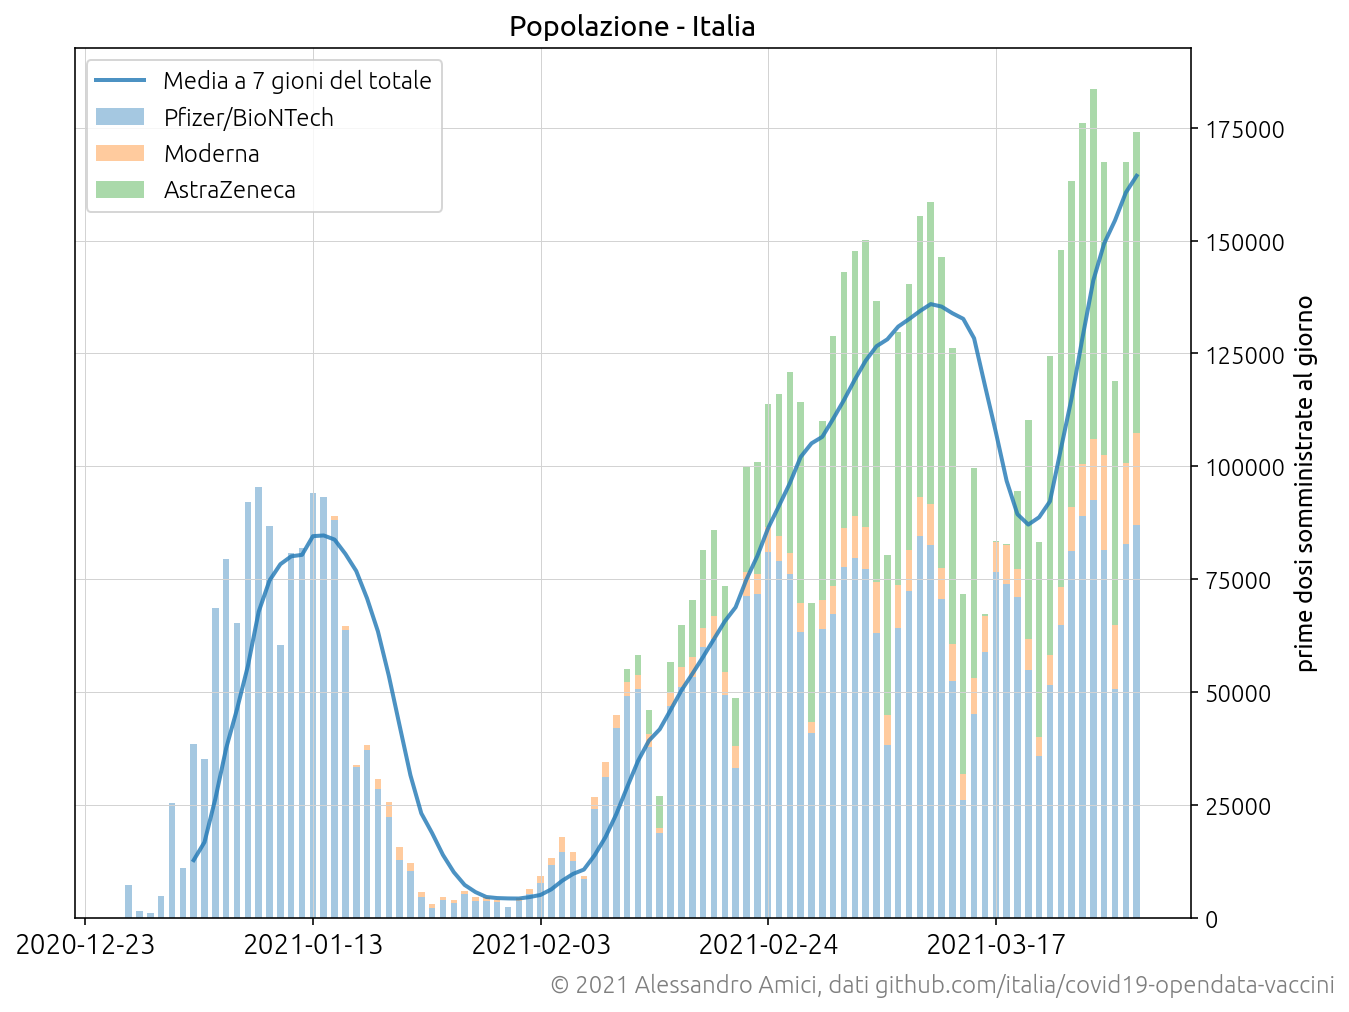

In [1079]:
location = "Italia"
fig, ax = covid19.plot.subplots(note=COPYRIGHT)
covid19.plot.stack_xarray(primers0.sel(location=location), hue="provider", window=7, title=f"Popolazione - {location}", label_total="Media a 7 gioni del totale", ax=ax)
ax.set(ylabel="prime dosi somministrate al giorno")
ax.legend()


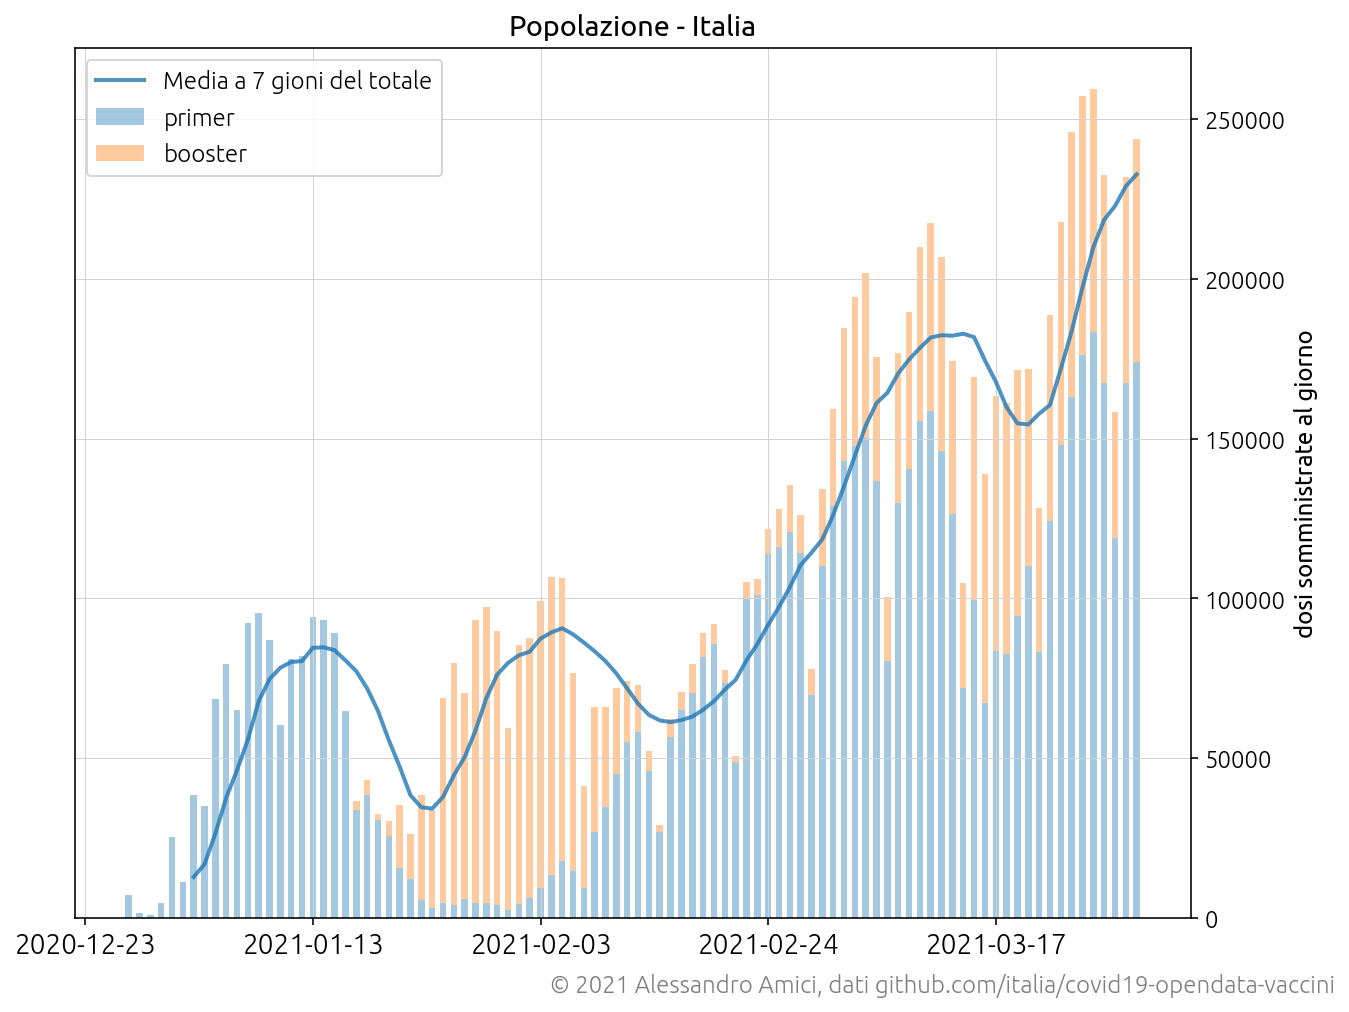

In [1080]:
location = "Italia"
fig, ax = covid19.plot.subplots(note=COPYRIGHT)
covid19.plot.stack_xarray(vaccines_italy.sel(location=location).sum(["provider", "age_class"]).doses, hue="dose_type", window=7, title=f"Popolazione - {location}", label_total="Media a 7 gioni del totale", ax=ax)
ax.set(ylabel="dosi somministrate al giorno")
ax.legend()


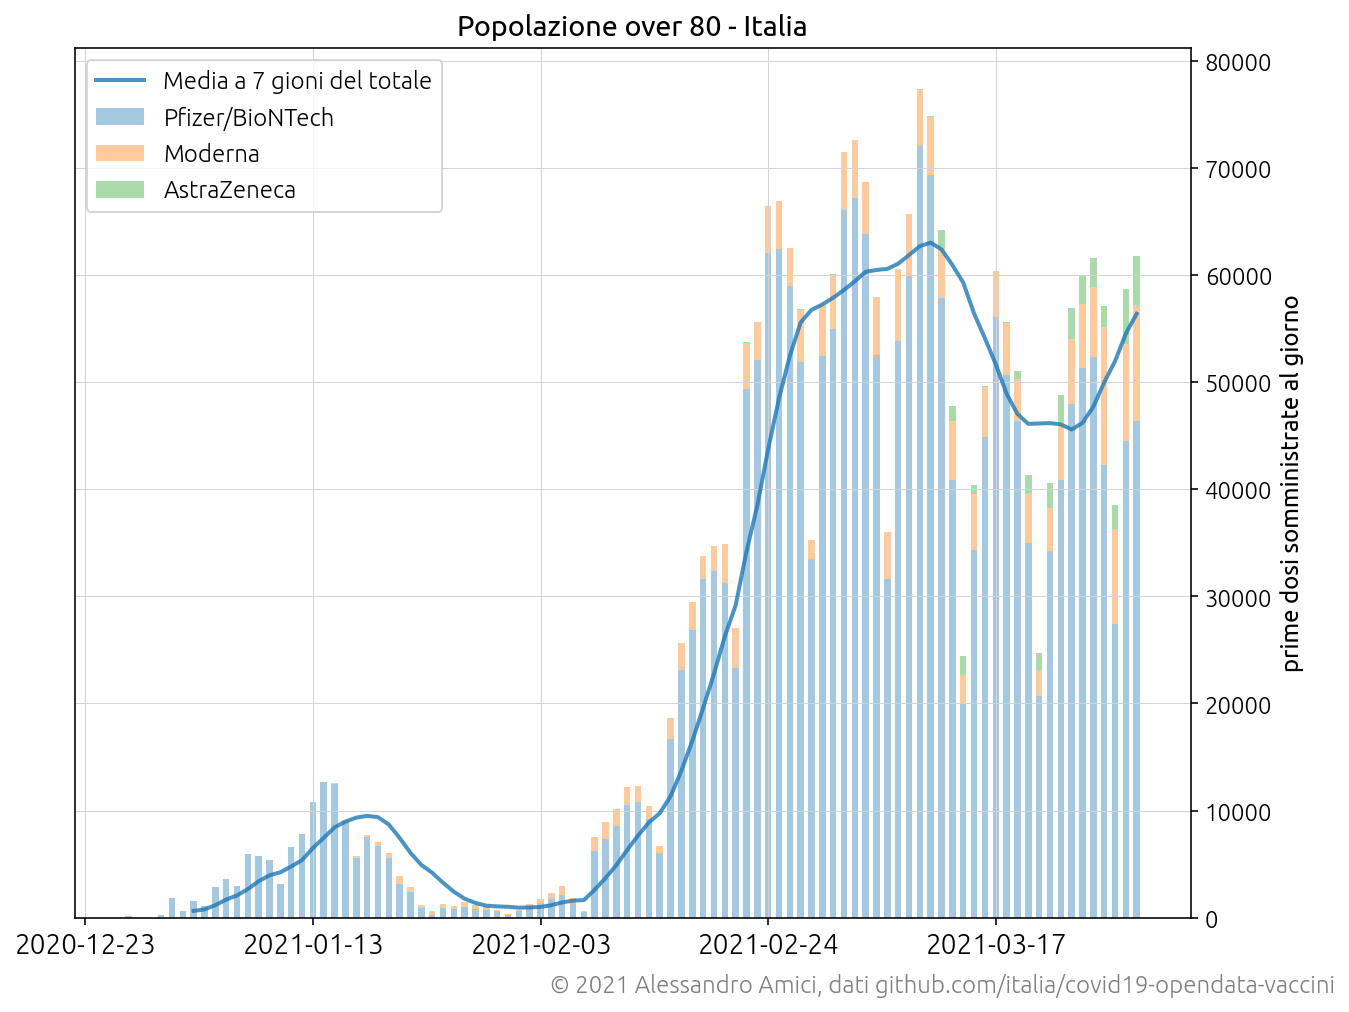

In [1081]:
location = "Italia"
fig, ax = covid19.plot.subplots(note=COPYRIGHT)
covid19.plot.stack_xarray(primers80.sel(location=location), hue="provider", window=7, title=f"Popolazione over 80 - {location}", label_total="Media a 7 gioni del totale", ax=ax)
ax.set(ylabel="prime dosi somministrate al giorno")
ax.legend()

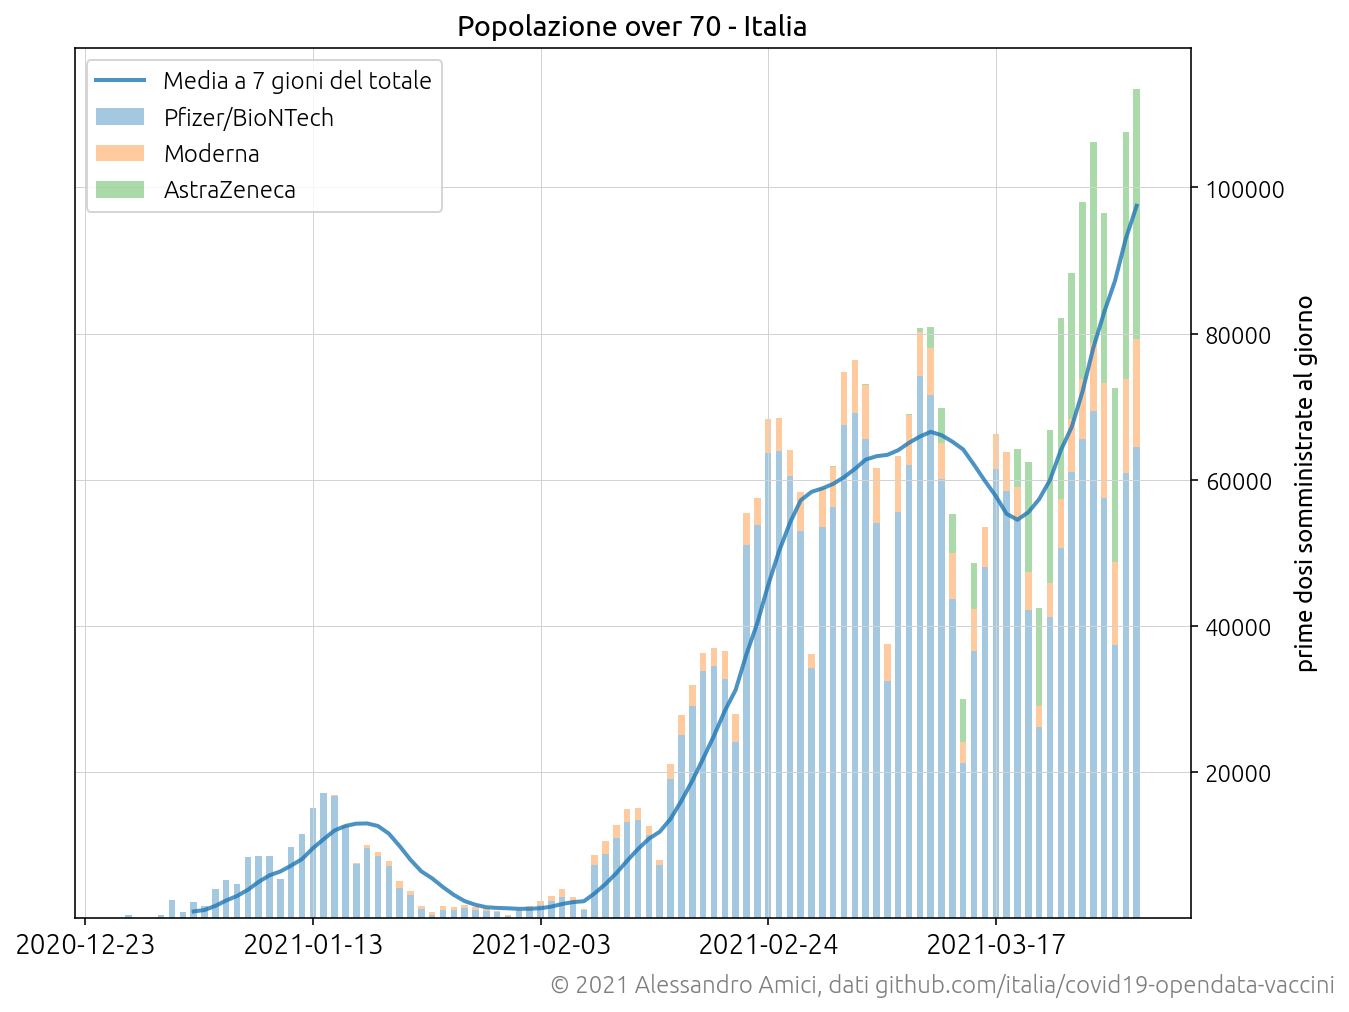

In [1082]:
location = "Italia"
fig, ax = covid19.plot.subplots(note=COPYRIGHT)
covid19.plot.stack_xarray(primers70.sel(location=location), hue="provider", window=7, title=f"Popolazione over 70 - {location}", label_total="Media a 7 gioni del totale", ax=ax)
ax.set(ylabel="prime dosi somministrate al giorno")
ax.legend()

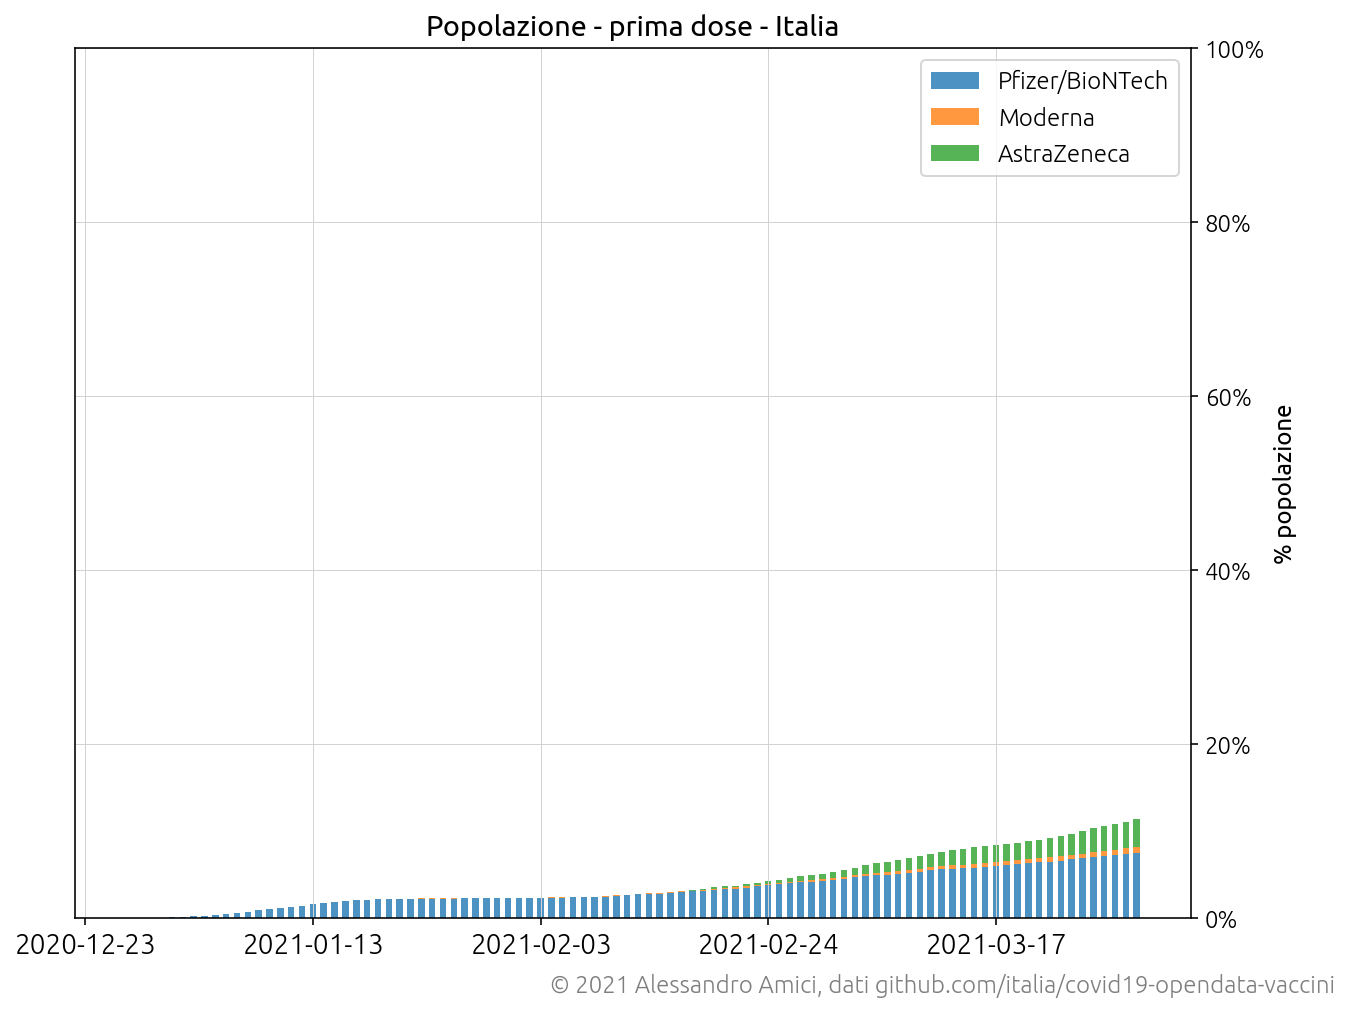

In [1083]:
location = "Italia"
fig, ax = covid19.plot.subplots(note=COPYRIGHT)
covid19.plot.stack_xarray(primers0_pm.cumsum("time").sel(location=location), hue="provider", window=7, title=f"Popolazione - prima dose - {location}", ylim=(0, 1), alpha=0.8, ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1, 0))
ax.set(ylabel="% popolazione")
ax.legend() 

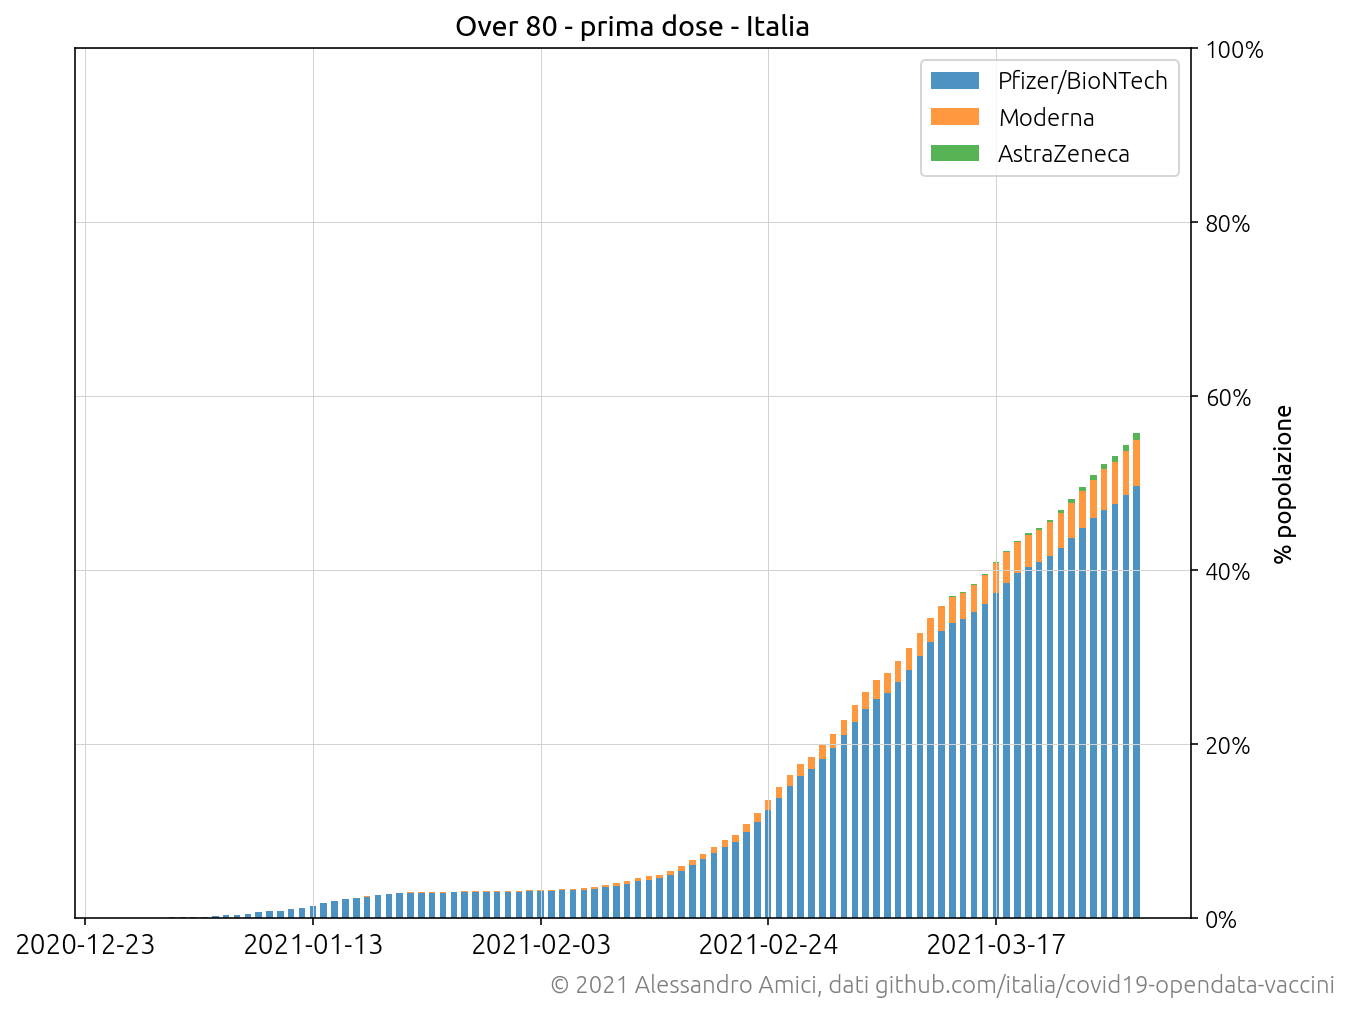

In [1084]:
location = "Italia"
fig, ax = covid19.plot.subplots(note=COPYRIGHT)
covid19.plot.stack_xarray(primers80_pm.cumsum("time").sel(location=location), hue="provider", window=7, alpha=0.8, title=f"Over 80 - prima dose - {location}", ylim=(0, 1), ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1, 0))
ax.set(ylabel="% popolazione")
ax.legend() 

In [1085]:
primers80_today = primers80.cumsum("time").sum("provider")
primers80_todo = primers80.population_80 - primers80_today
primers80_last_week =  primers80_today - primers80_today.shift({"time": 7})
primers80_weeks_todo = primers80_todo / primers80_last_week
primers80_today_perc = primers80_today / primers80_today.population_80
primers80_alldone =  primers80_weeks_todo * 7 * pd.Timedelta(1, "D") + primers80_today.time
primers80_alldone.sel(location="Italia")

<xarray.DataArray (time: 94)>
array([                          'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT', '2036-09-10T10:18:08.077136960',
       '2031-04-17T04:45:26.596132800', '2028-02-18T14:07:26.662171264',
       '2026-10-23T18:09:26.469861312', '2025-07-10T01:43:56.384035904',
       '2024-07-18T11:44:48.393903856', '2024-01-22T23:12:56.674489984',
       '2023-11-10T03:14:45.747018016', '2023-07-15T09:27:50.149654976',
       '2023-04-04T06:16:19.628252792', '2022-11-13T21:53:38.257261416',
       '2022-08-19T10:40:10.842889144', '2022-06-12T14:14:10.816008664',
       '2022-05-13T02:30:59.107558048', '2022-04-24T06:25:55.548759976',
       '2022-04-16T13:34:31.310699304', '2022-04-22T09:04:20.096453728',
       '2022-05-28T21:48:00.082735520', '2022-08-20T03:00:44.710211592',
       '2022-12-31T09:49:04.435797664', '2023-06-11T14:20:17.338931520',
       '2023-11-10T15:25:40.339904832', '2024-08-26T15:33:38.079490416',
       '2025-11-24T15:58:23.526093088', '2027-09-10T15:28:07.581593984',
       '2029-07-31T01:58:51.400165696', '2031-06-29T06:13:52.876712320',
       '2032-03-04T07:36:42.810810752', '2032-08-02T10:52:17.323055360',
       '2033-07-20T07:16:06.707168960', '2033-04-19T12:25:36.657240640',
       '2032-10-01T01:50:45.208984960', '2031-02-14T16:25:57.518659008',
...
       '2021-07-08T02:49:19.128786208', '2021-06-17T10:17:11.357533398',
       '2021-06-04T02:32:17.548279755', '2021-05-22T09:33:32.696007185',
       '2021-05-13T11:40:26.217738441', '2021-05-07T10:09:11.755172084',
       '2021-05-03T10:31:06.159390858', '2021-05-02T11:03:26.101128291',
       '2021-05-01T21:39:45.396928375', '2021-05-01T04:38:43.206634415',
       '2021-04-30T05:22:30.107491237', '2021-04-29T05:00:07.027936722',
       '2021-04-28T05:54:54.820430210', '2021-04-28T03:16:41.236472392',
       '2021-04-28T10:51:03.610850381', '2021-04-28T01:04:29.392912043',
       '2021-04-27T07:34:14.063515301', '2021-04-26T10:19:11.588536741',
       '2021-04-25T23:49:20.588964620', '2021-04-26T10:28:27.937191286',
       '2021-04-27T17:34:45.323705588', '2021-04-29T14:15:19.128263949',
       '2021-05-02T06:18:37.813049359', '2021-05-04T09:34:17.233852077',
       '2021-05-06T13:12:02.508225276', '2021-05-09T06:21:43.275327270',
       '2021-05-11T06:16:12.672742900', '2021-05-12T10:37:08.070001487',
       '2021-05-12T20:44:22.063115138', '2021-05-12T22:47:37.678908449',
       '2021-05-13T00:22:39.395585991', '2021-05-13T07:23:33.988302334',
       '2021-05-12T08:01:14.540799287', '2021-05-10T12:21:21.352095130',
       '2021-05-08T07:27:01.595288467', '2021-05-06T22:56:09.926300737',
       '2021-05-04T23:38:28.083073118', '2021-05-03T16:11:02.391025105'],
      dtype='datetime64[ns]')
Coordinates:
    location       <U6 'Italia'
    dose_type      <U7 'primer'
    population     int64 60360000
    population_70  int64 10388076
    population_80  int64 4419703
  * time           (time) datetime64[ns] 2020-12-27 2020-12-28 ... 2021-03-30

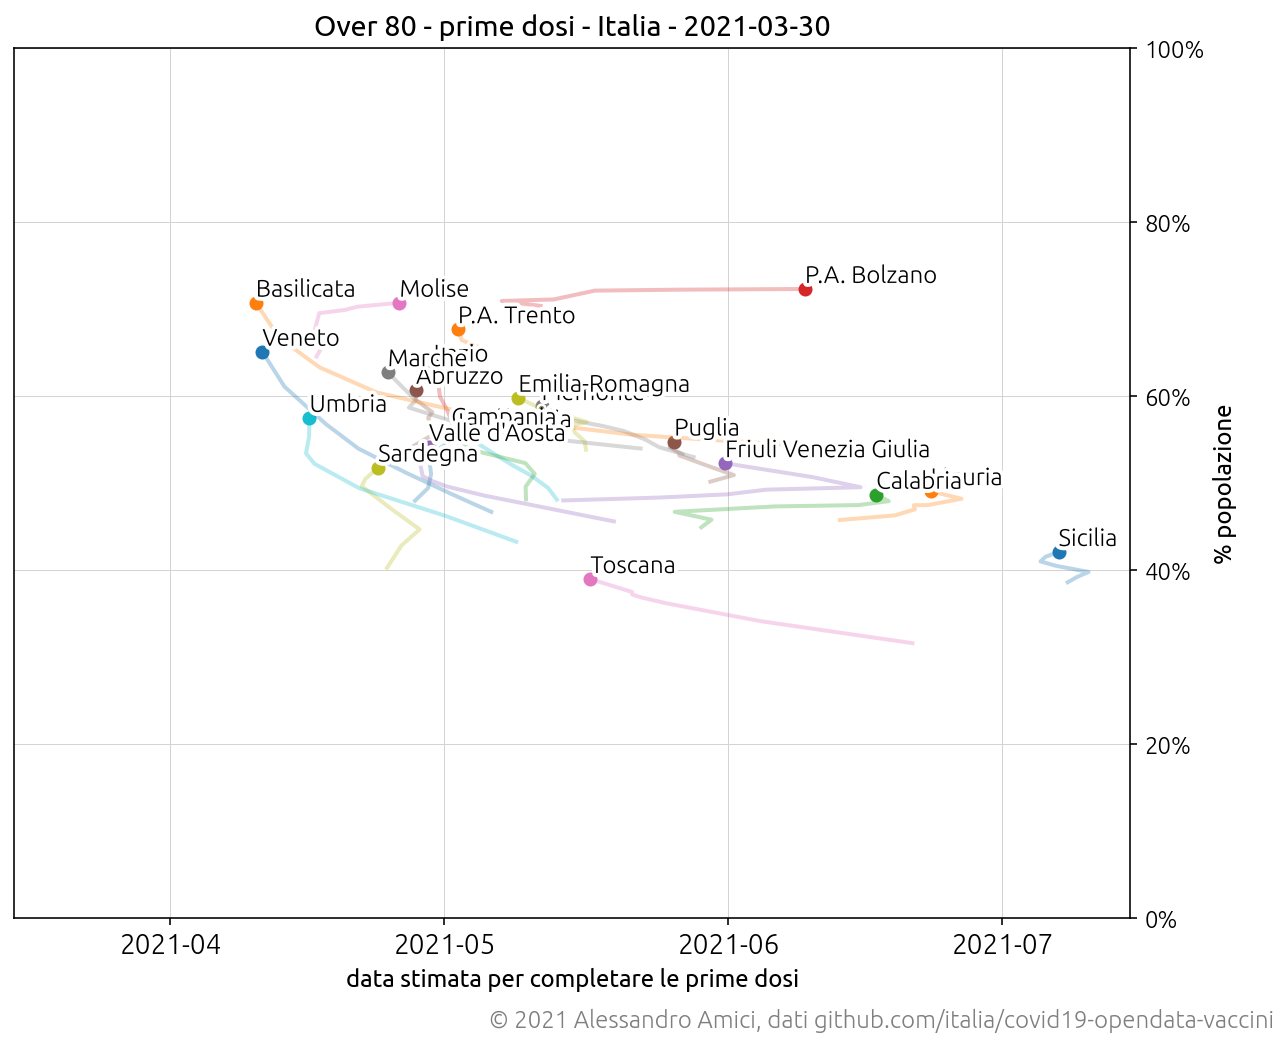

In [1086]:
fig, ax = covid19.plot.subplots(note=COPYRIGHT, note_pos=(1, 0.03))
covid19.plot.scatter_xarray(primers80_alldone.isel(time=slice(-7, None)), primers80_today_perc, xlim=(np.datetime64('2021-03-15'), np.datetime64('2021-07-15')), ylim=(0, 1.), ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1, 0))
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
_ = ax.set(title=f"Over 80 - prime dosi - Italia - {str(primers80_alldone.time.values[-1])[:10]}", ylabel="% popolazione", xlabel="data stimata per completare le prime dosi")


In [1087]:
primers70_today = primers70.cumsum("time").sum("provider")
primers70_todo = primers70.population_70 - primers70_today
primers70_last_week =  primers70_today - primers70_today.shift({"time": 7})
primers70_weeks_todo = primers70_todo / primers70_last_week
primers70_today_perc = primers70_today / primers70_today.population_70
primers70_alldone =  primers70_weeks_todo * 7 * pd.Timedelta(1, "D") + primers70_today.time
primers70_alldone.sel(location="Italia")

<xarray.DataArray (time: 94)>
array([                          'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT', '2047-12-16T05:06:27.212137472',
       '2038-07-21T10:55:28.158080448', '2033-01-11T12:32:05.049882048',
       '2030-07-19T04:55:06.922523392', '2028-06-09T18:24:29.717362016',
       '2026-10-14T19:33:37.858388544', '2025-11-24T04:31:21.802085376',
       '2025-06-29T20:53:22.706543072', '2024-12-25T09:24:27.695074448',
       '2024-07-18T05:22:10.518234144', '2023-12-31T11:50:41.555438768',
       '2023-08-27T08:11:17.714513248', '2023-05-23T22:56:21.021479024',
       '2023-04-11T22:14:39.558011048', '2023-03-23T10:11:43.734182128',
       '2023-03-21T12:28:42.074991704', '2023-04-13T03:47:41.084953944',
       '2023-06-25T09:41:37.454833840', '2023-11-27T23:46:21.084386464',
       '2024-07-31T00:45:32.986667152', '2025-06-17T20:58:38.647269136',
       '2026-04-01T18:02:38.566771776', '2027-09-21T01:12:58.626577312',
       '2030-01-02T09:27:15.047967072', '2033-05-05T20:46:59.277108416',
       '2036-11-12T11:05:48.312065856', '2040-06-22T08:33:03.053874432',
       '2041-11-05T21:29:09.707850752', '2042-09-13T18:43:23.848706048',
       '2044-01-27T10:28:58.398212352', '2043-10-08T02:07:30.365556480',
       '2042-07-28T23:56:59.505222656', '2039-06-13T11:02:53.877090816',
...
       '2022-01-03T20:12:27.251941964', '2021-11-21T05:01:52.925143148',
       '2021-10-23T04:43:43.397541460', '2021-09-24T23:50:48.538890264',
       '2021-09-05T00:58:18.825486154', '2021-08-22T02:07:33.258671150',
       '2021-08-12T09:55:12.826460824', '2021-08-09T11:12:04.868082604',
       '2021-08-08T03:38:01.913389156', '2021-08-06T10:49:00.189585768',
       '2021-08-03T19:10:57.561493074', '2021-07-31T17:52:58.482945870',
       '2021-07-28T12:38:49.570415240', '2021-07-27T11:38:17.140997126',
       '2021-07-27T11:08:53.500104796', '2021-07-26T01:43:48.289757018',
       '2021-07-23T19:33:04.410609640', '2021-07-21T19:41:48.589974568',
       '2021-07-20T07:24:14.164689616', '2021-07-21T04:04:37.584059776',
       '2021-07-23T02:27:50.442159056', '2021-07-25T20:15:30.234879442',
       '2021-07-30T14:14:30.047543582', '2021-08-04T18:23:33.030114136',
       '2021-08-09T16:58:20.808756038', '2021-08-15T23:24:20.861344374',
       '2021-08-18T00:27:25.681934342', '2021-08-15T02:47:05.127435820',
       '2021-08-10T17:55:20.551797028', '2021-08-04T09:35:11.926308060',
       '2021-07-26T11:29:50.278087756', '2021-07-20T06:27:02.289104092',
       '2021-07-11T21:38:04.967102524', '2021-07-03T04:08:24.487141937',
       '2021-06-27T04:22:53.322558468', '2021-06-22T19:37:21.160453617',
       '2021-06-17T05:32:05.671659671', '2021-06-13T09:11:45.607321888'],
      dtype='datetime64[ns]')
Coordinates:
    location       <U6 'Italia'
    dose_type      <U7 'primer'
    population     int64 60360000
    population_70  int64 10388076
    population_80  int64 4419703
  * time           (time) datetime64[ns] 2020-12-27 2020-12-28 ... 2021-03-30

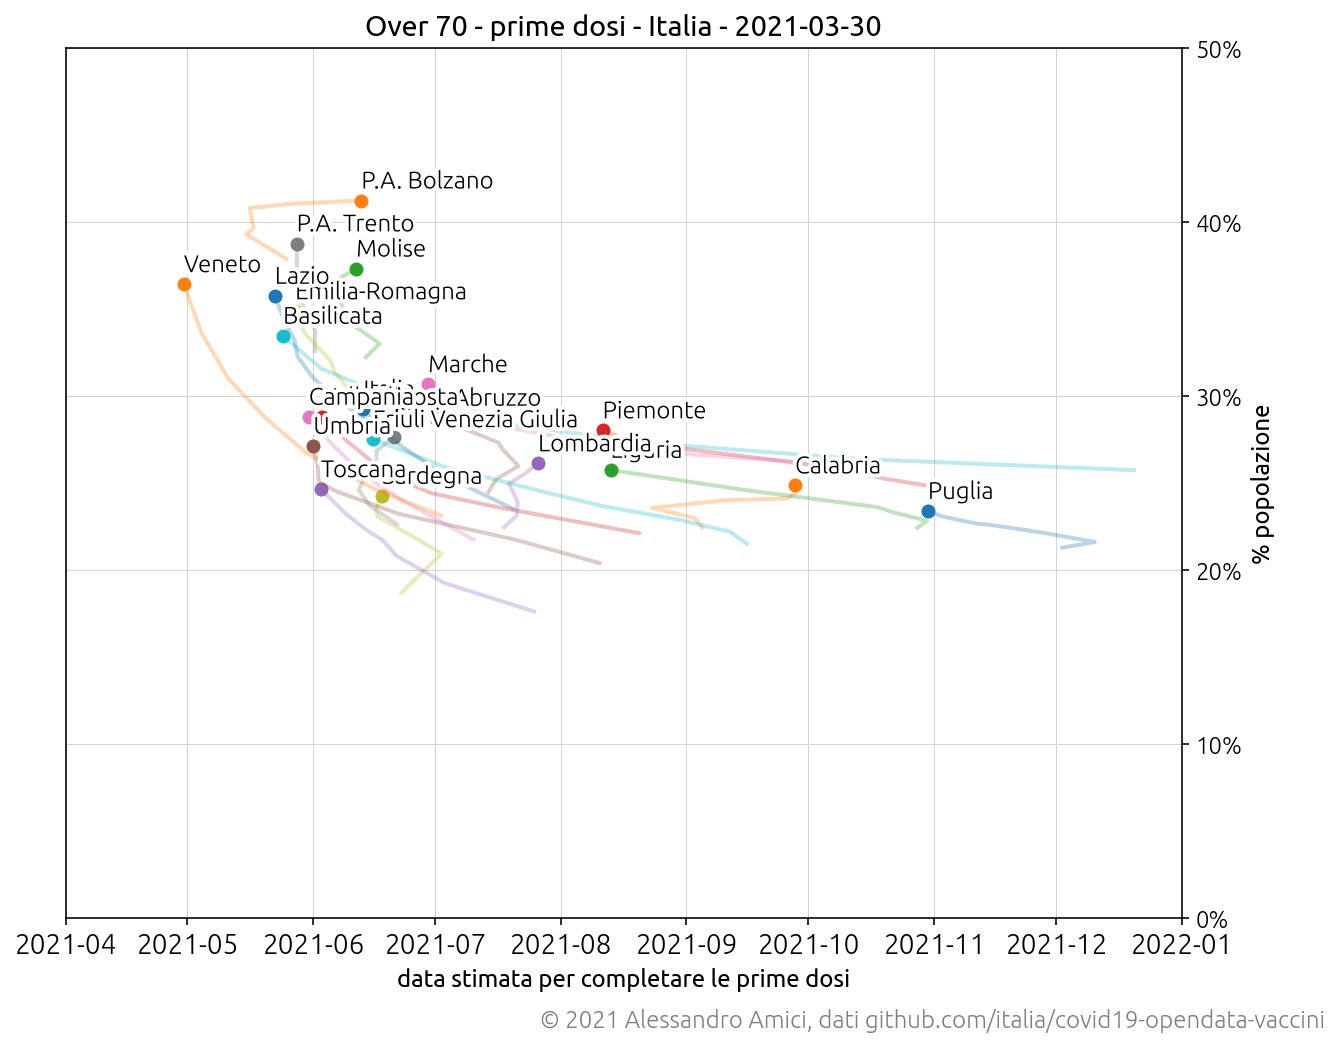

In [1088]:
fig, ax = covid19.plot.subplots(note=COPYRIGHT, note_pos=(1, 0.03))
covid19.plot.scatter_xarray(primers70_alldone.isel(time=slice(-7, None)), primers70_today_perc, xlim=(np.datetime64('2021-04-01'), np.datetime64('2022-01-01')), ylim=(0, 0.5), ax=ax)
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1, 0))
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
_ = ax.set(title=f"Over 70 - prime dosi - Italia - {str(primers80_alldone.time.values[-1])[:10]}", ylabel="% popolazione", xlabel="data stimata per completare le prime dosi")


../covid19/plot.py:196: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(*args, **kwargs)


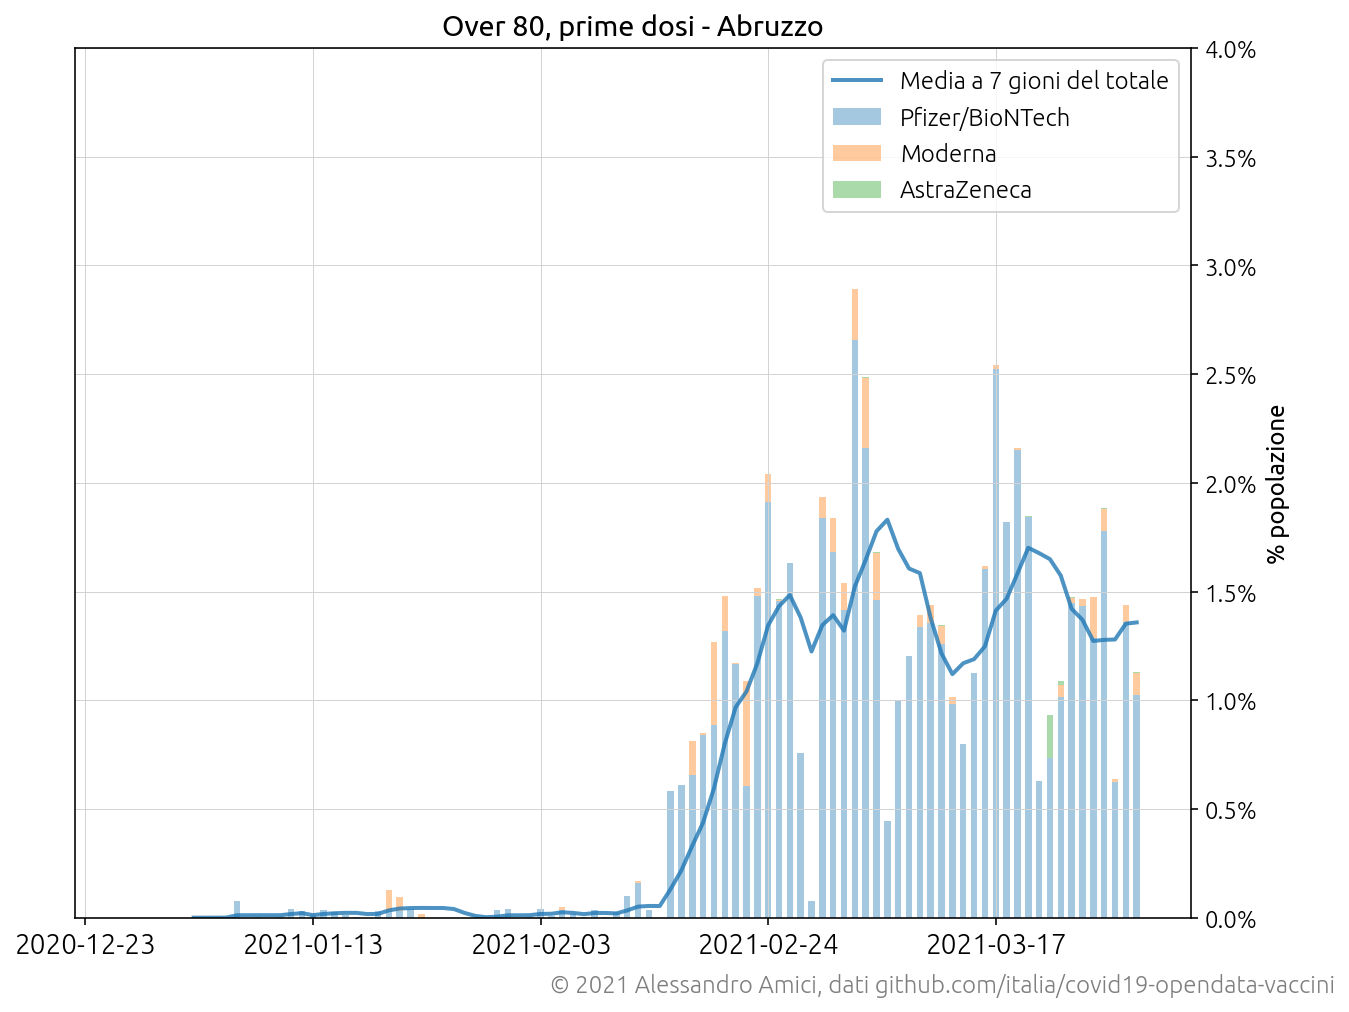

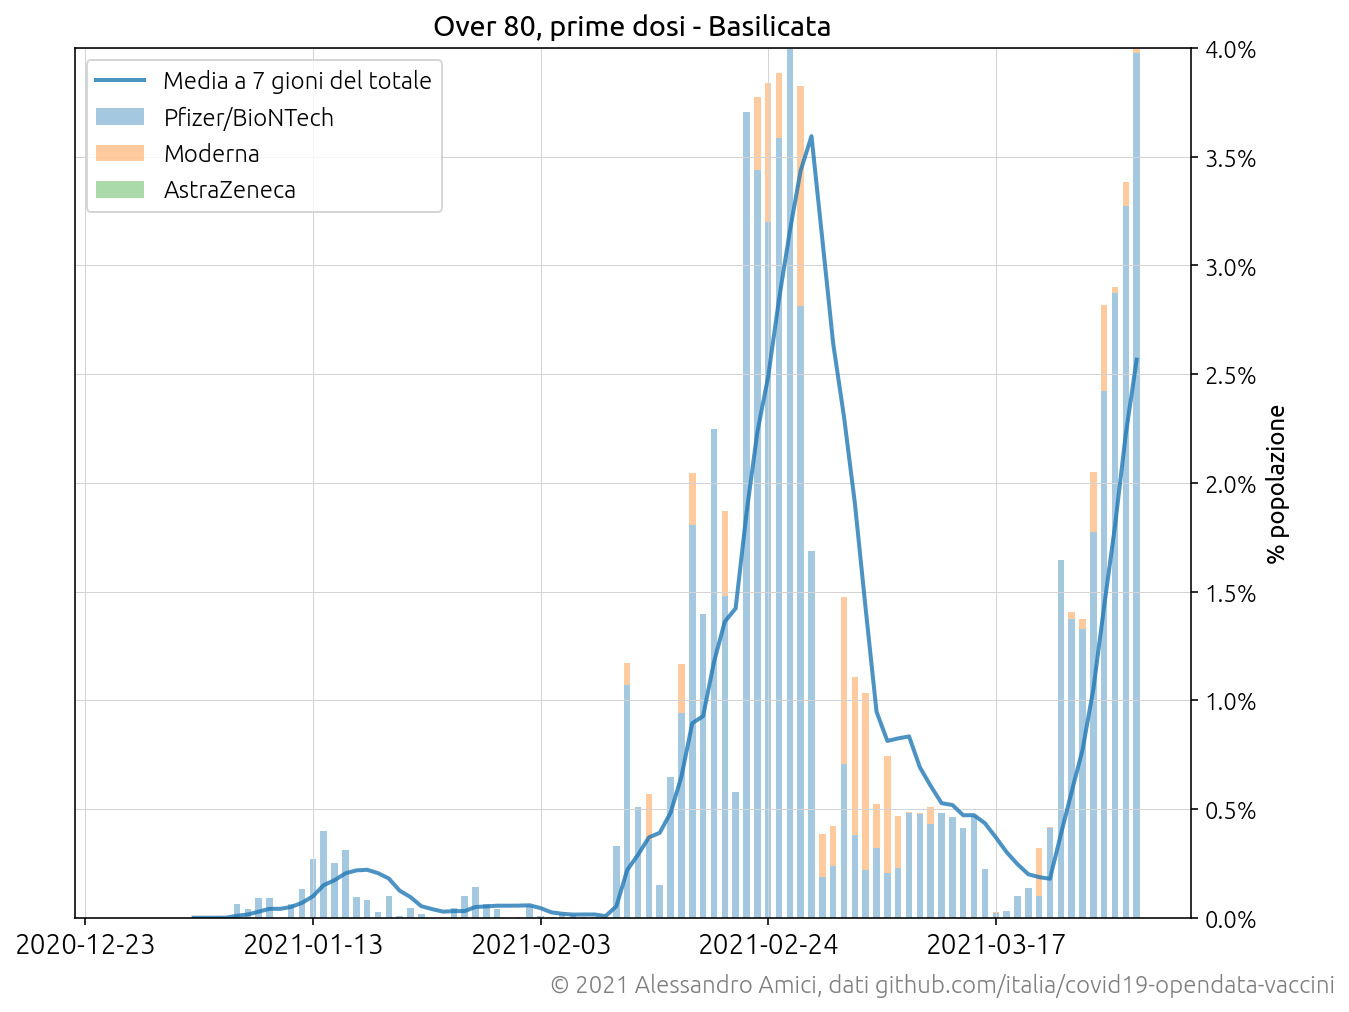

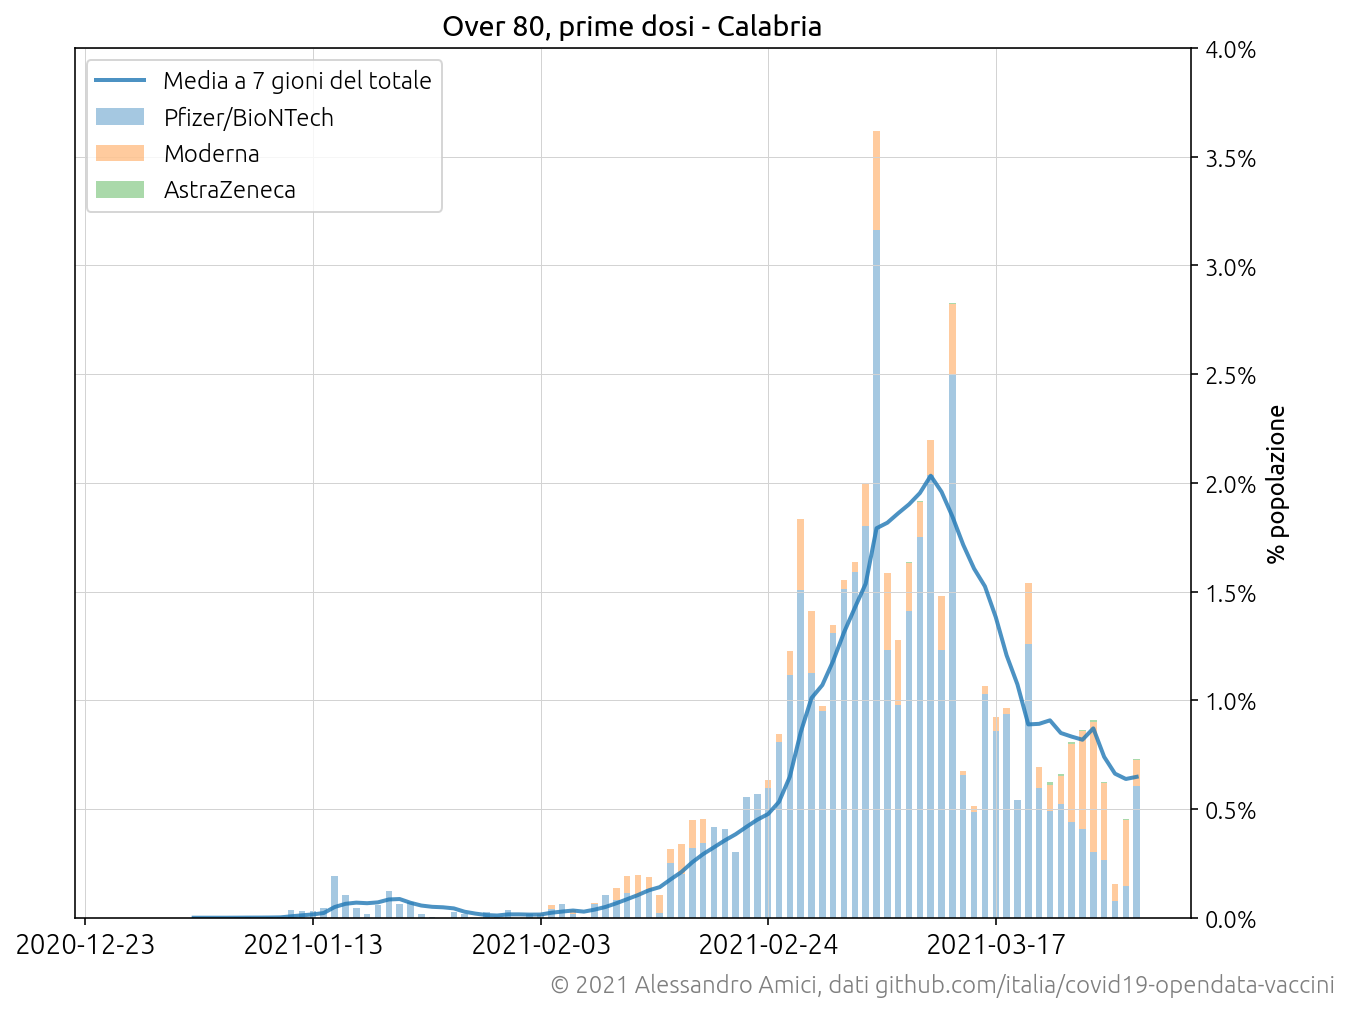

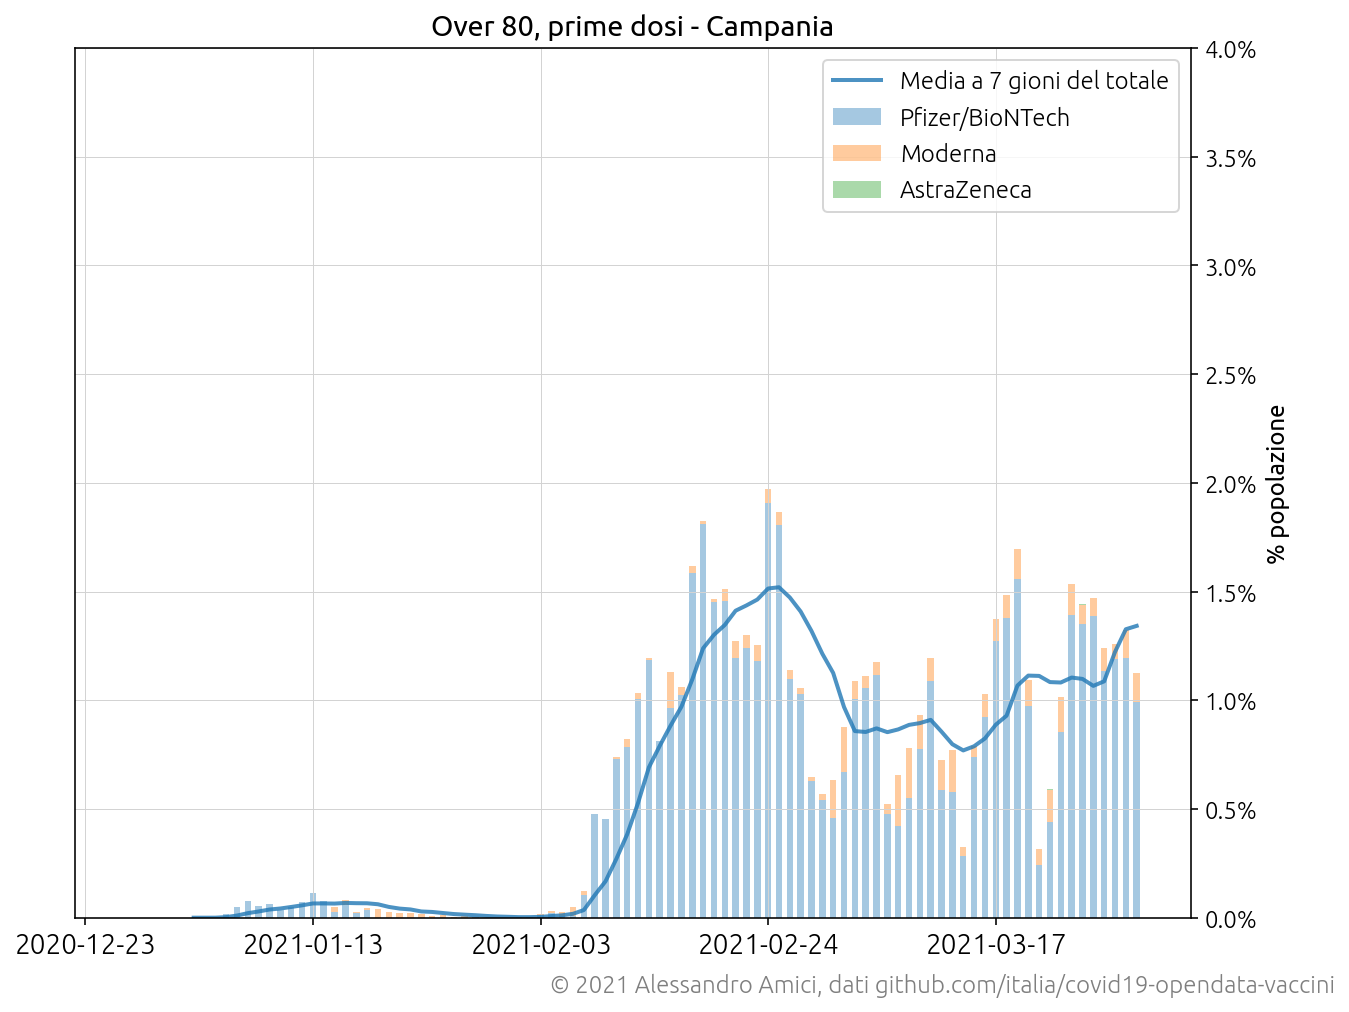

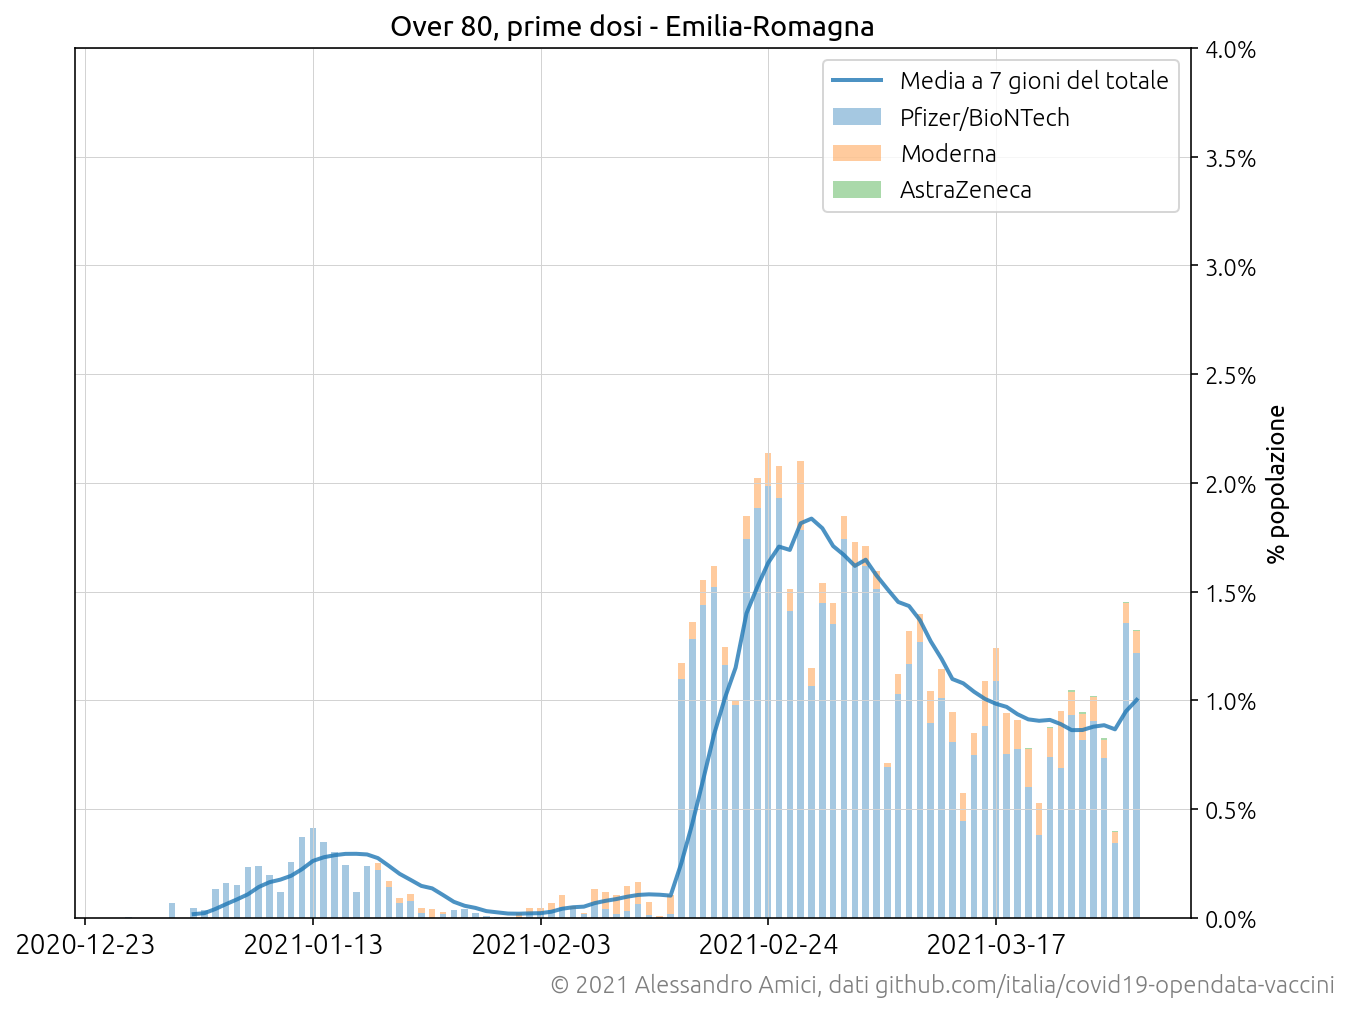

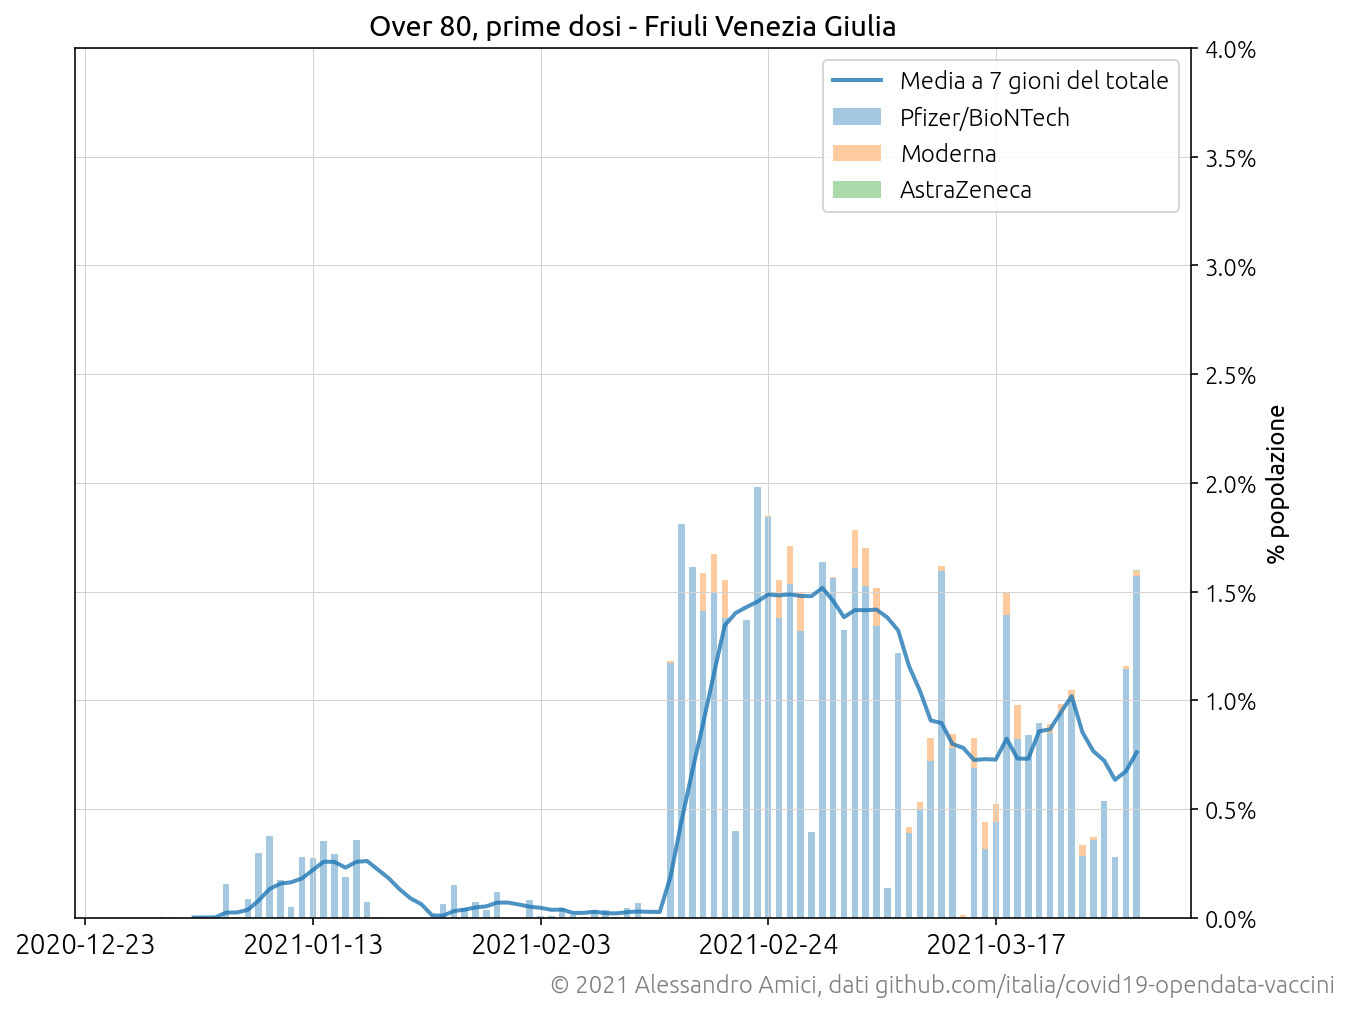

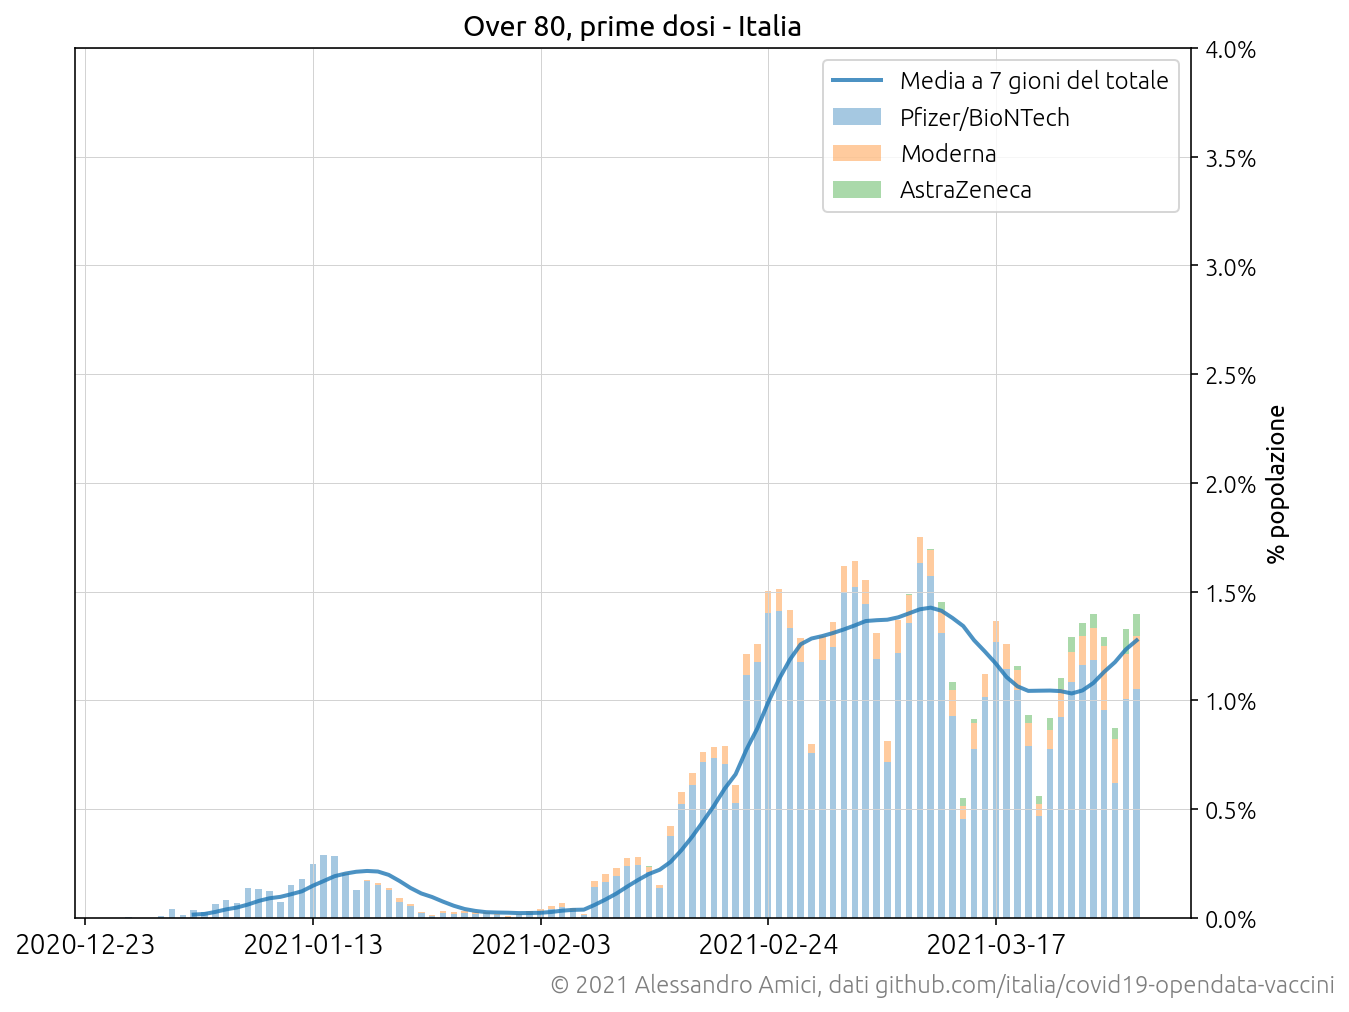

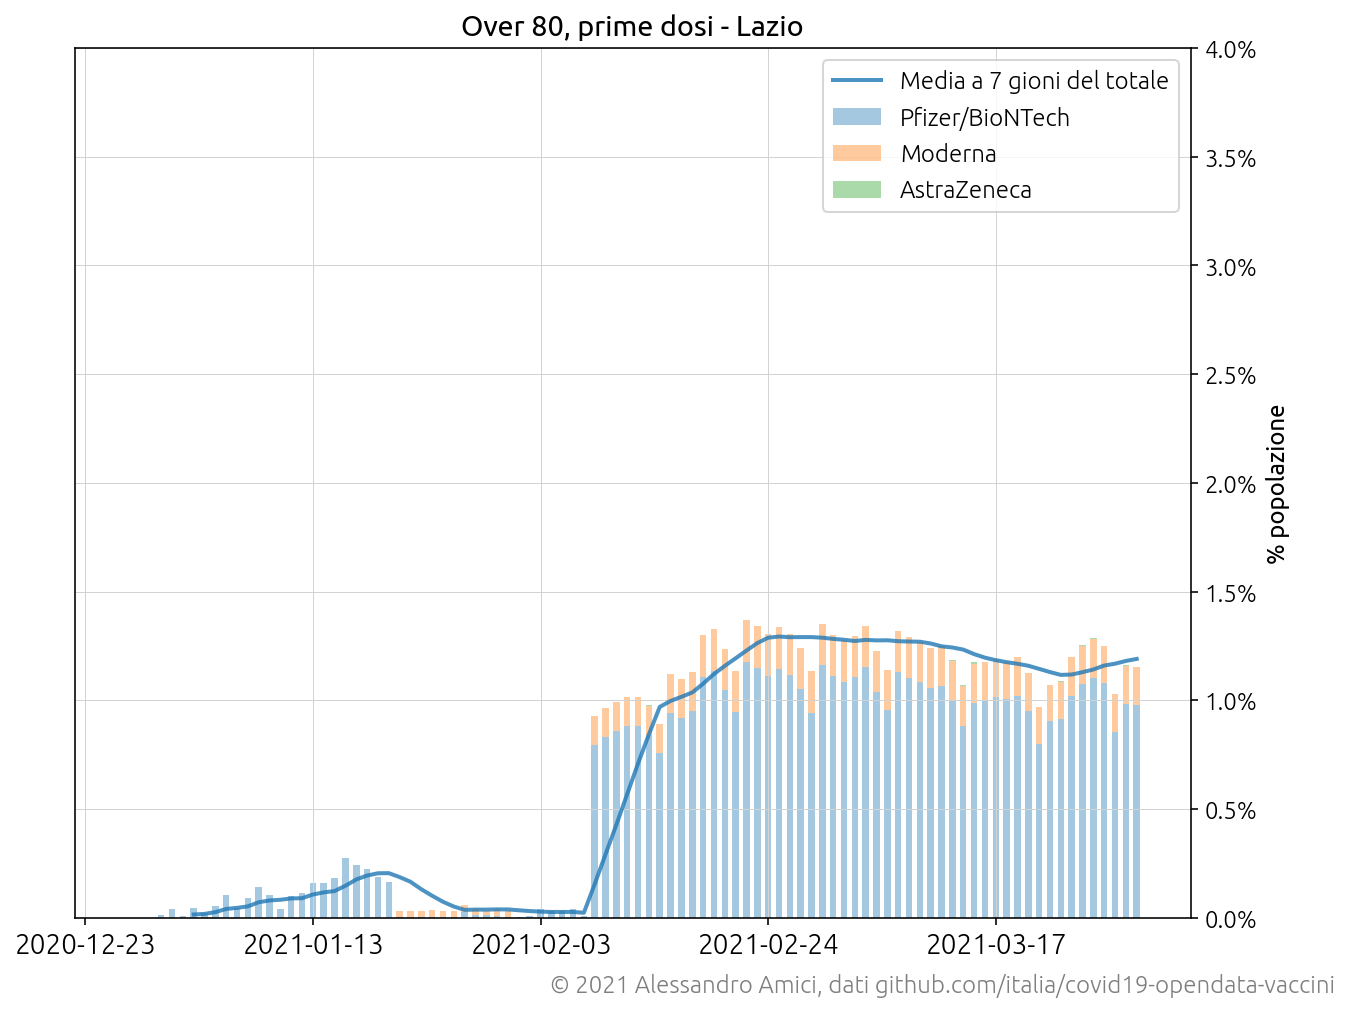

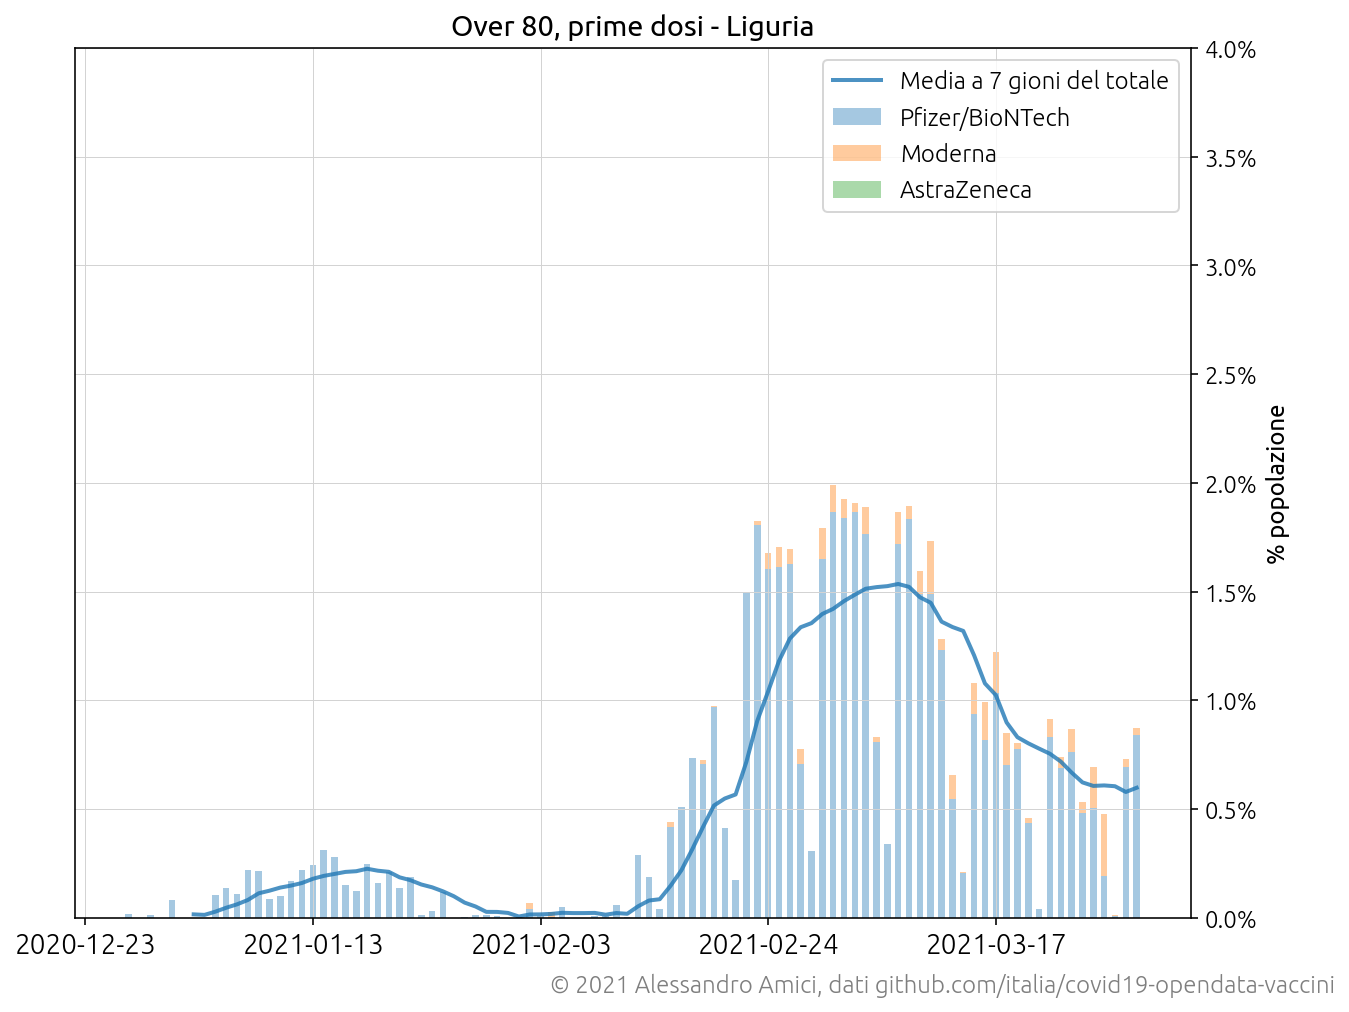

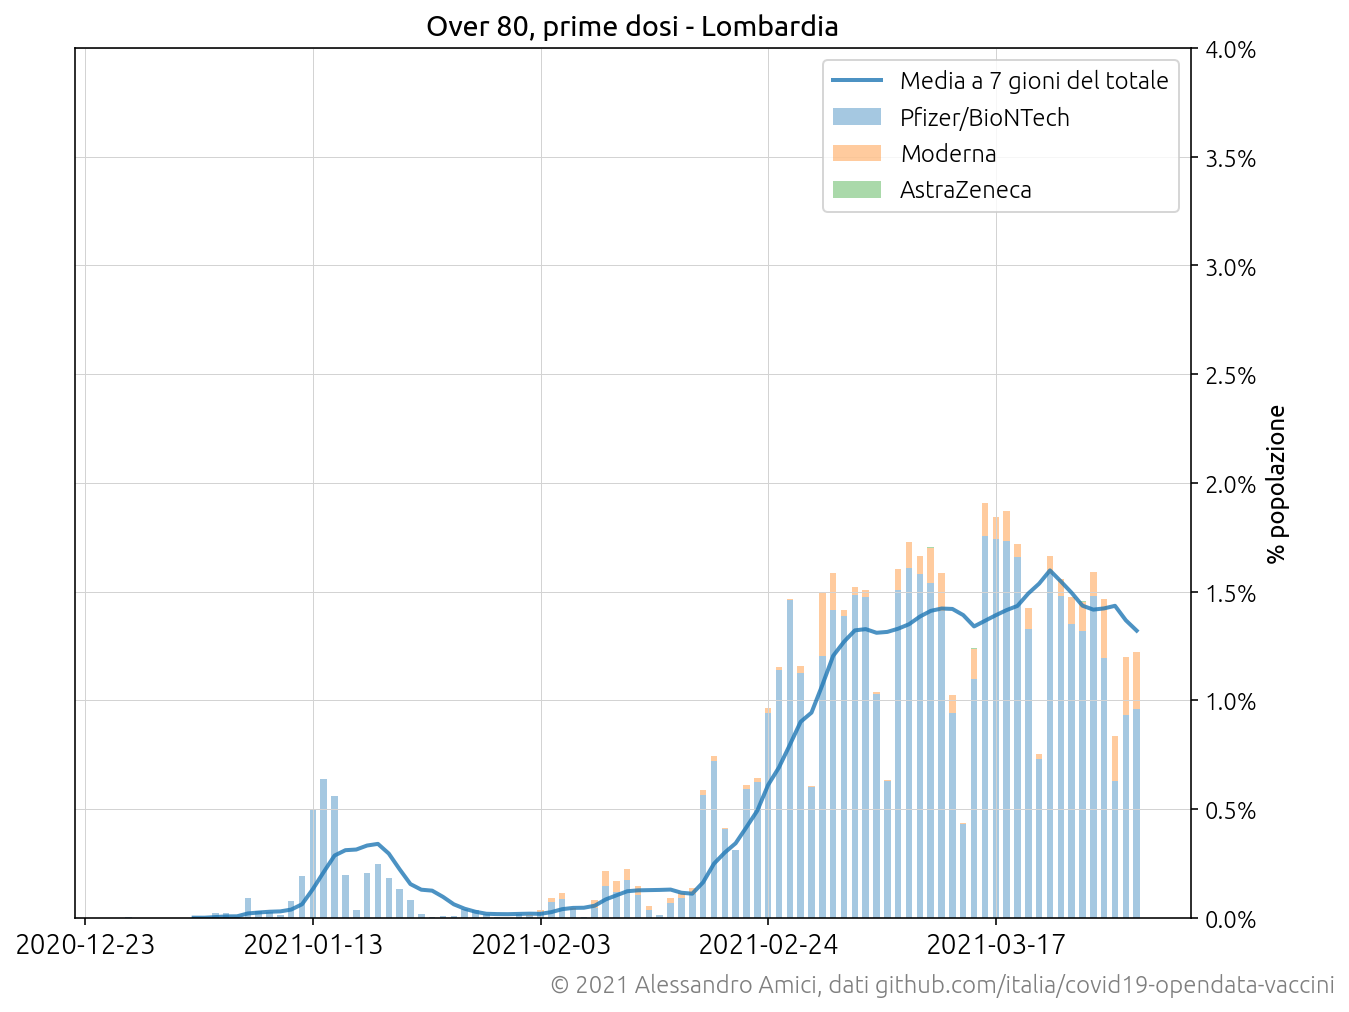

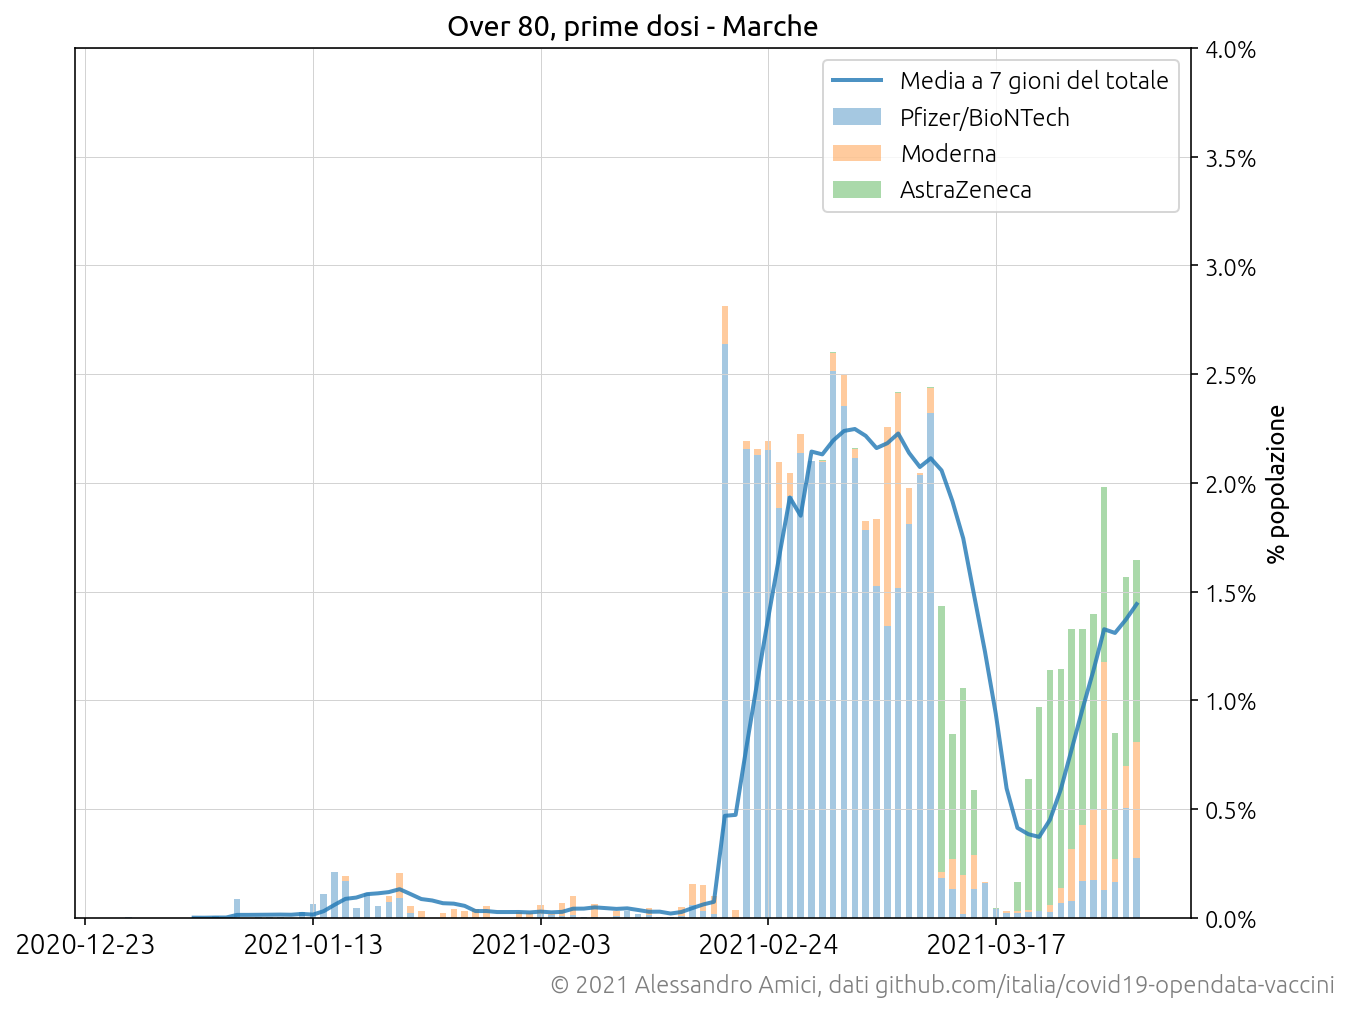

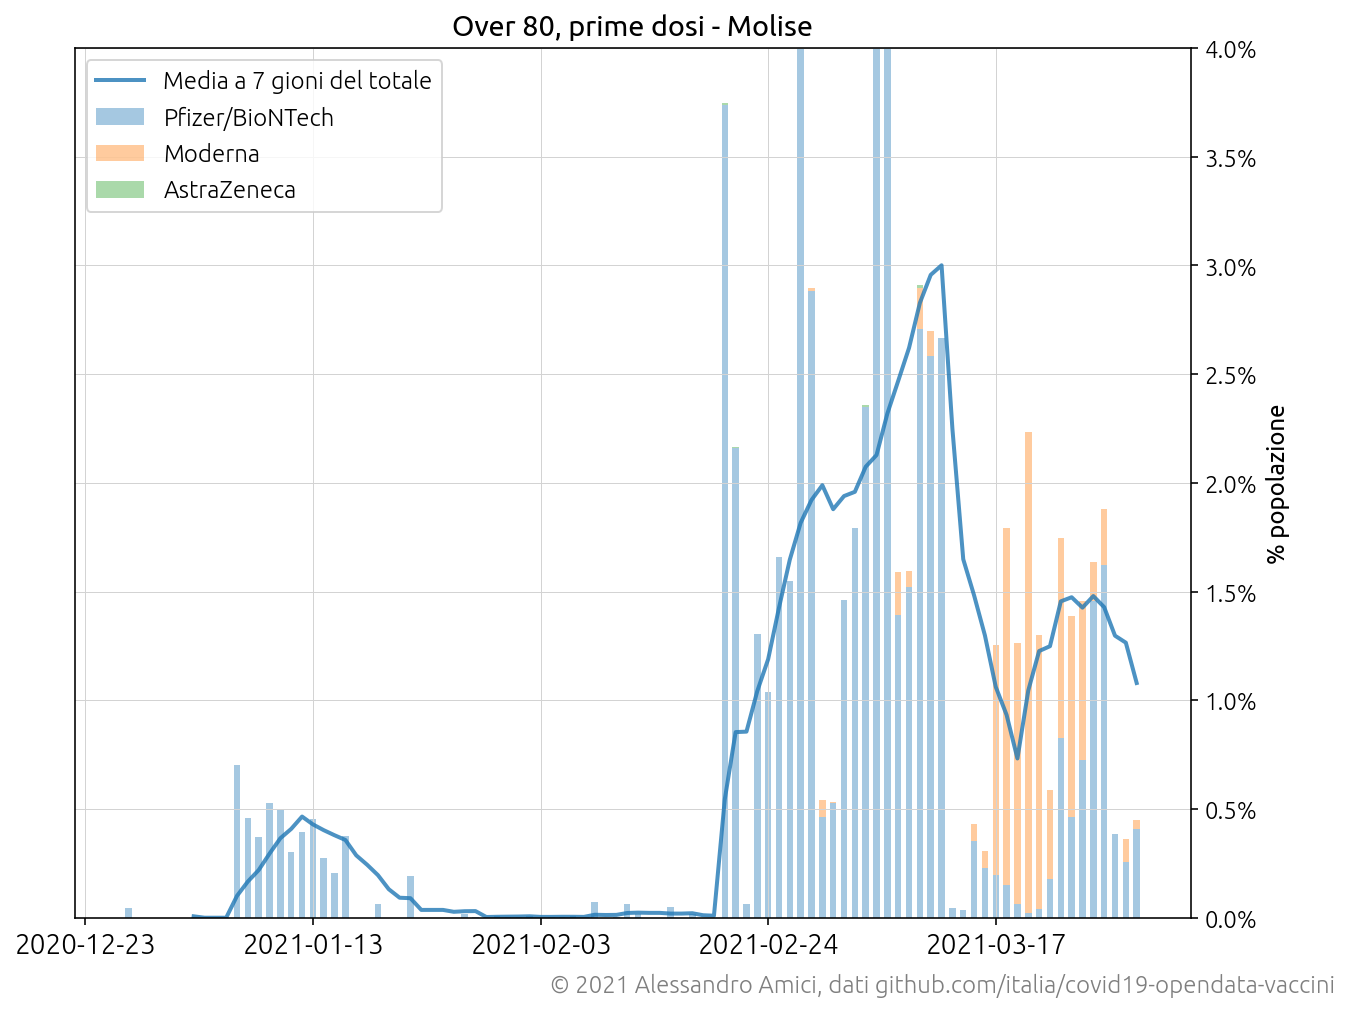

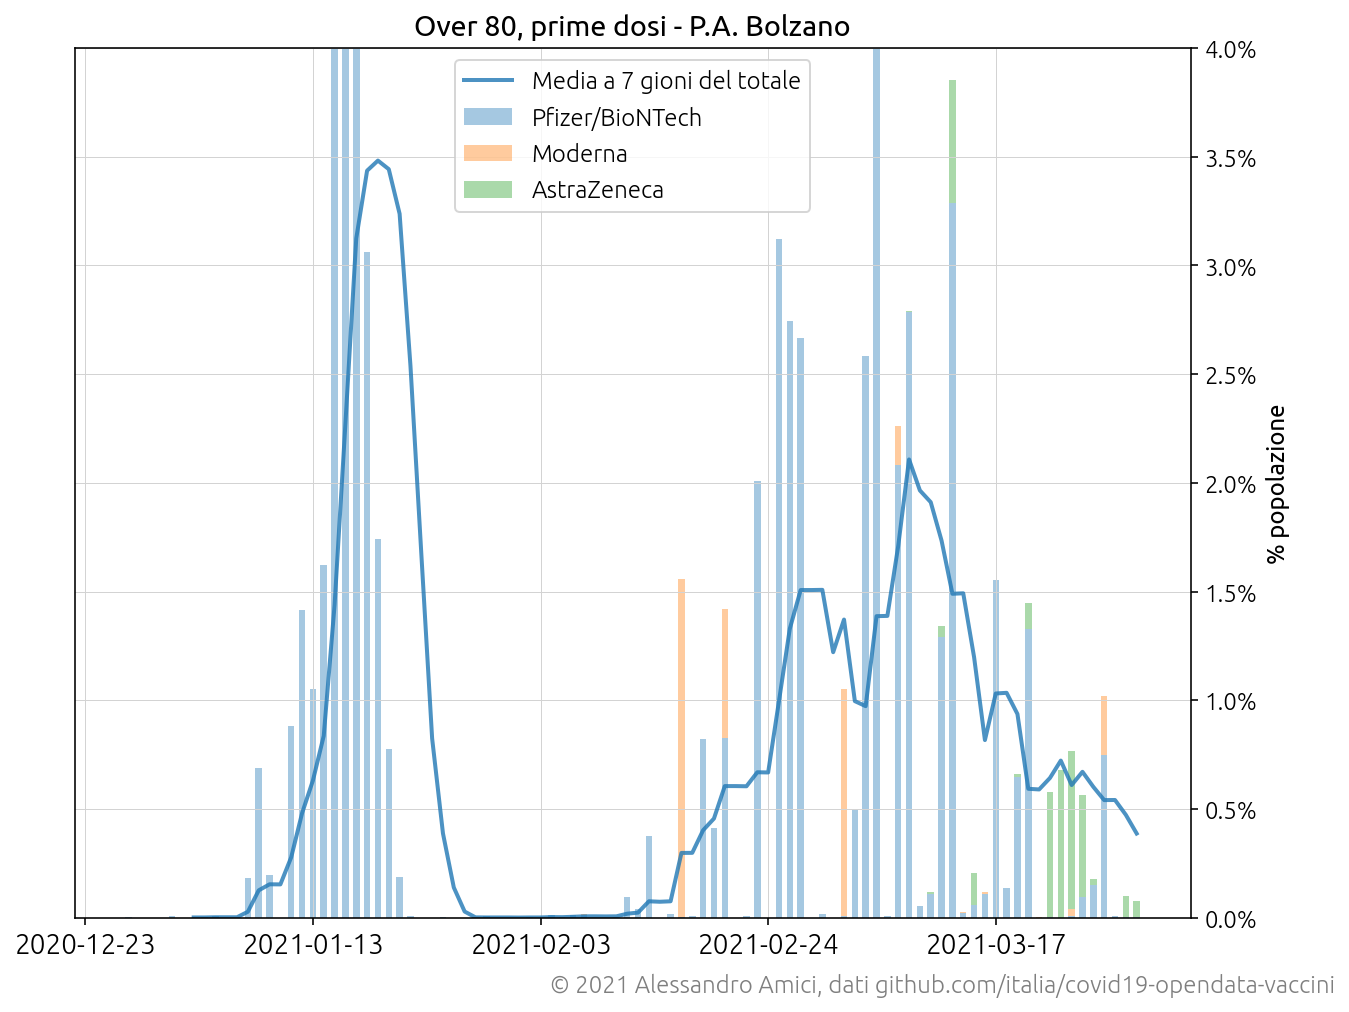

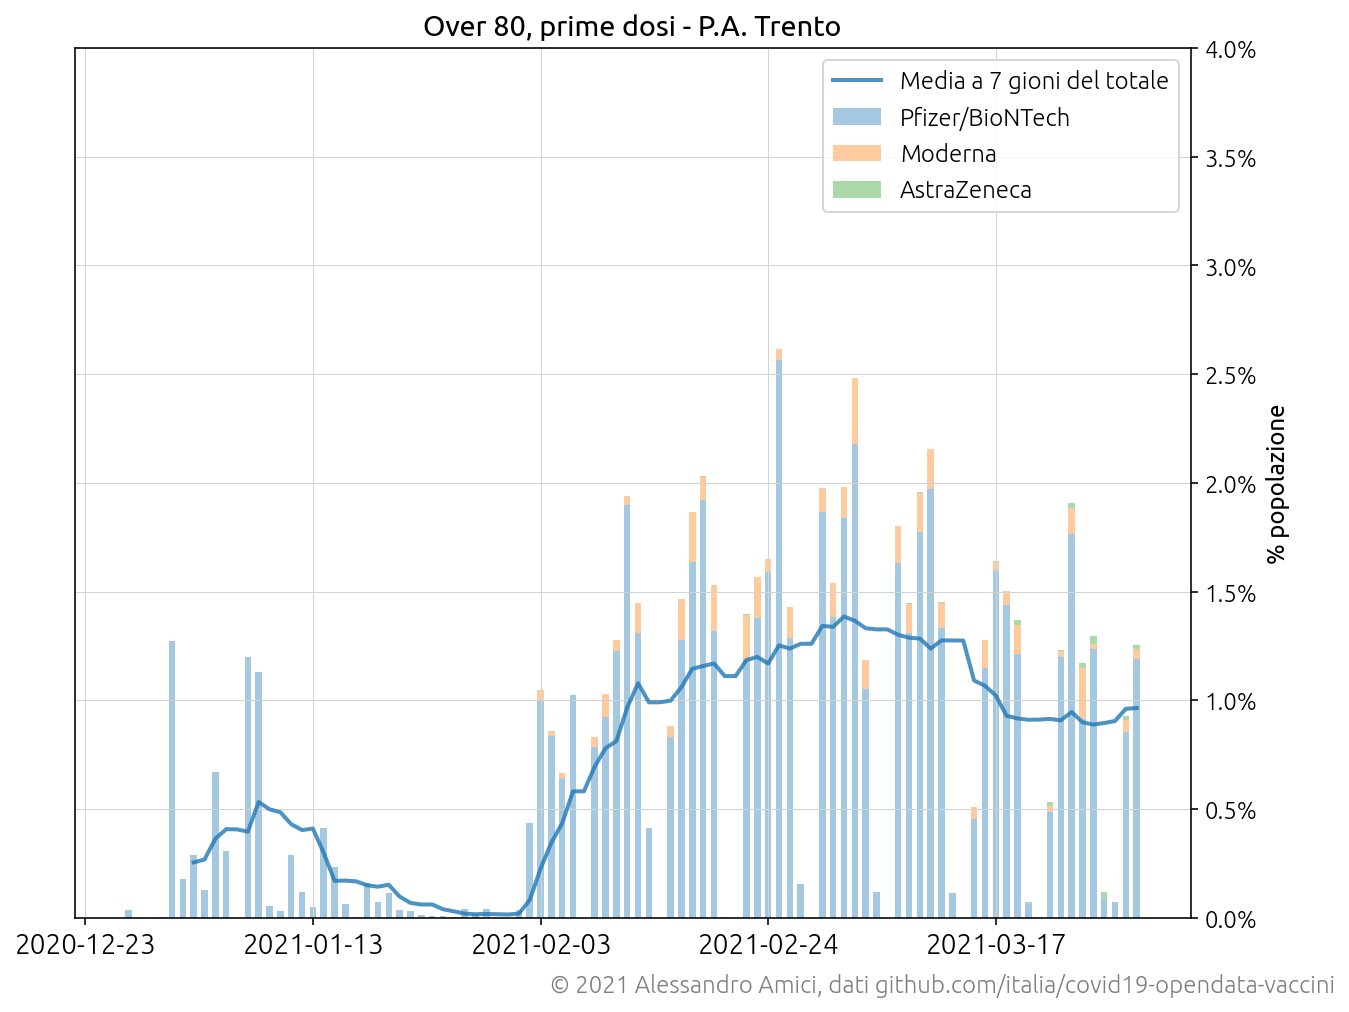

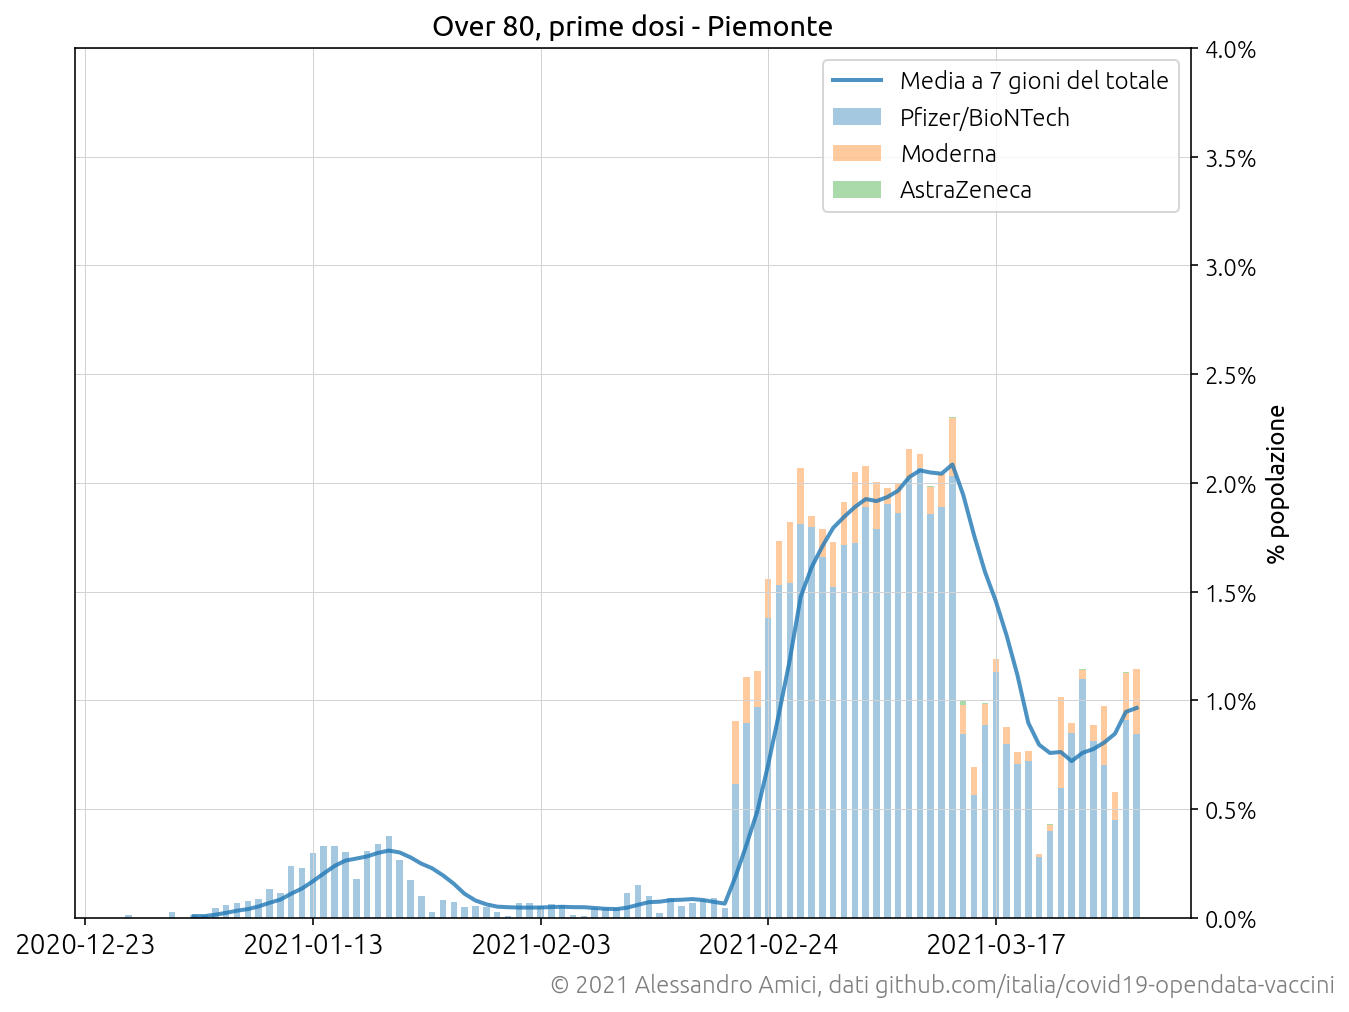

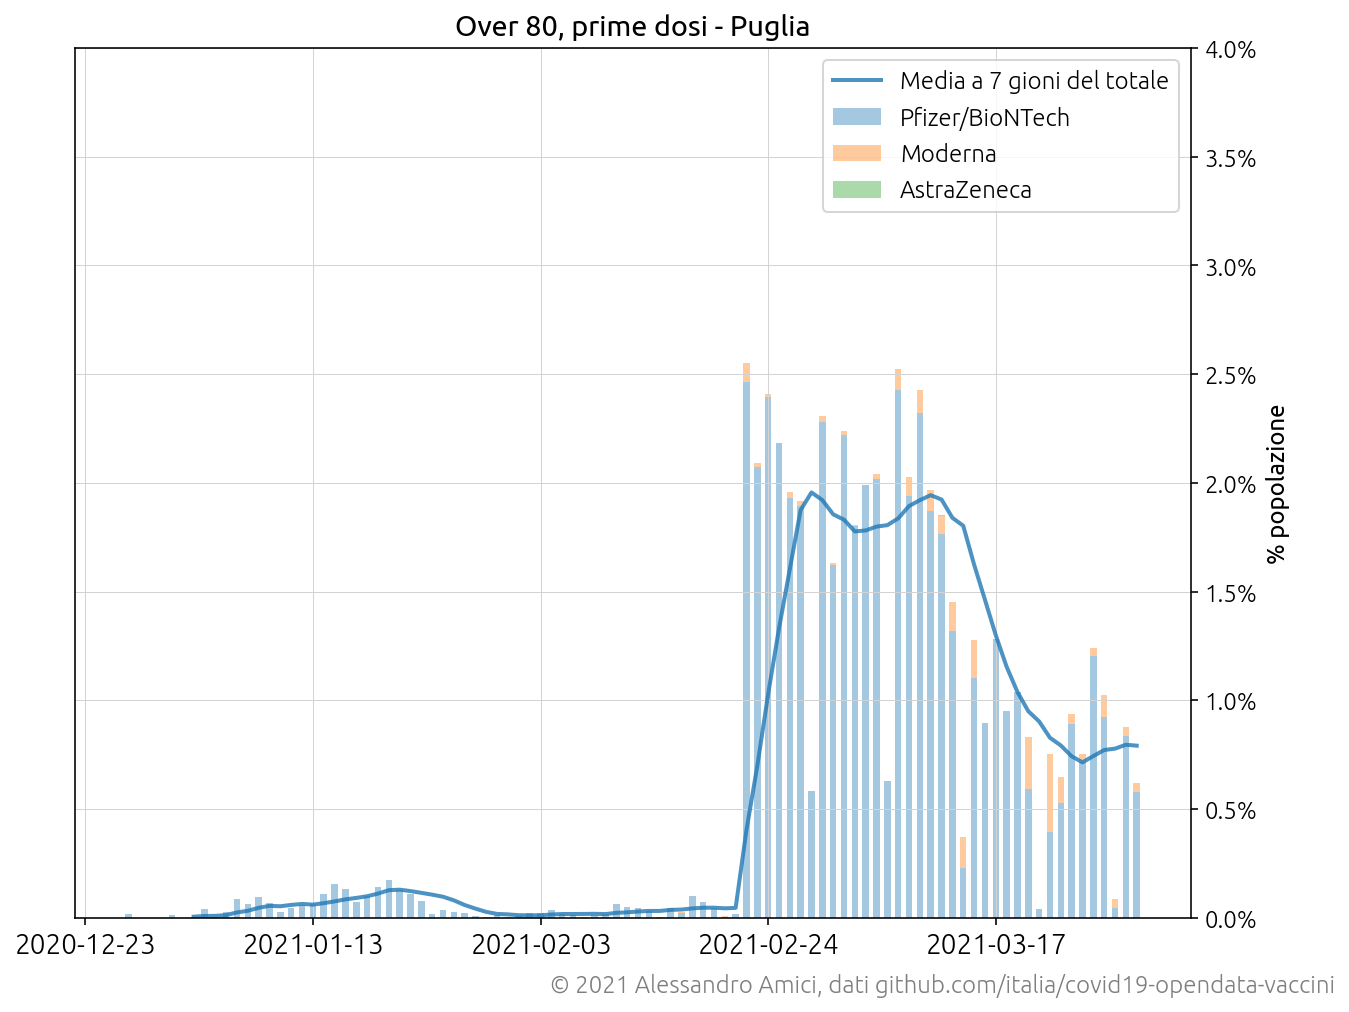

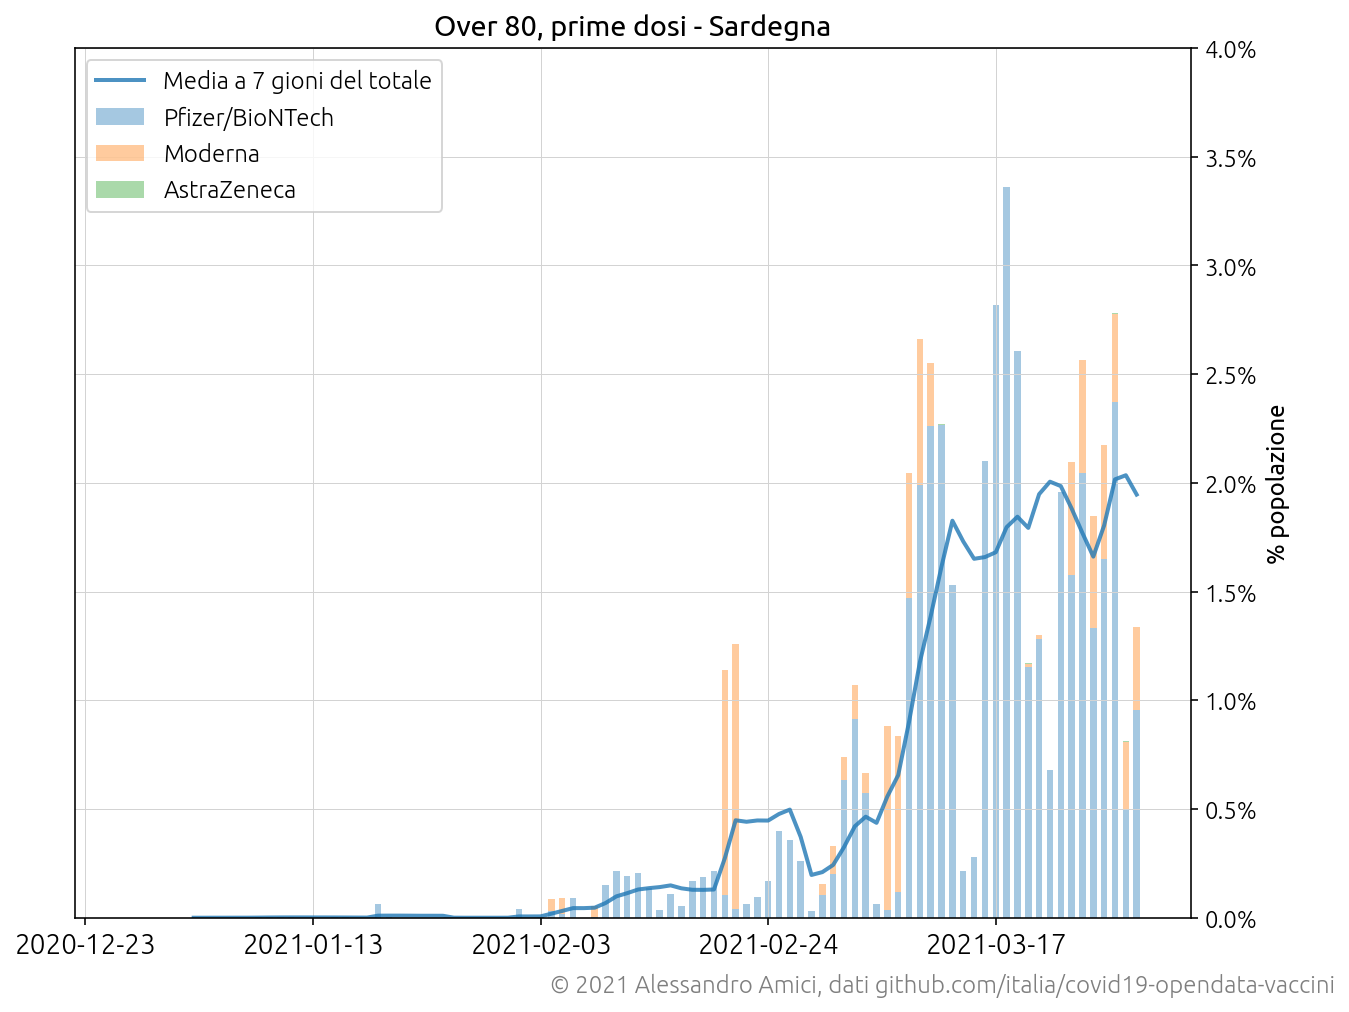

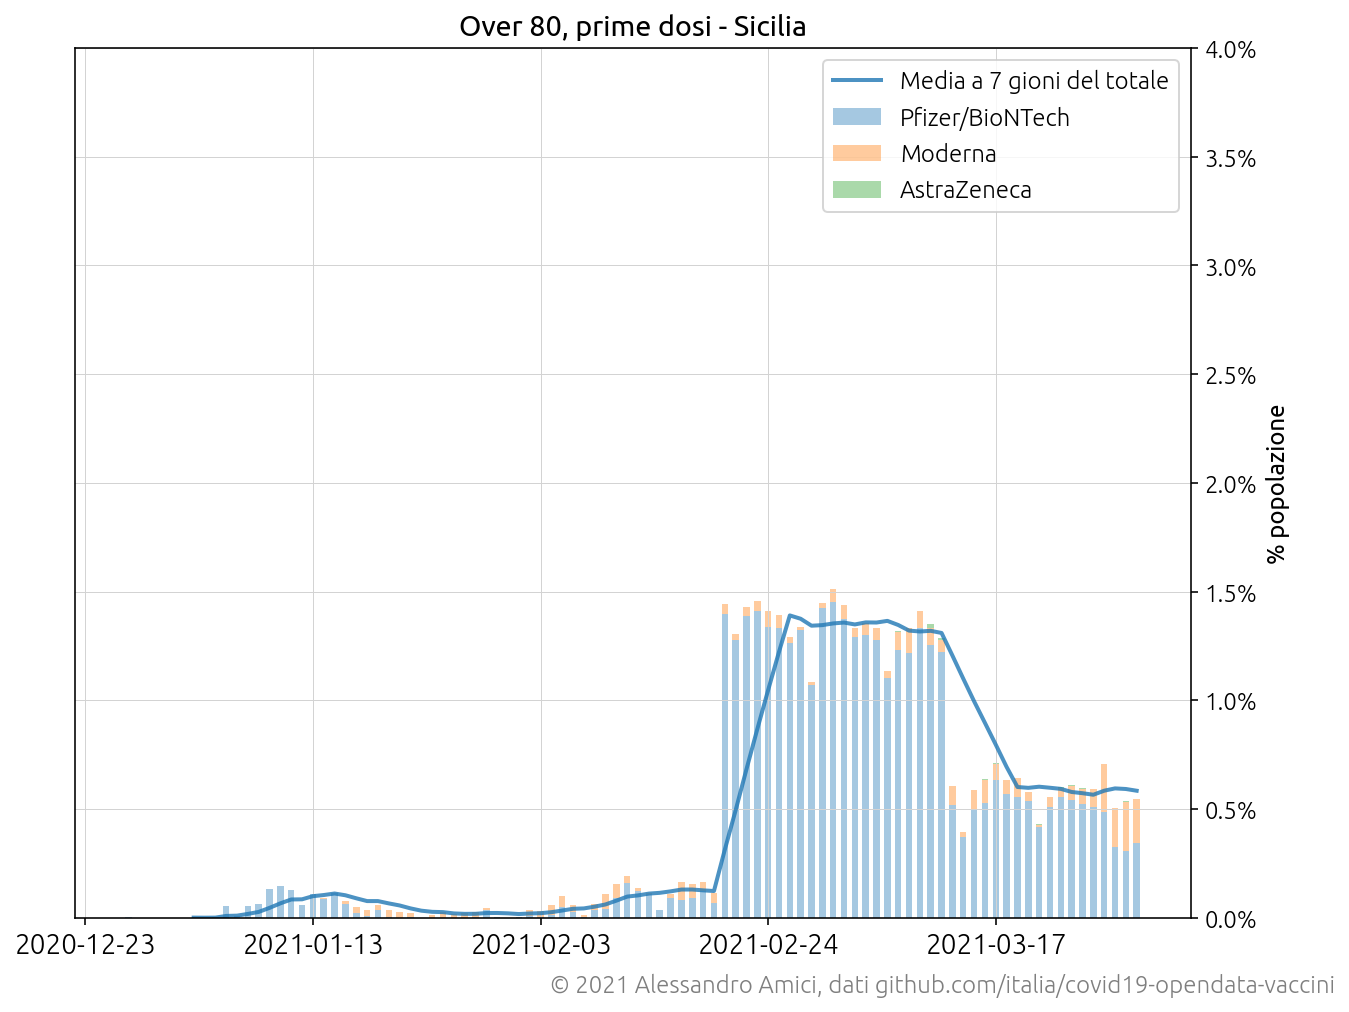

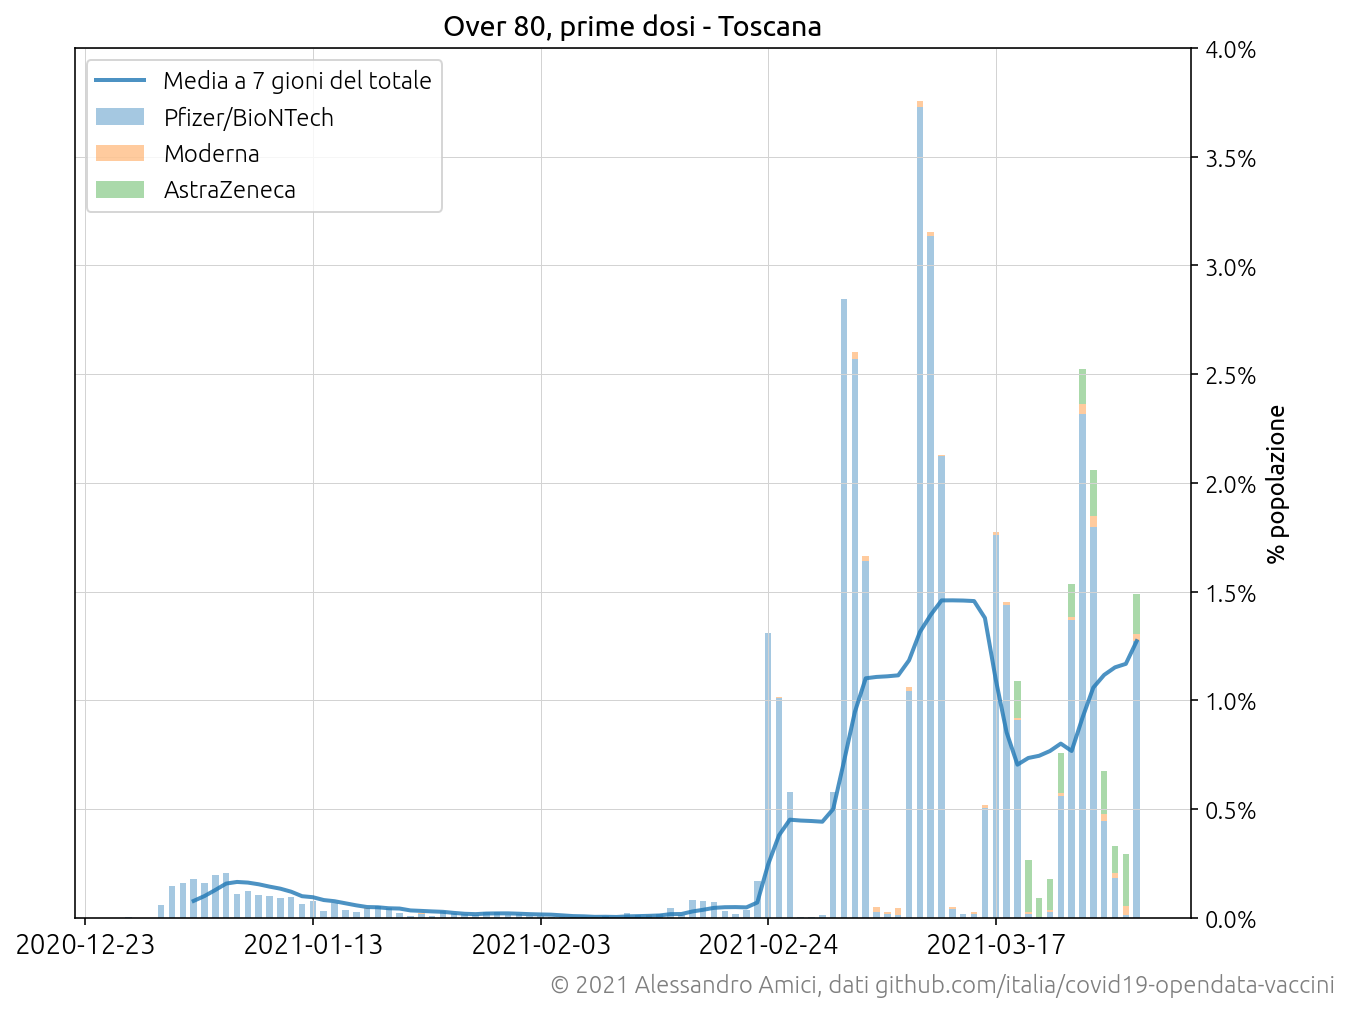

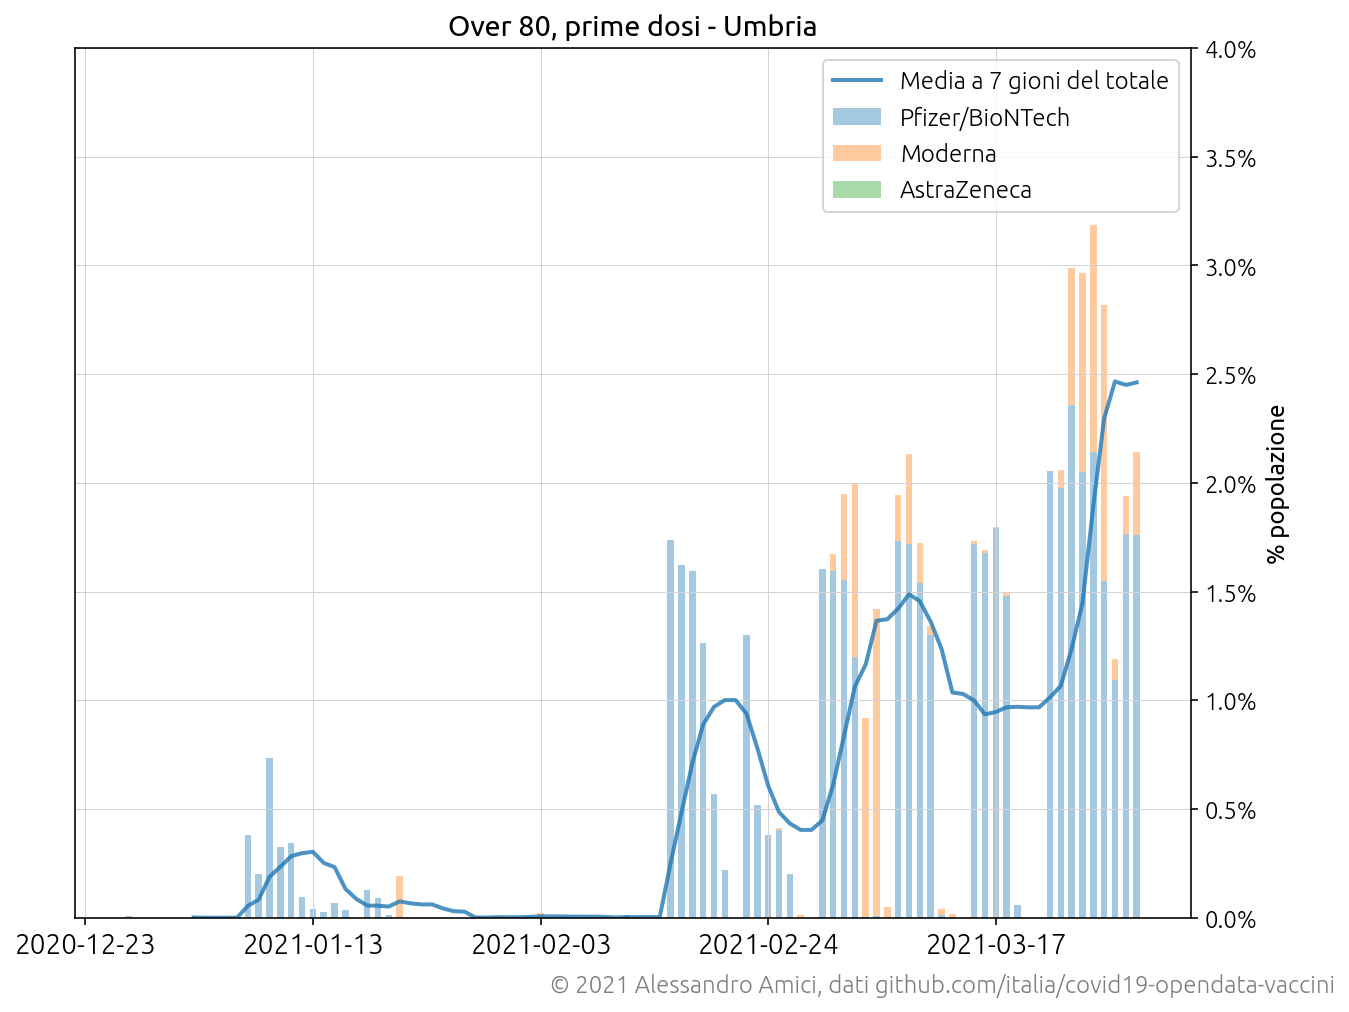

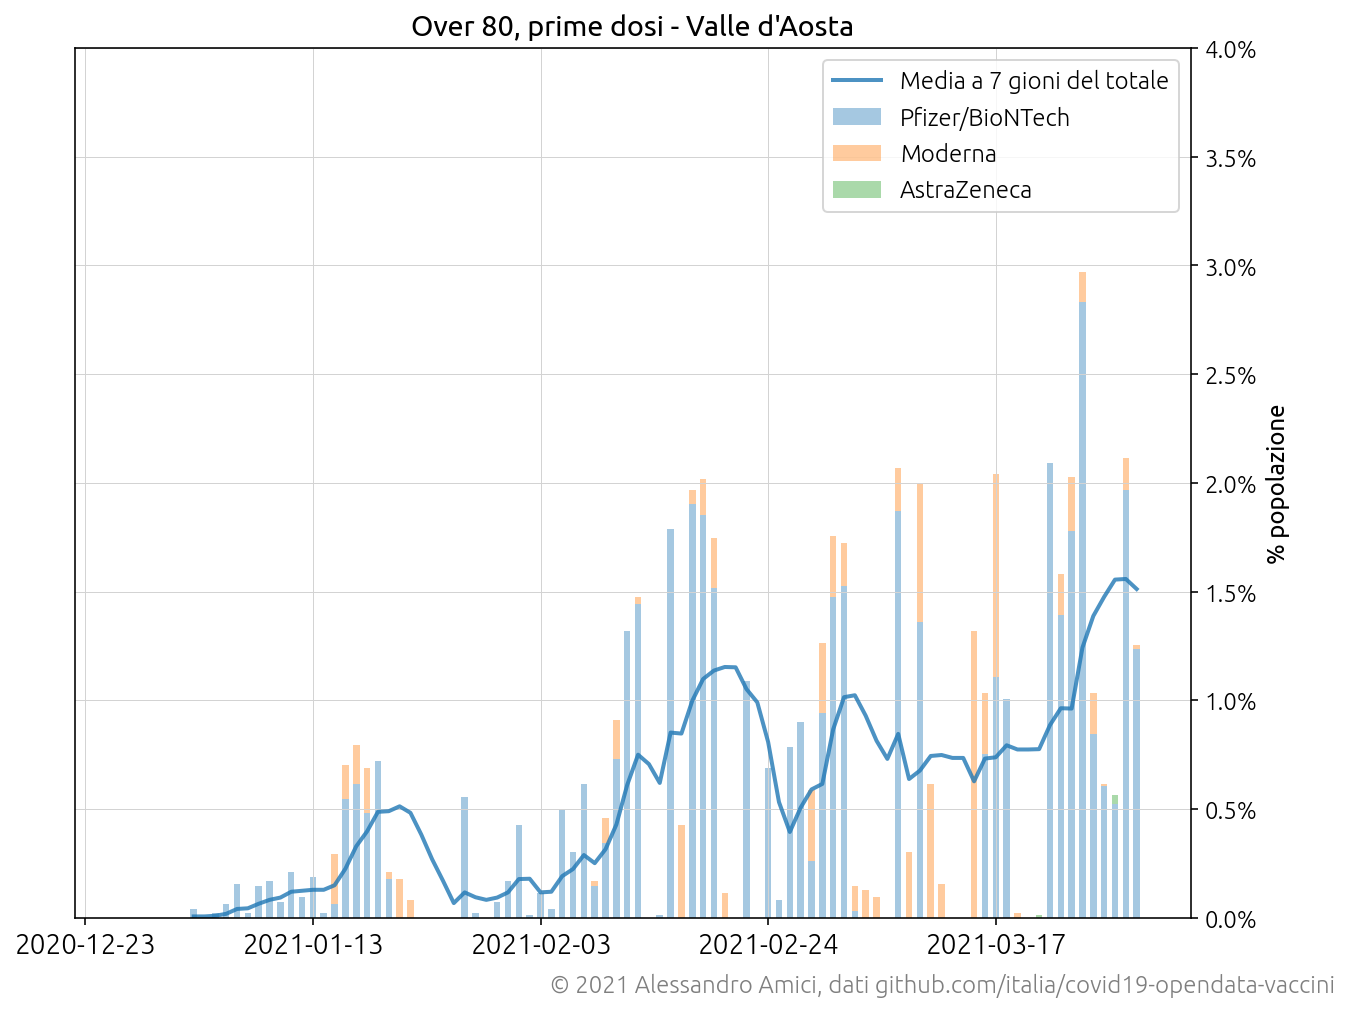

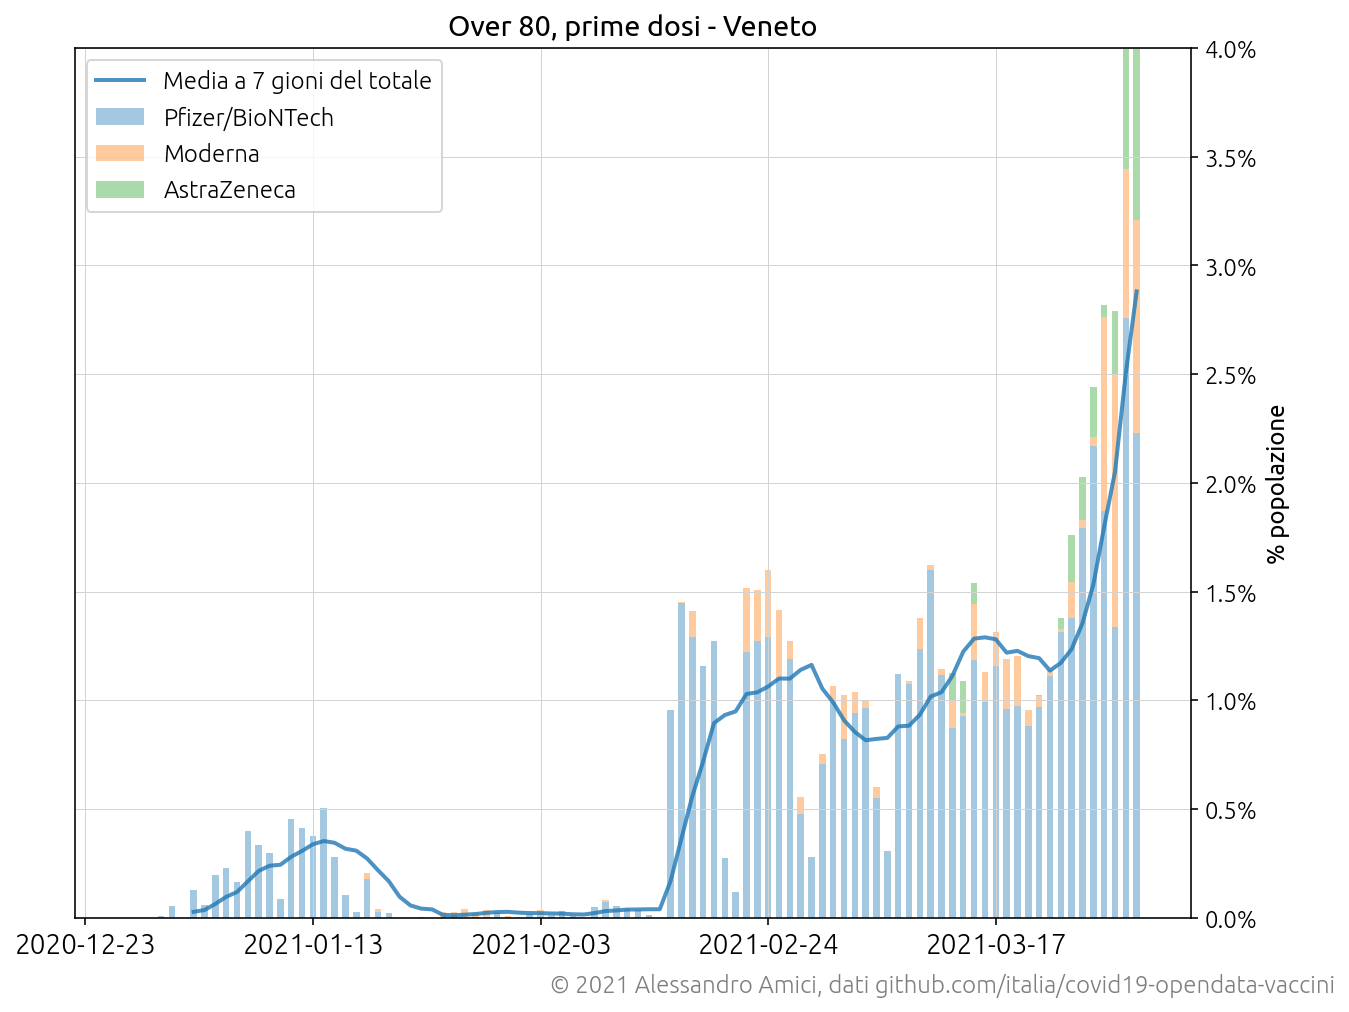

In [1089]:
for location in primers80.location.values:
    fig, ax = covid19.plot.subplots(note=COPYRIGHT)
    covid19.plot.stack_xarray(primers80_pm.sel(location=location), hue="provider", window=7, title=f"Over 80, prime dosi - {location}", ylim=(0, 0.04), label_total="Media a 7 gioni del totale", ax=ax)
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1, 1))
    ax.set(ylabel="% popolazione")
    ax.legend()

../covid19/plot.py:196: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(*args, **kwargs)


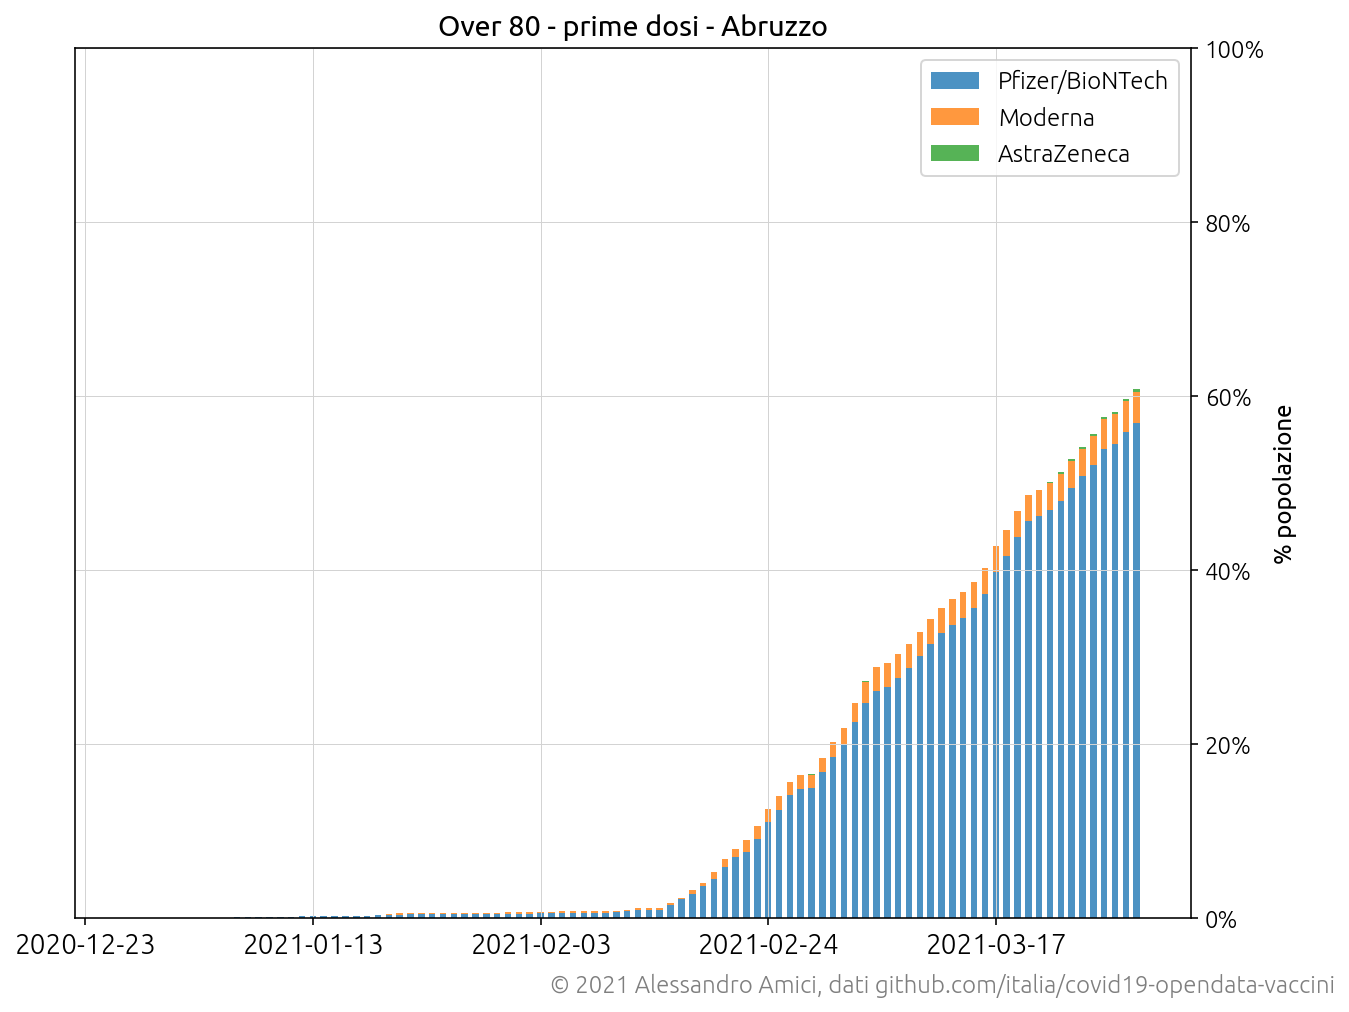

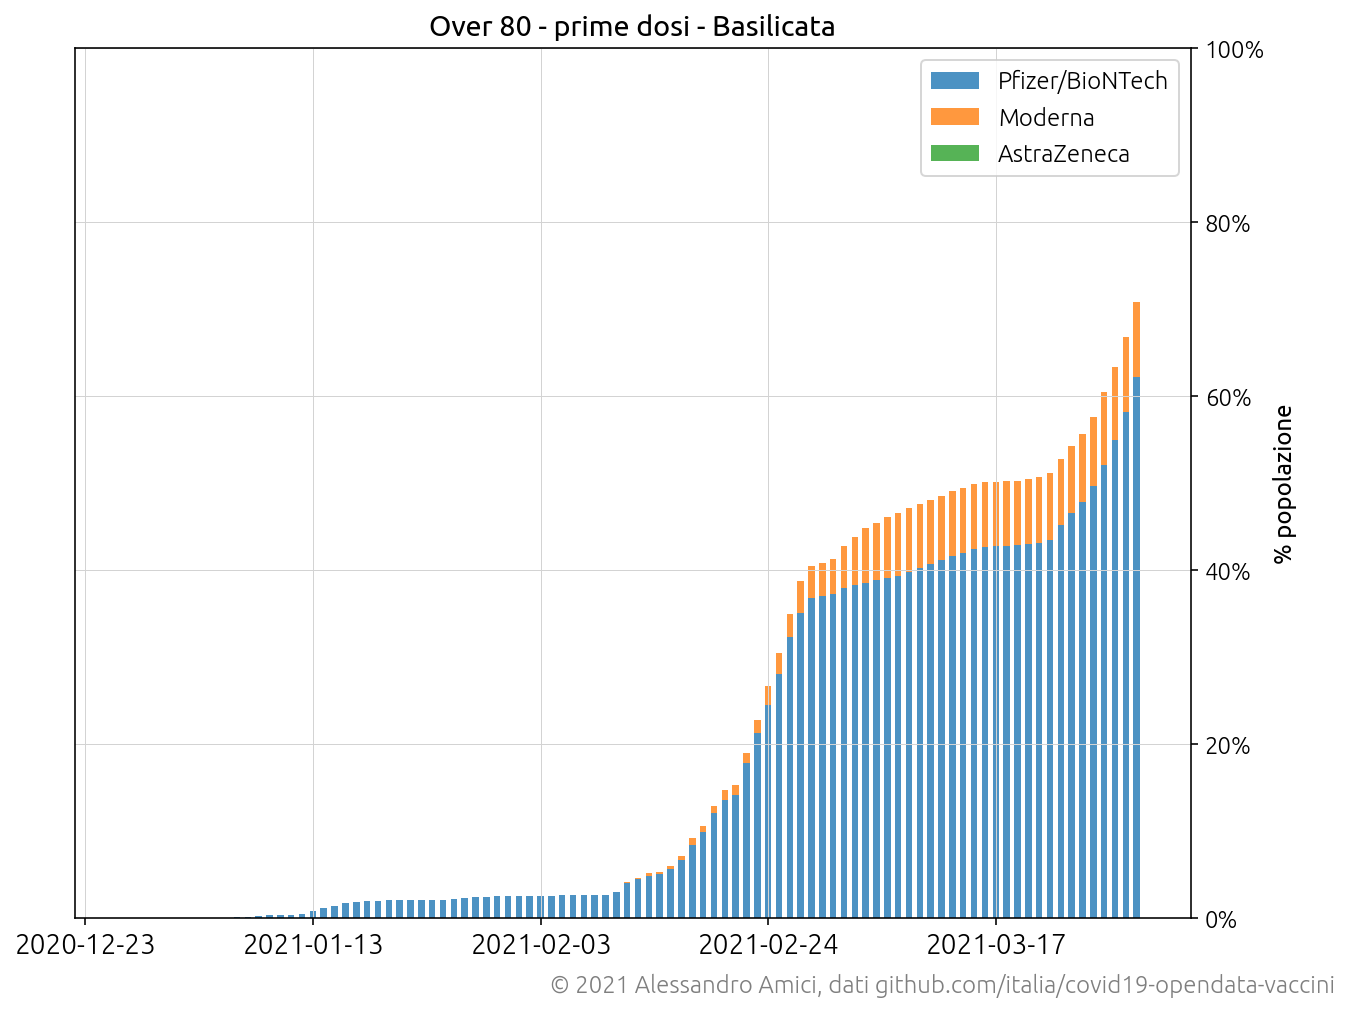

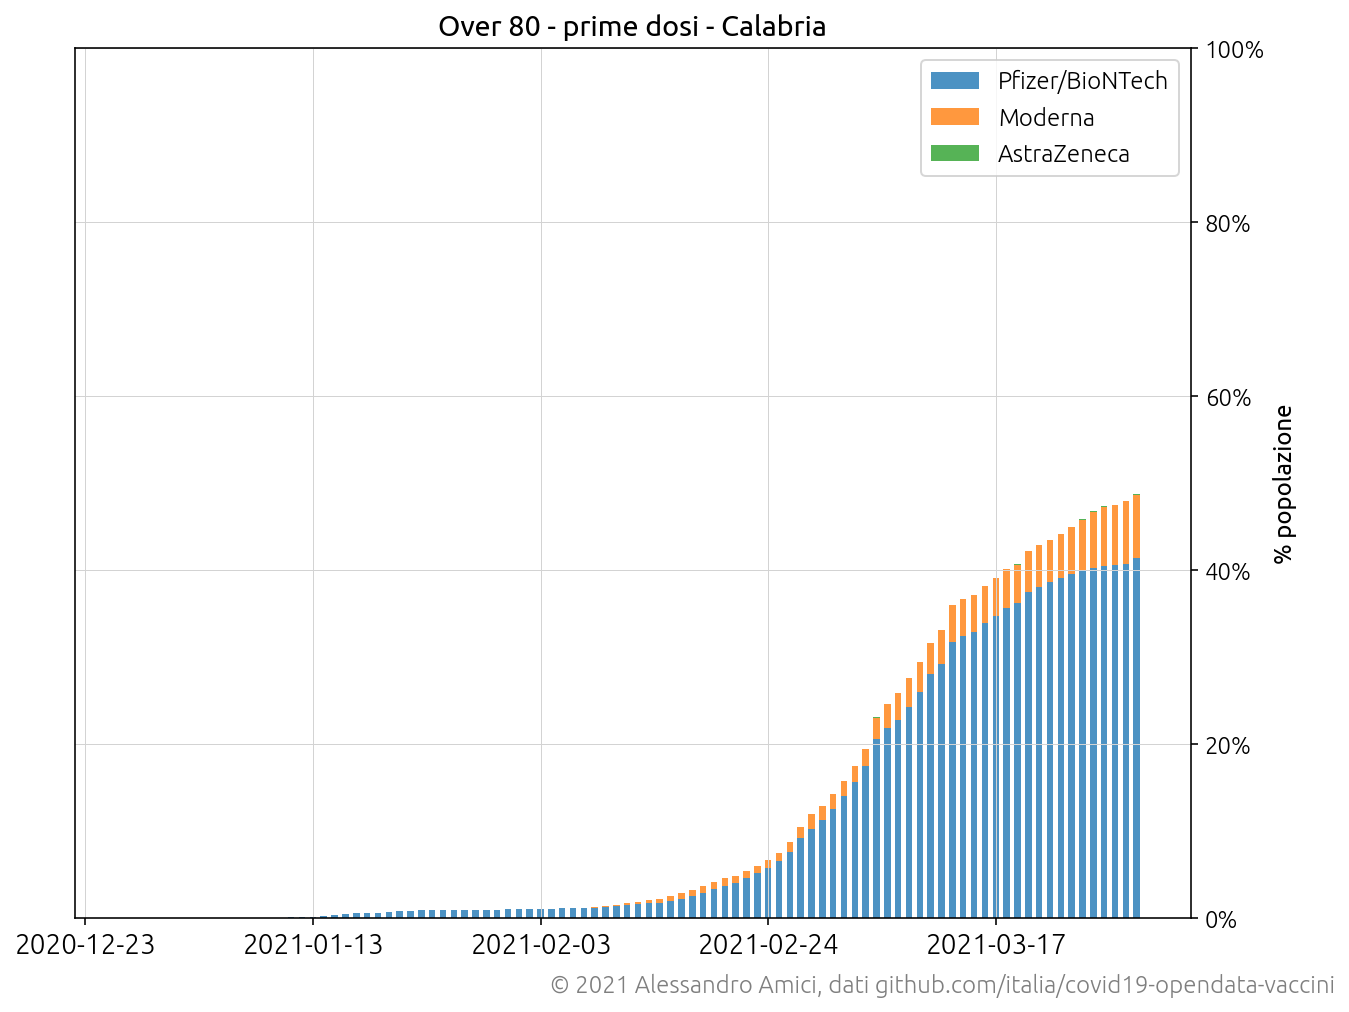

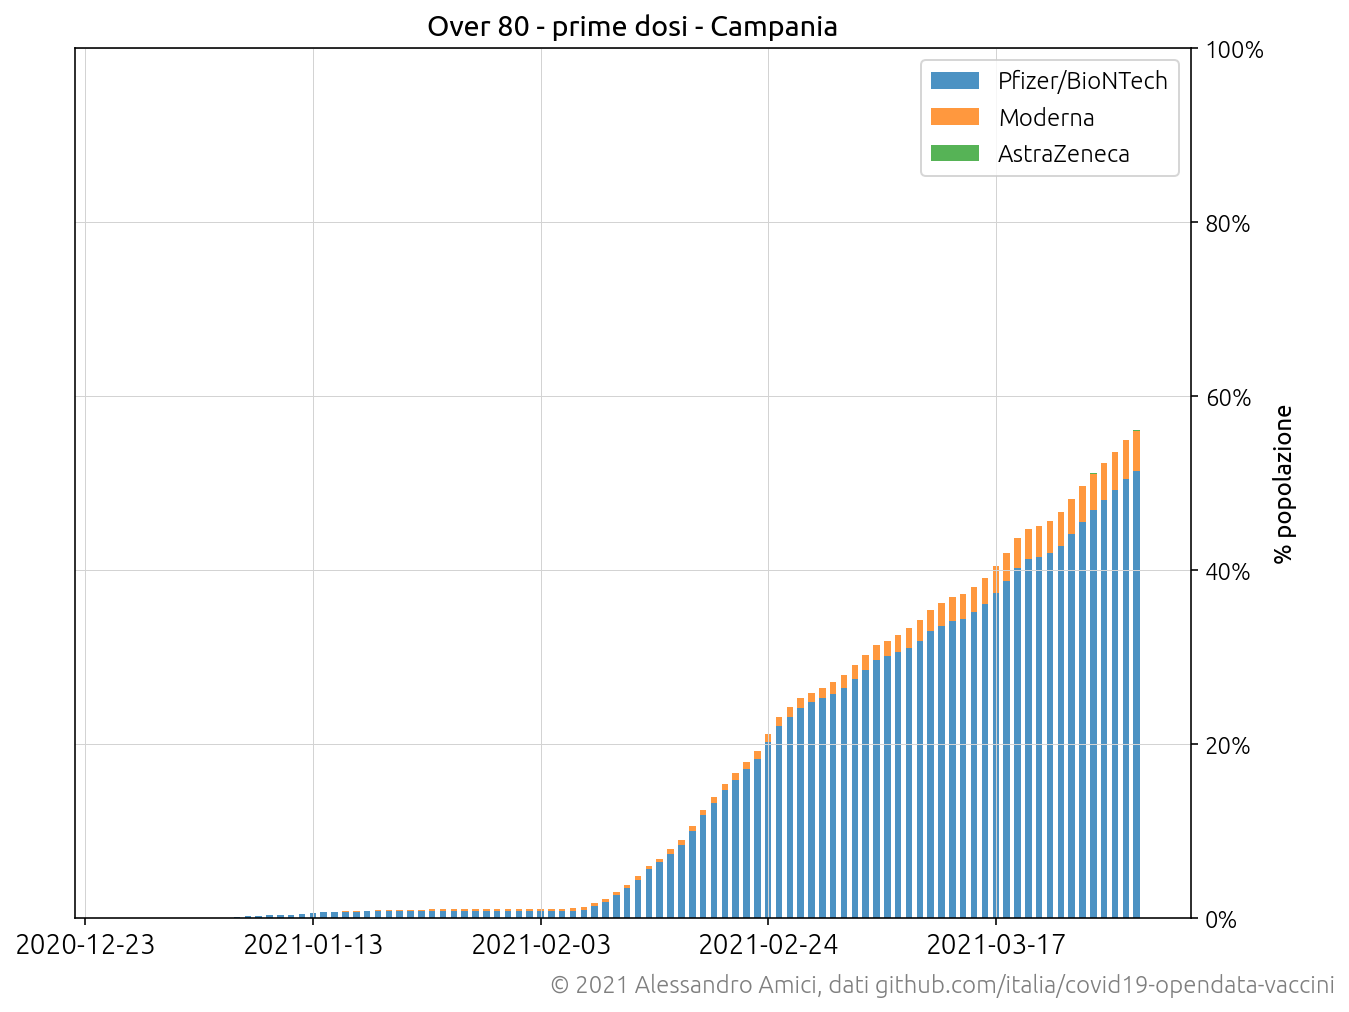

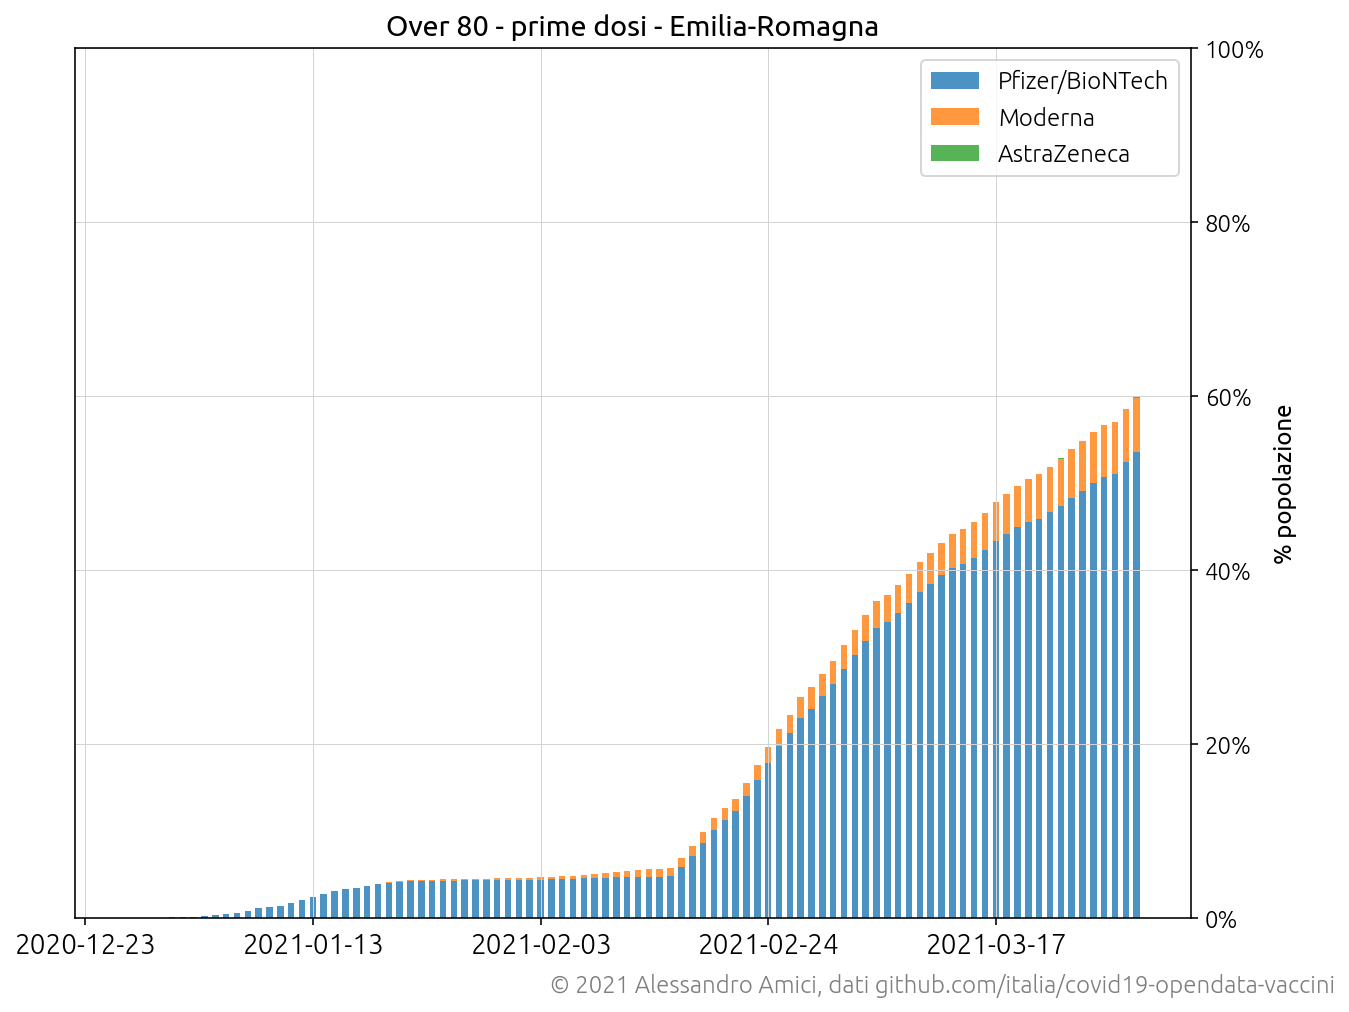

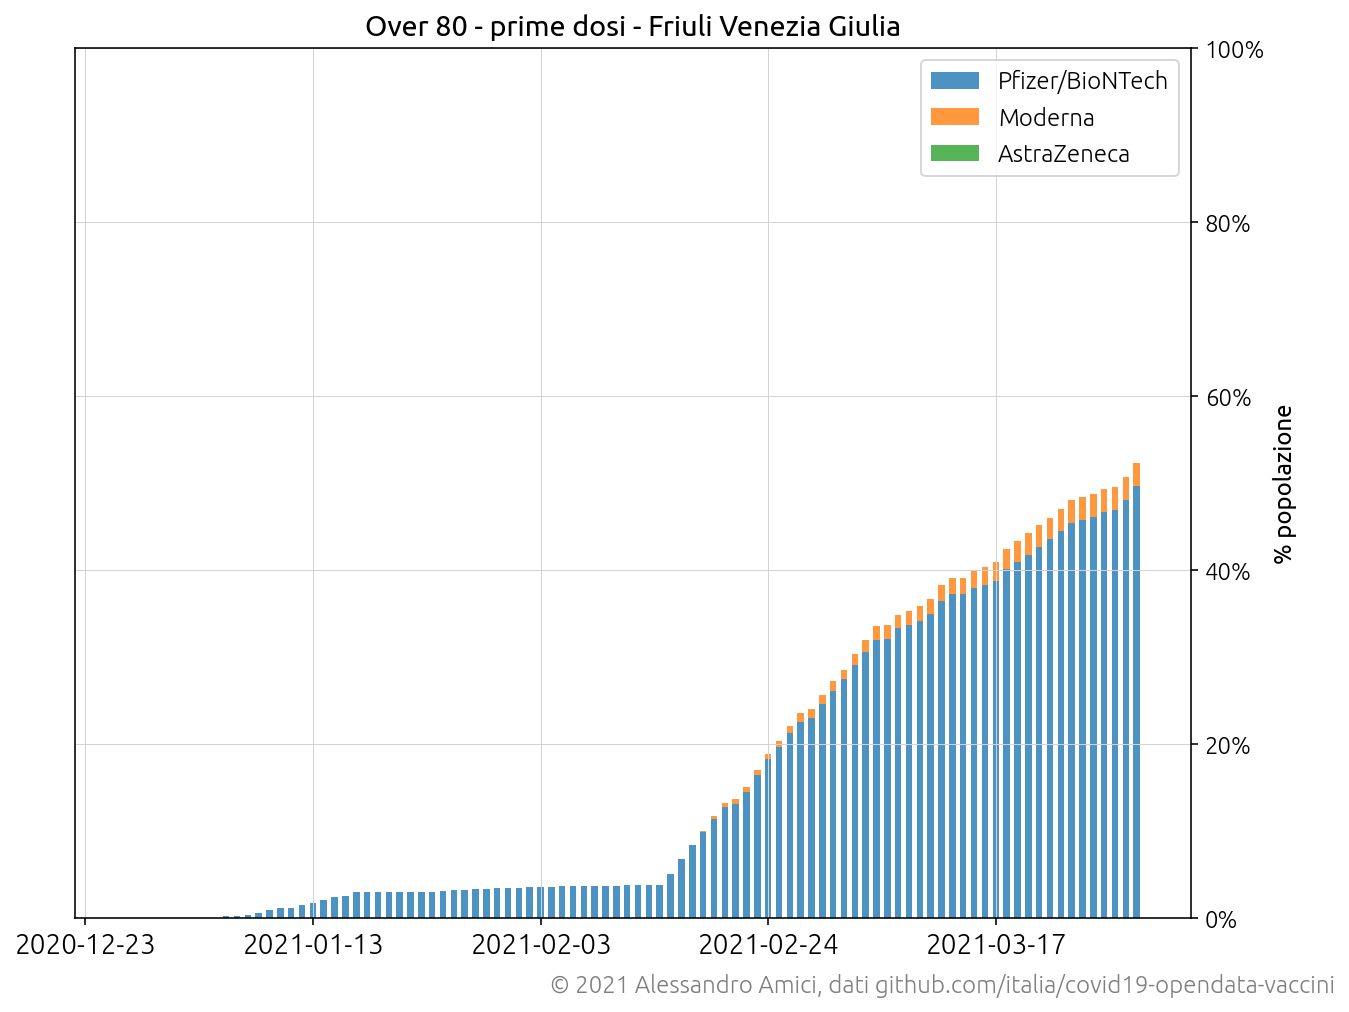

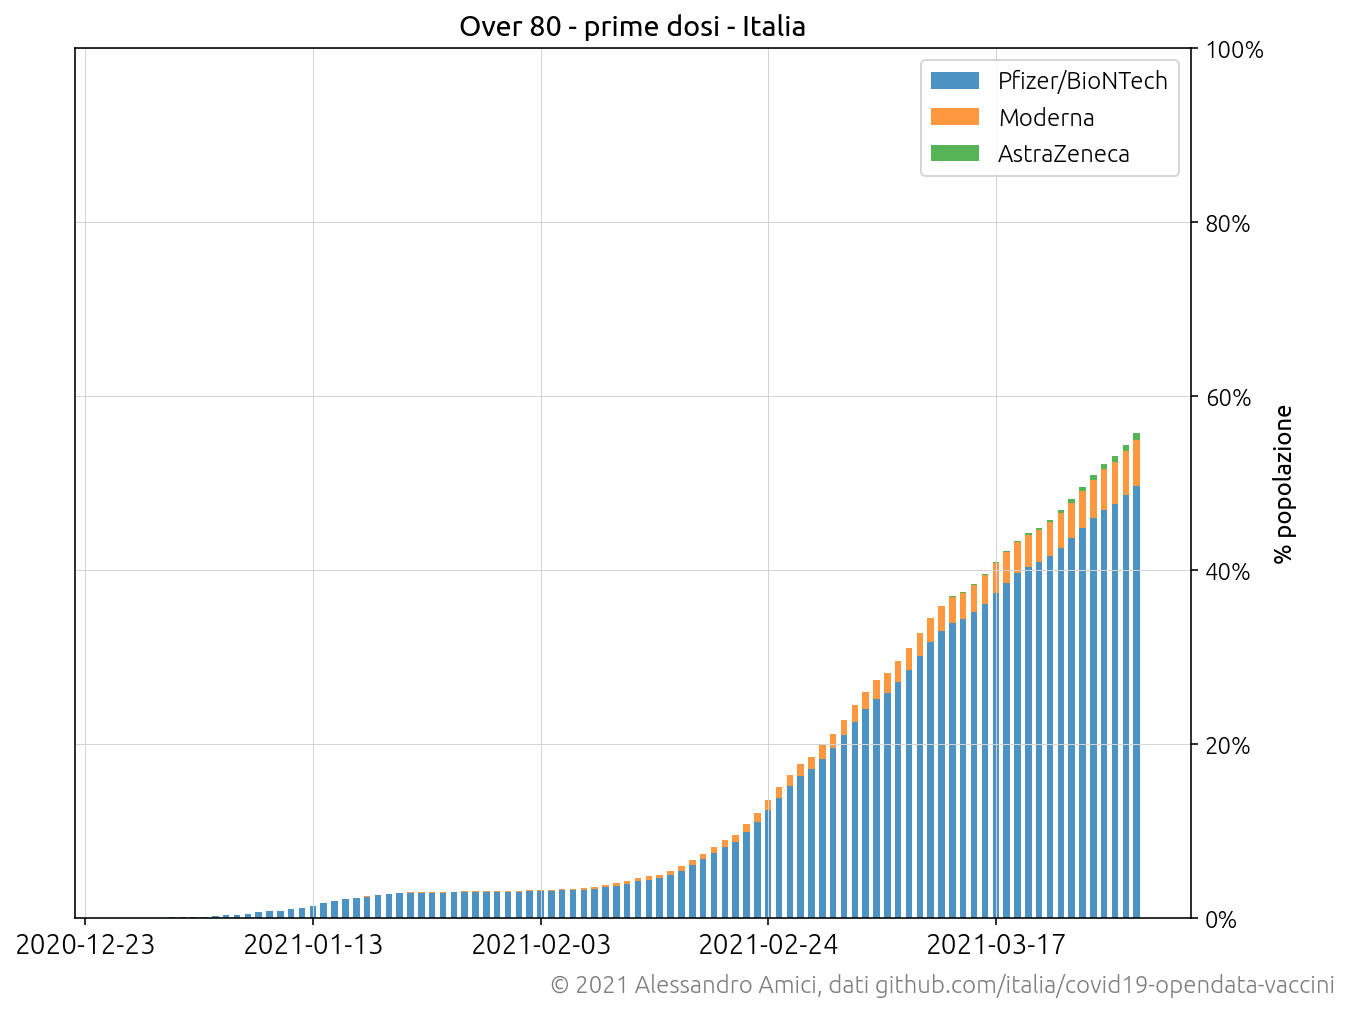

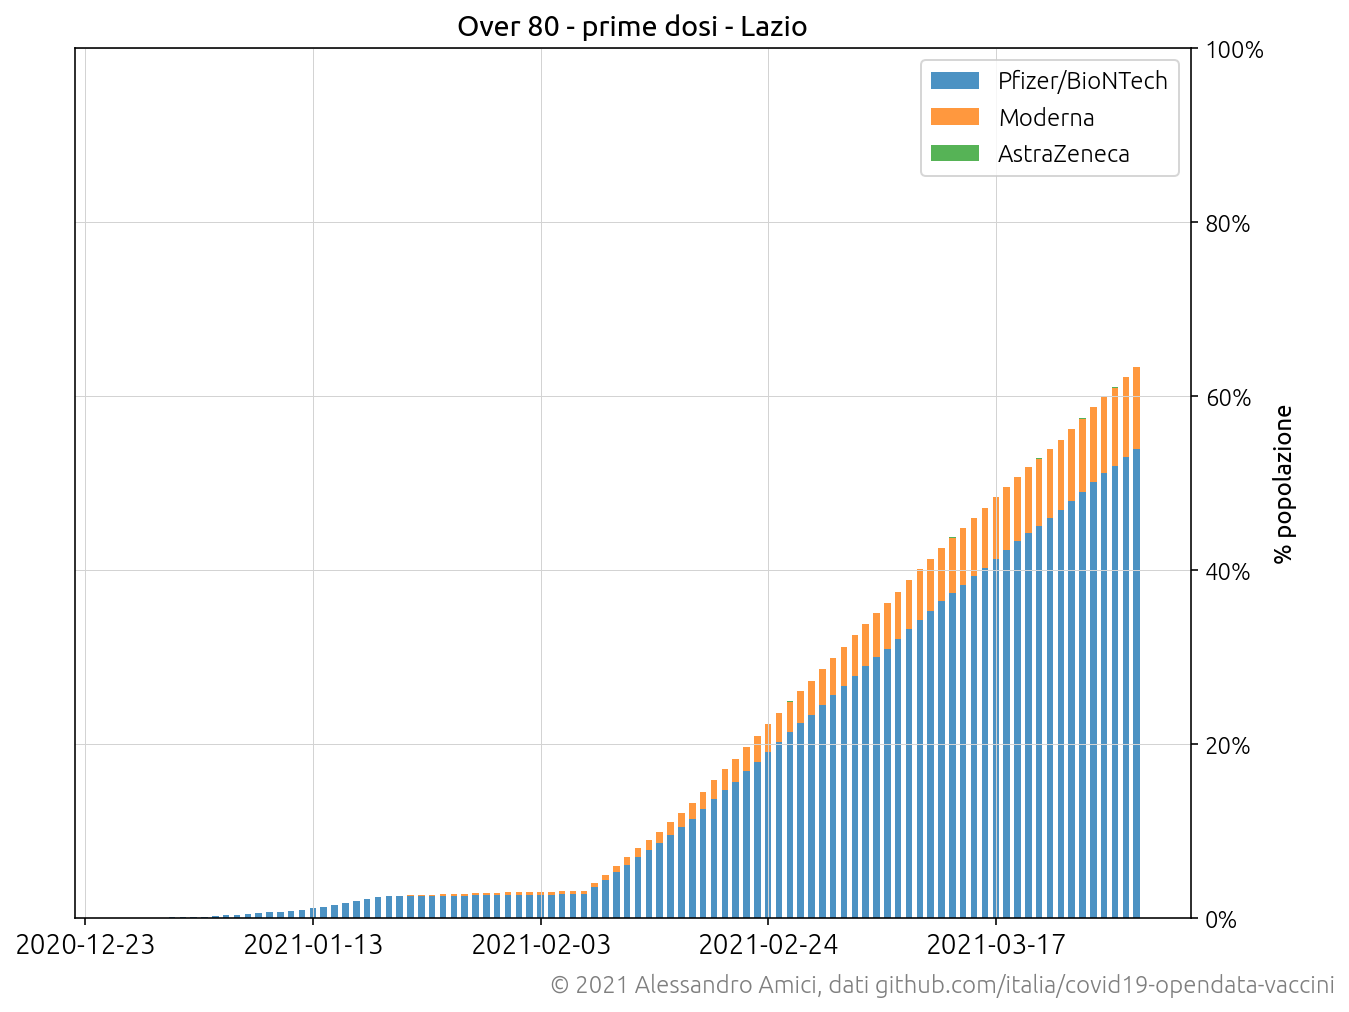

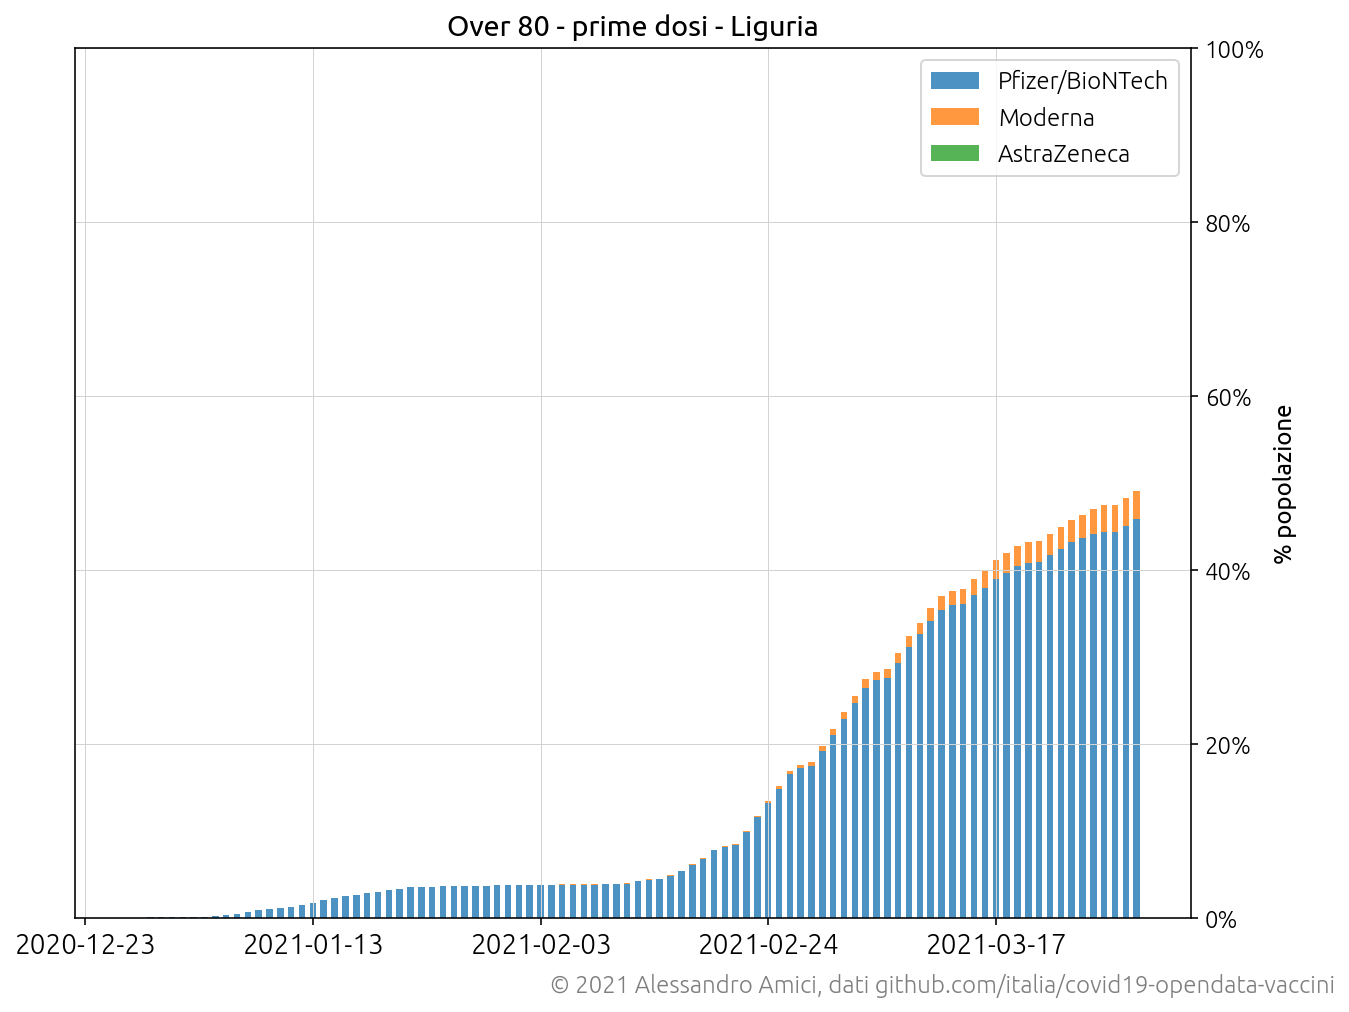

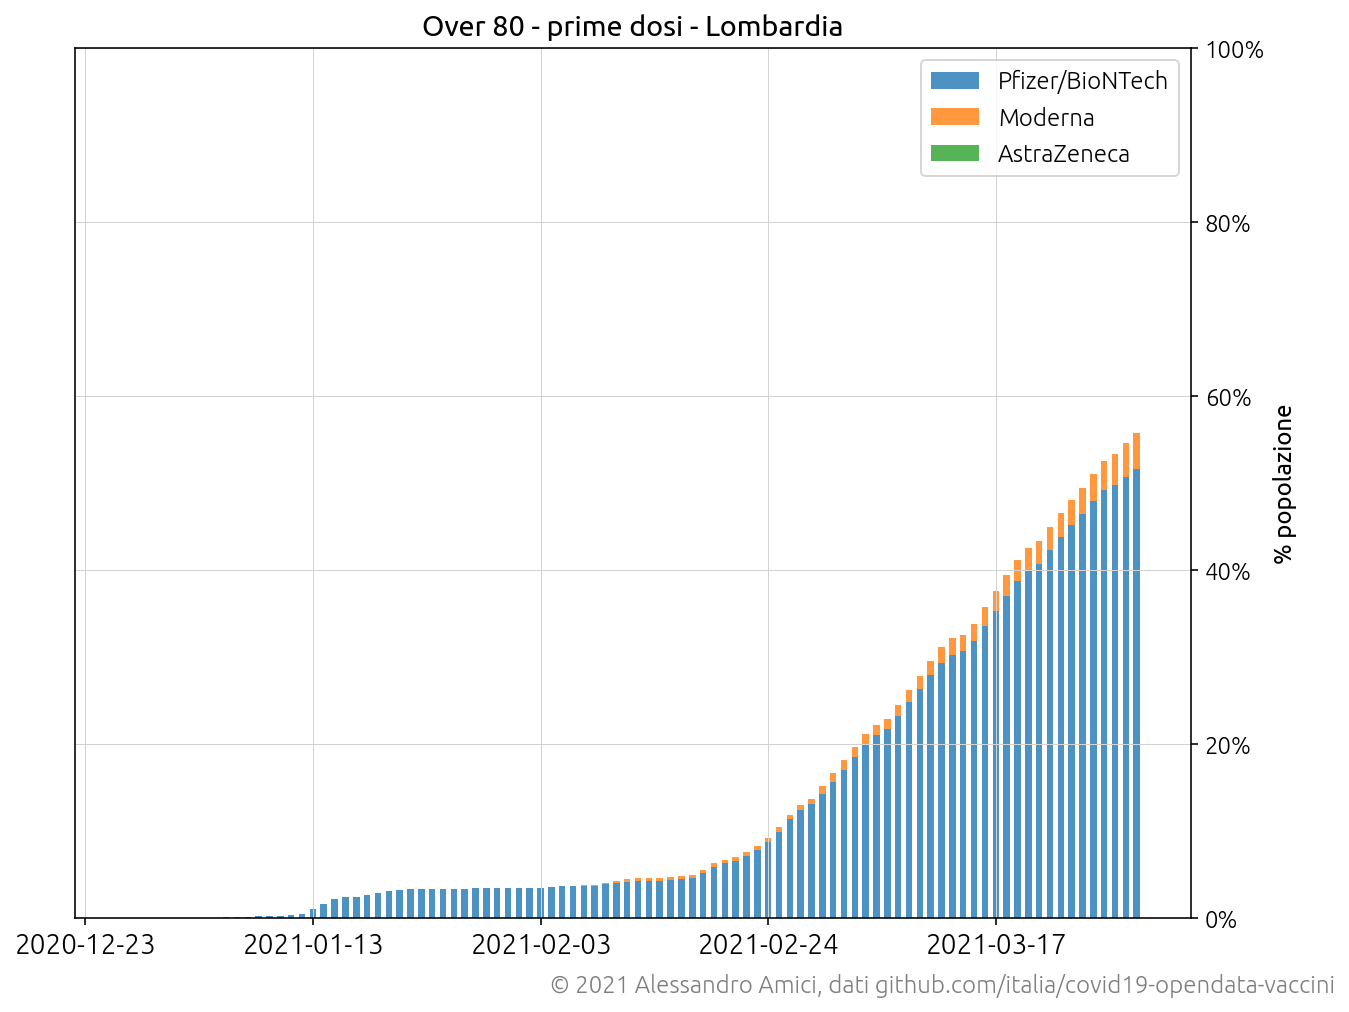

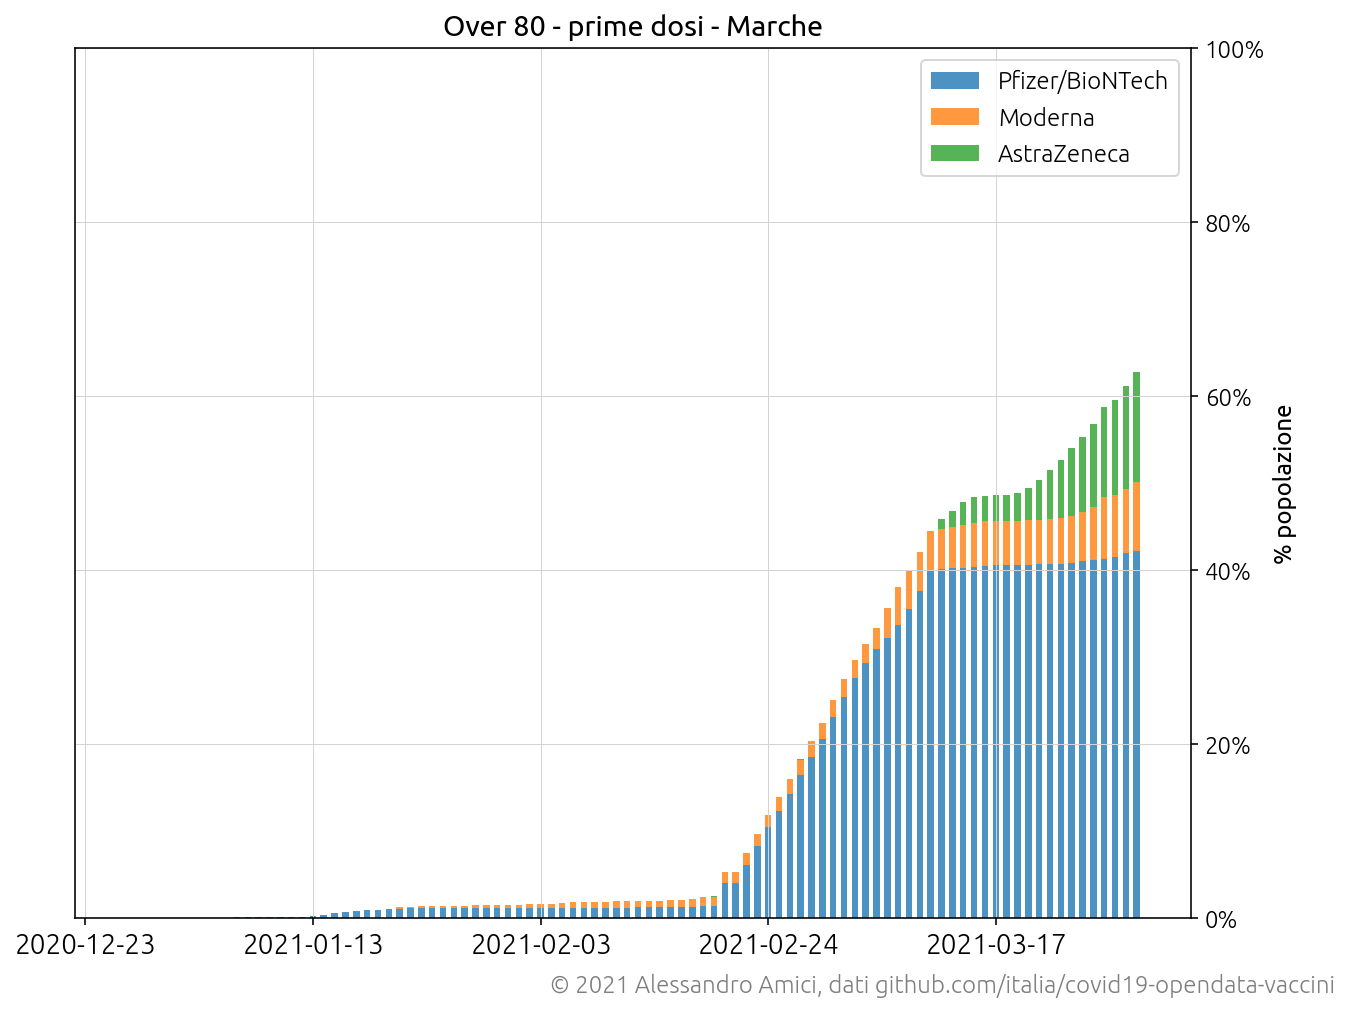

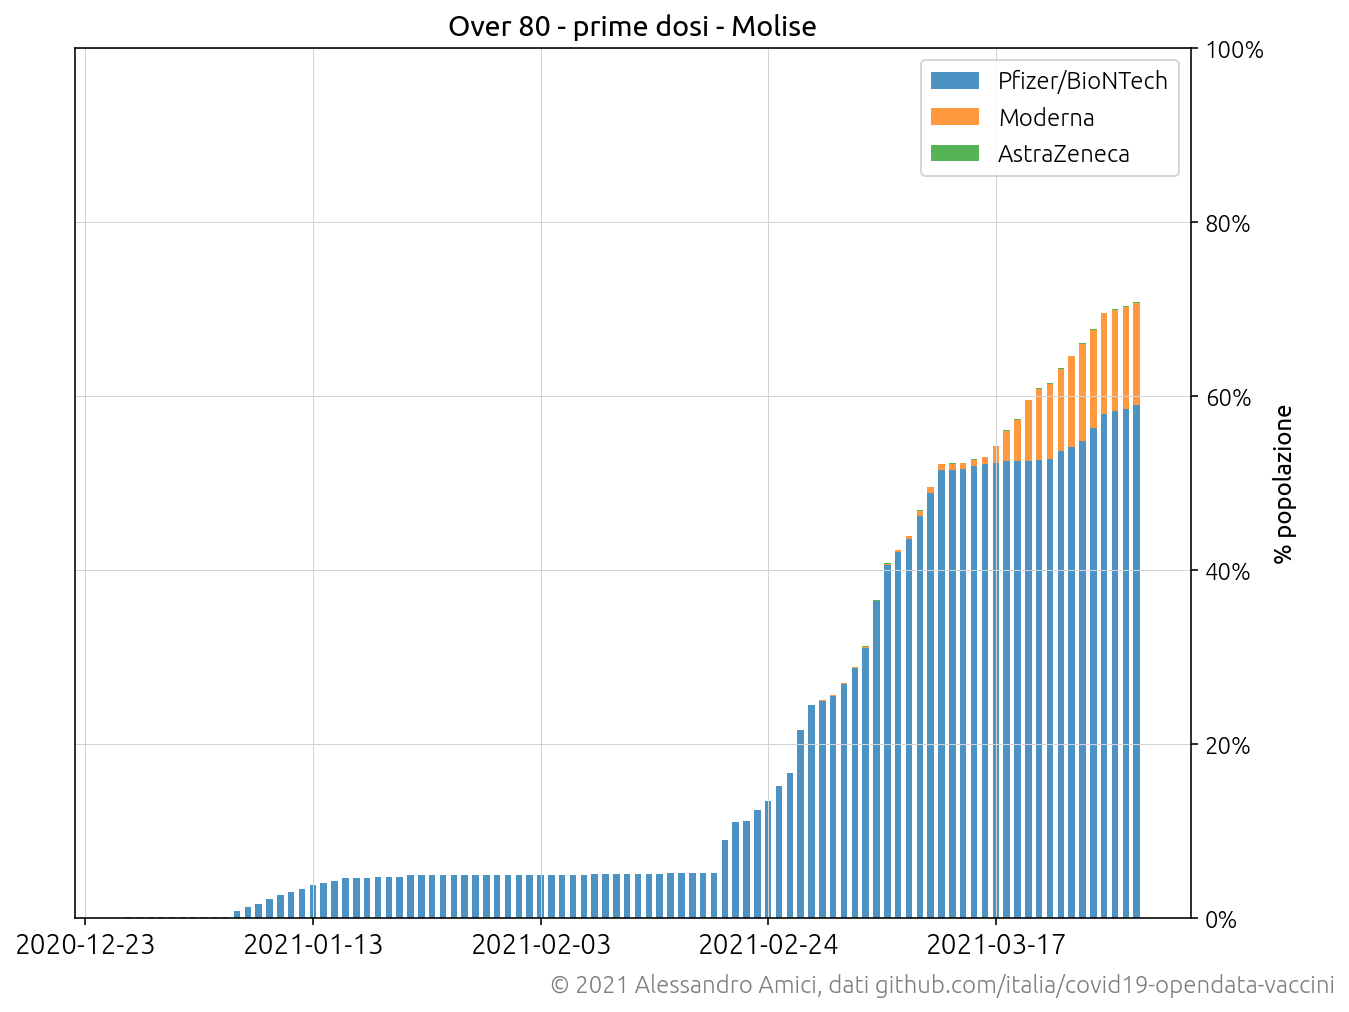

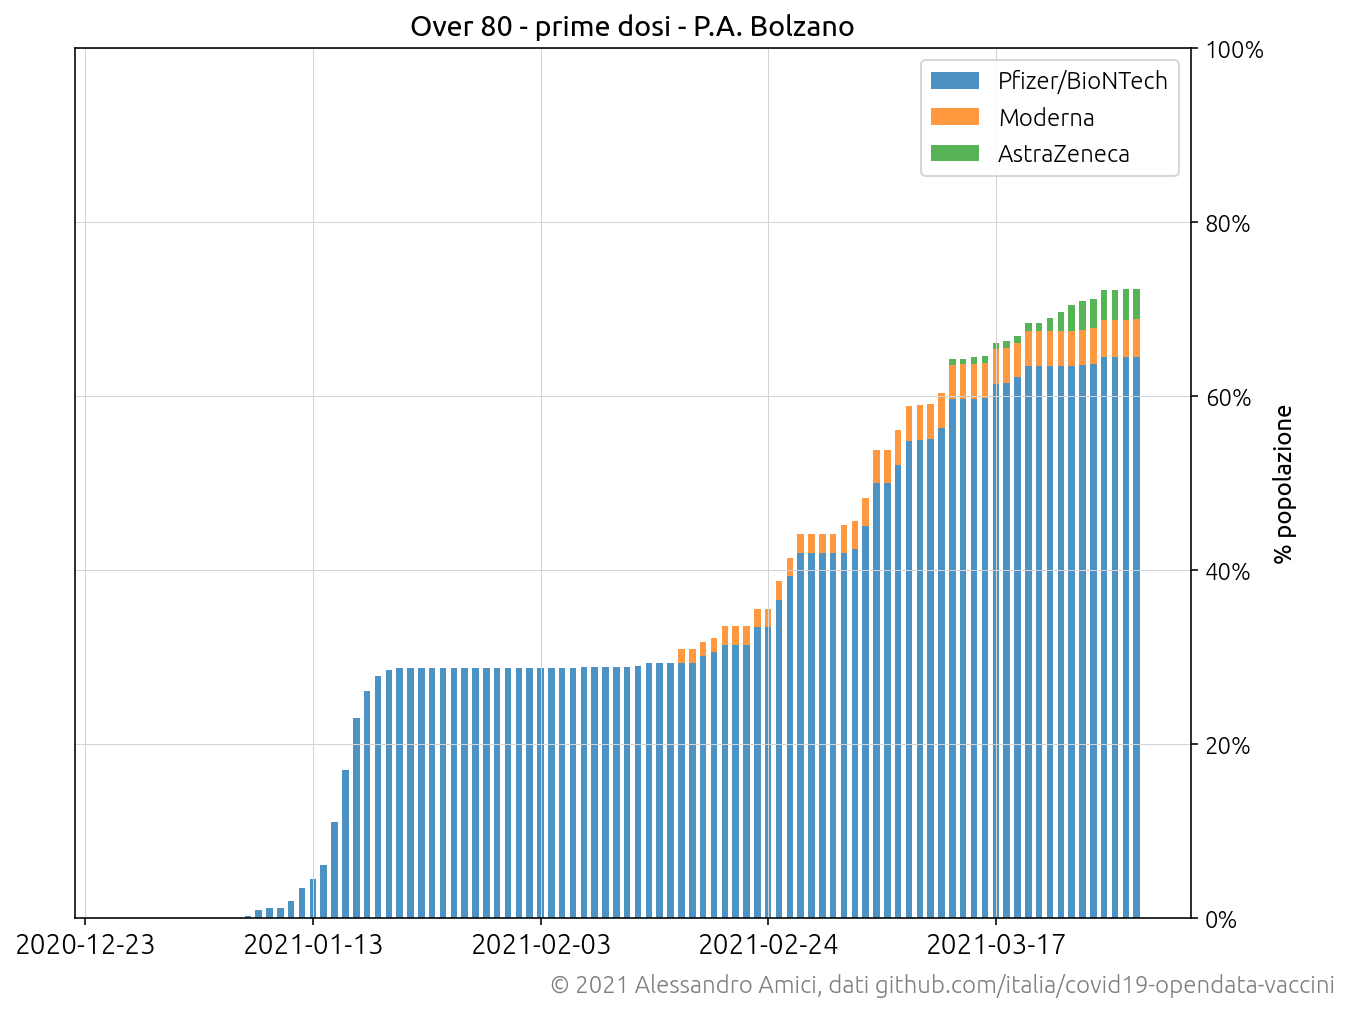

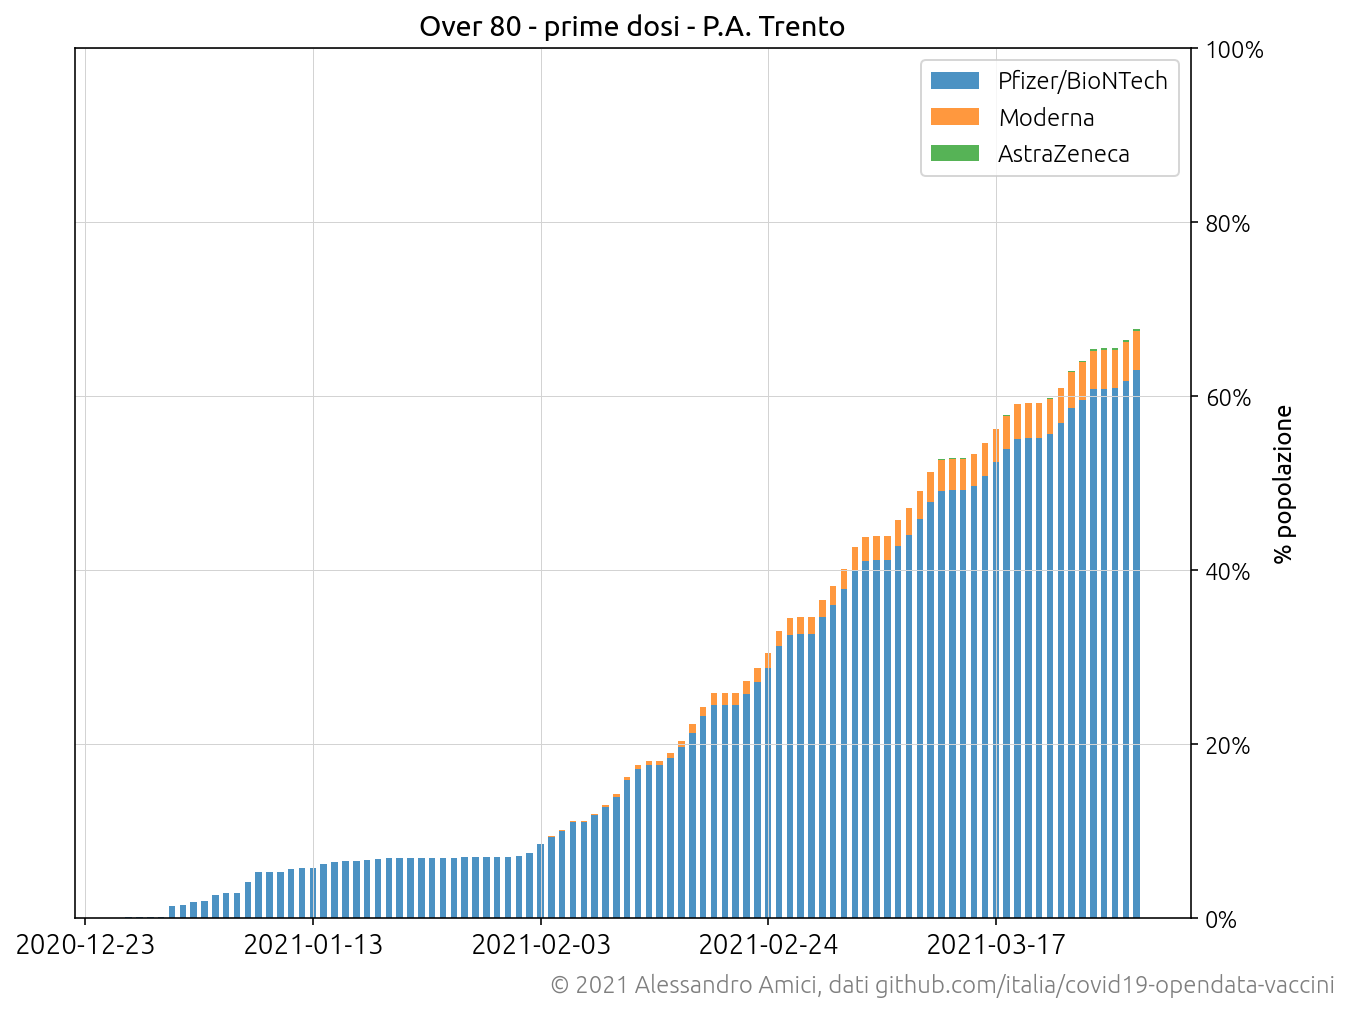

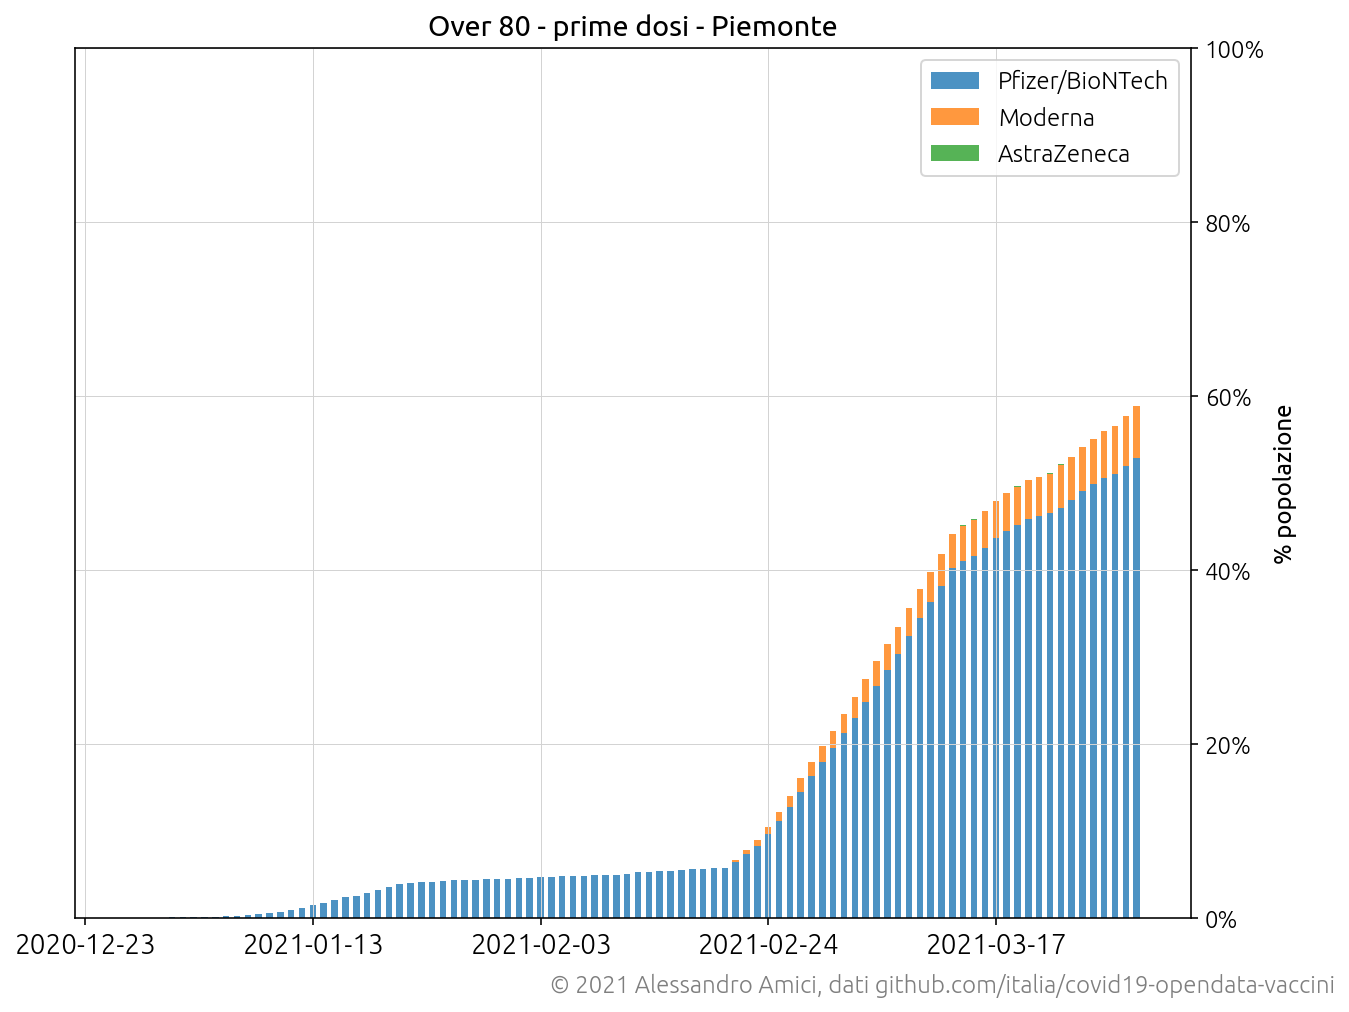

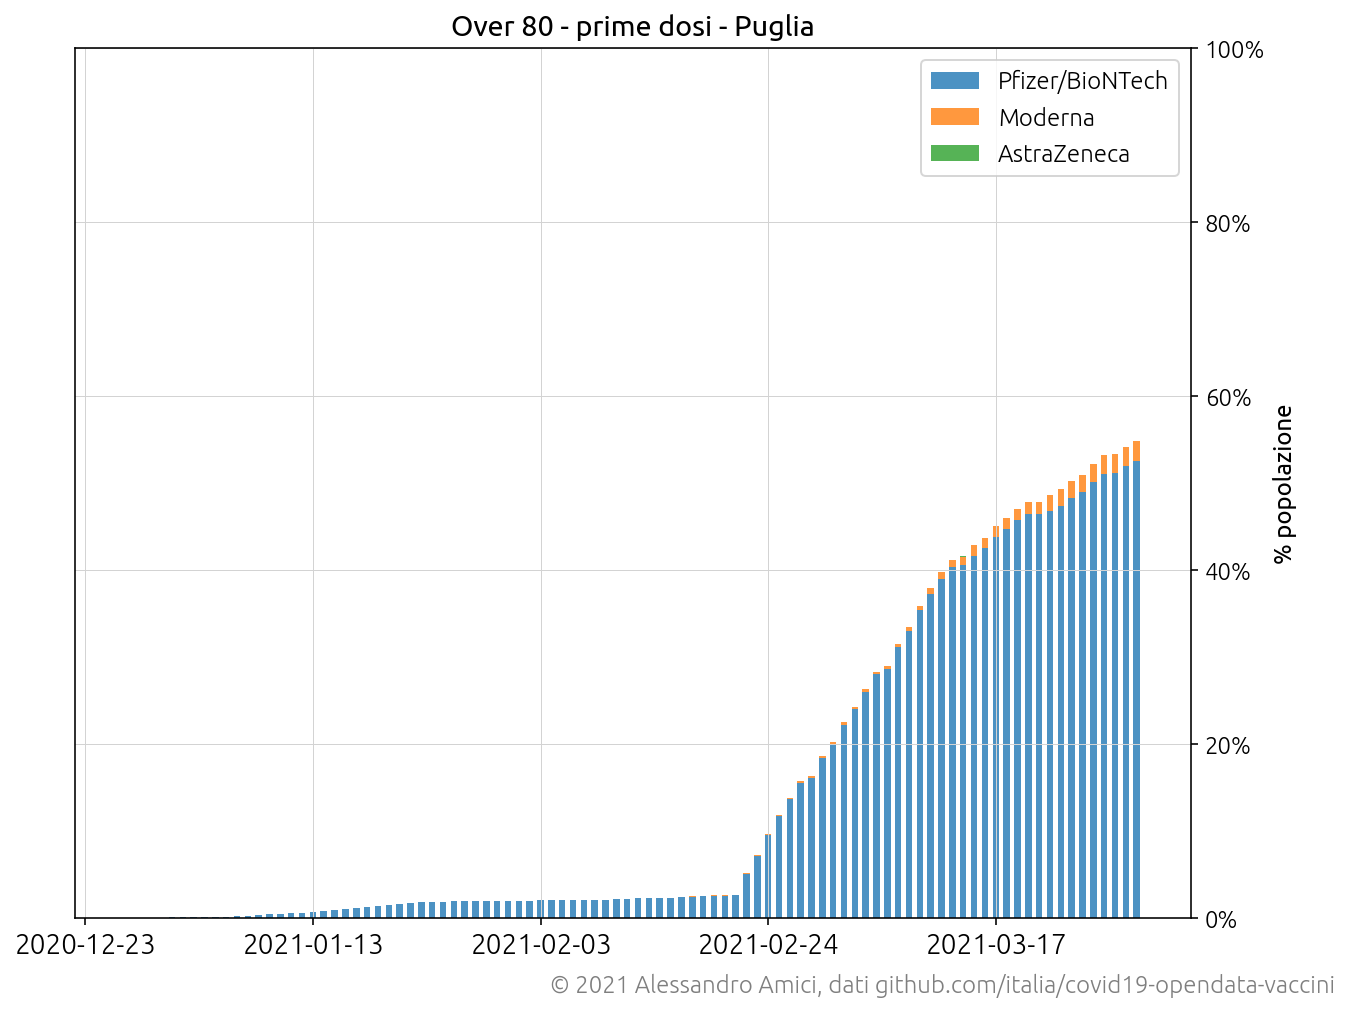

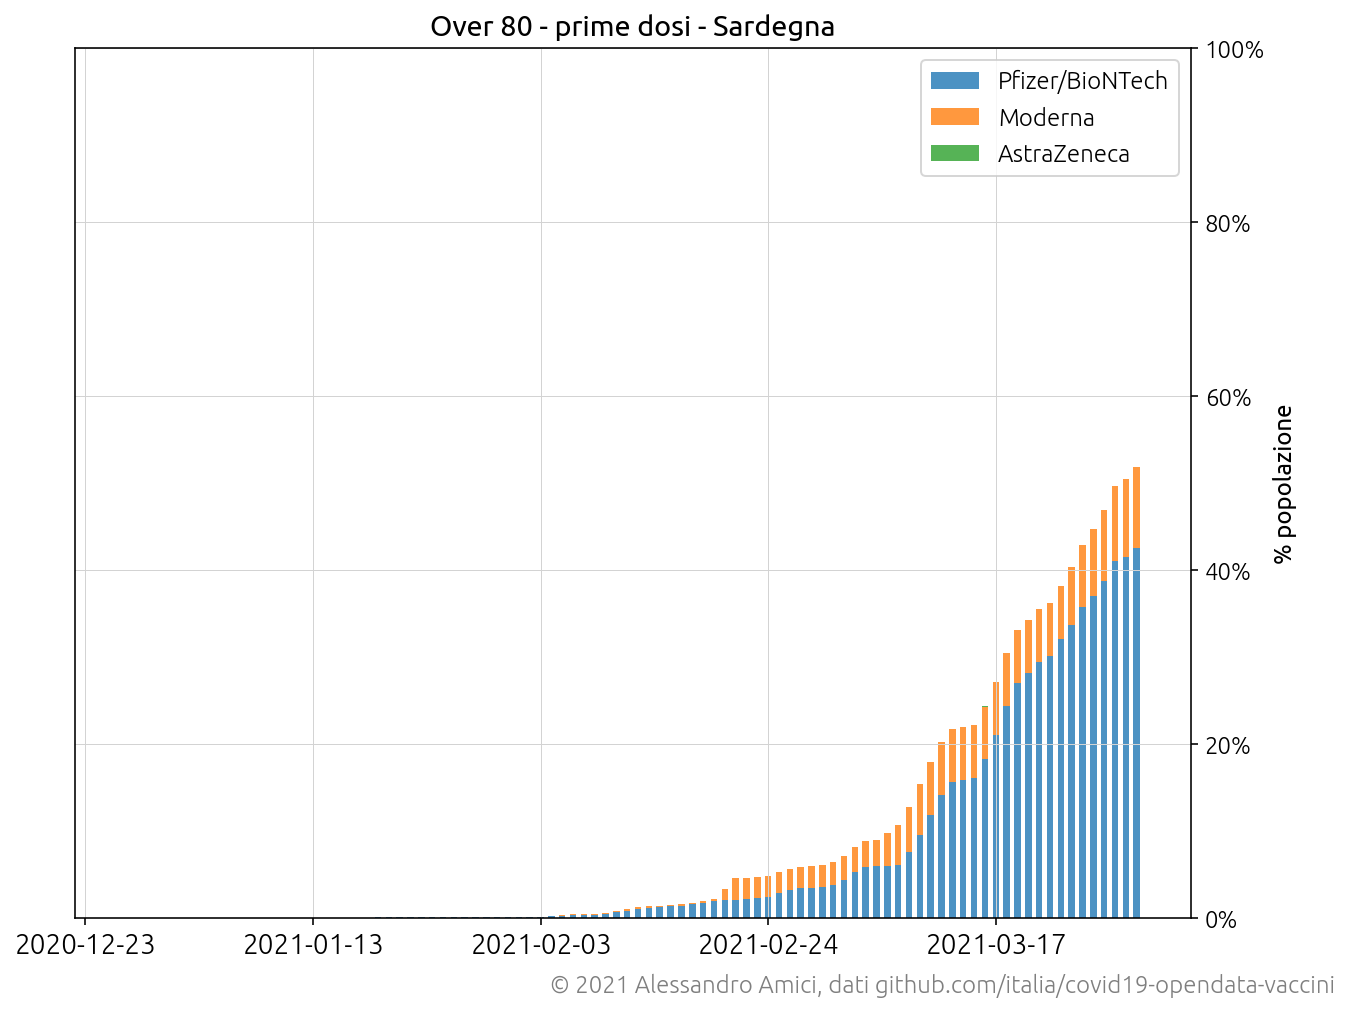

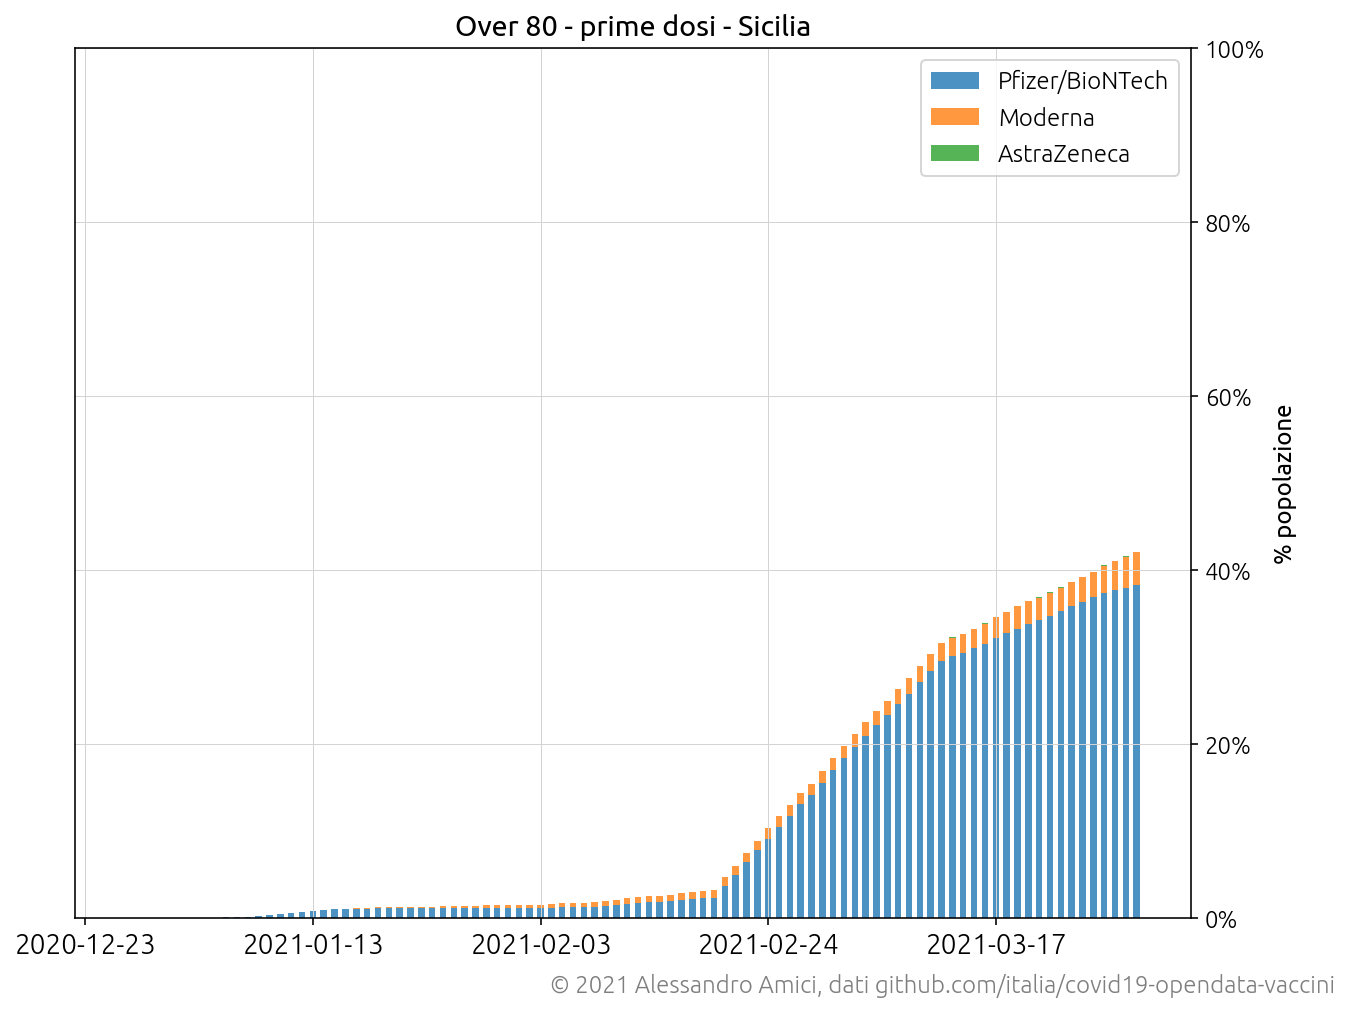

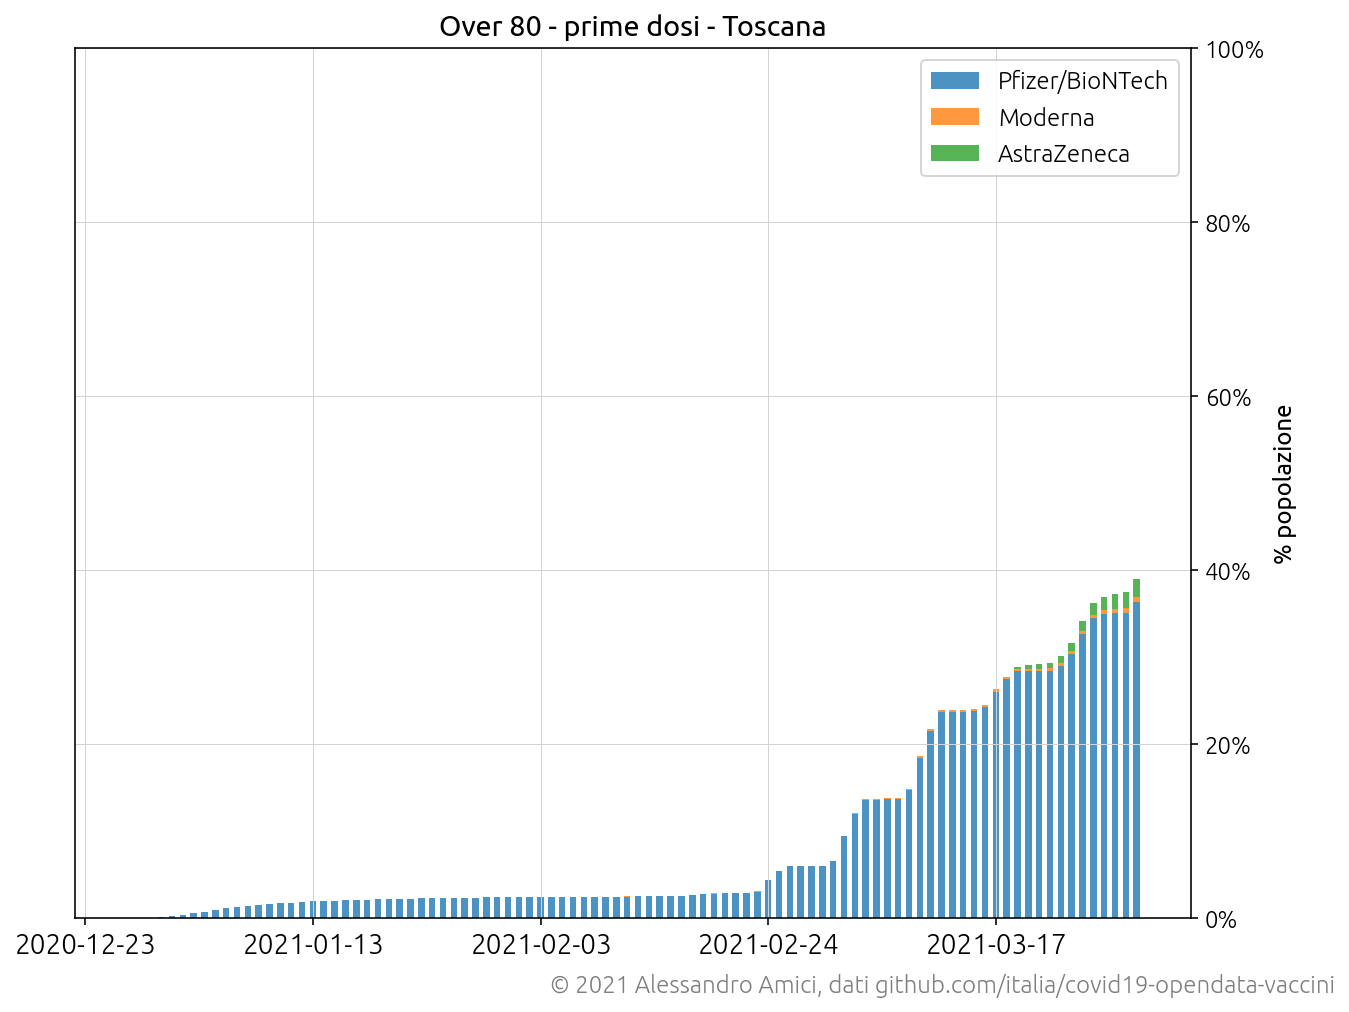

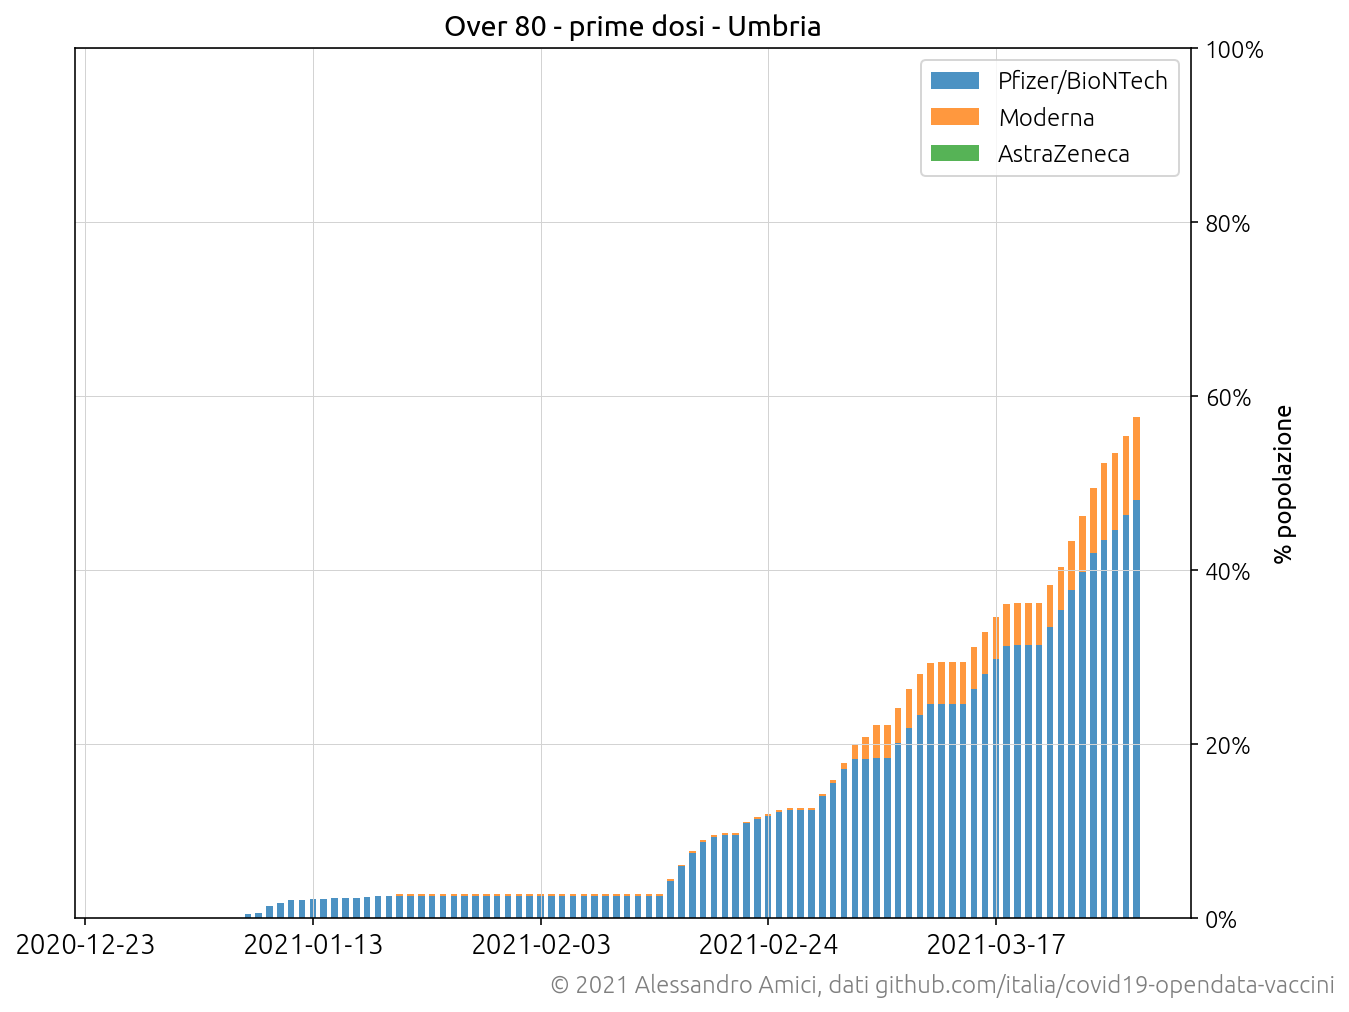

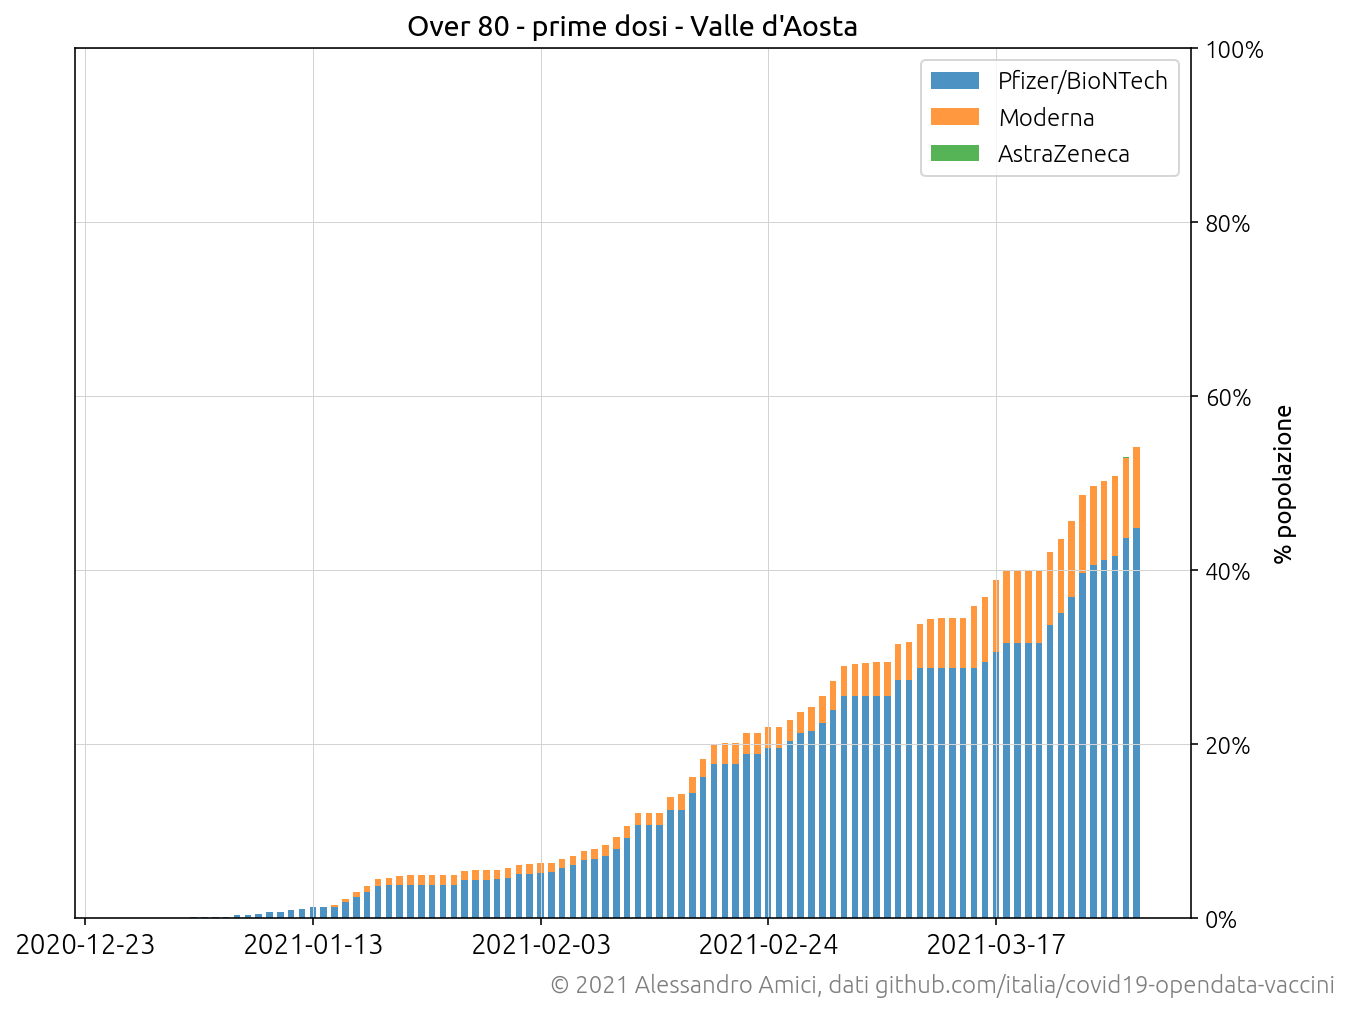

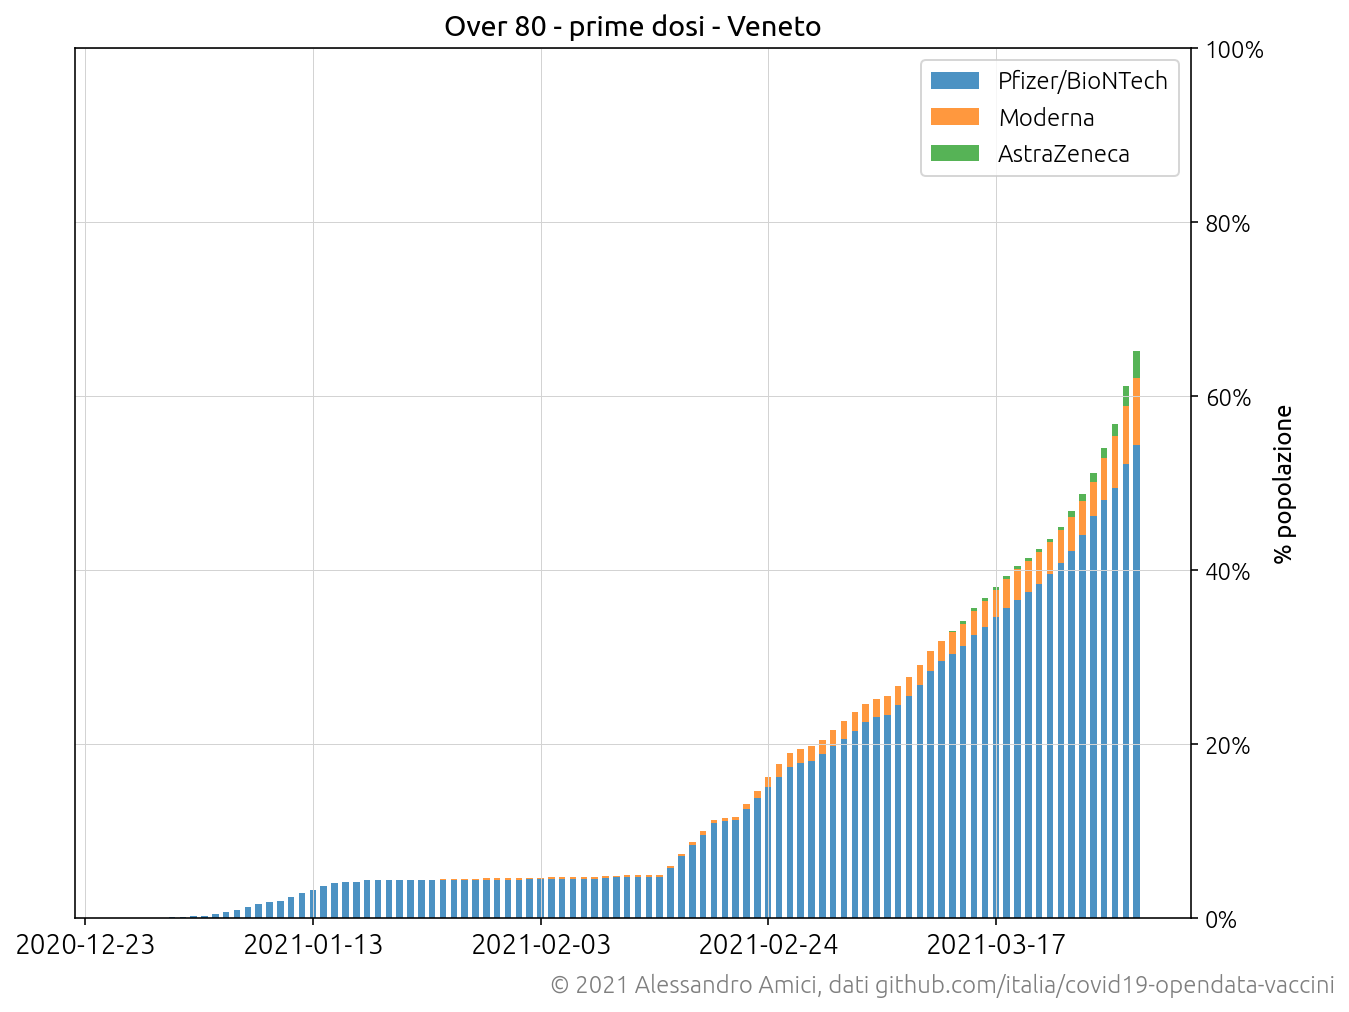

In [1090]:
for location in primers80.location.values:
    fig, ax = covid19.plot.subplots(note=COPYRIGHT)
    covid19.plot.stack_xarray(primers80_pm.sel(location=location).cumsum("time"), hue="provider", window=7, title=f"Over 80 - prime dosi - {location}", ylim=(0, 1), ax=ax)
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1, 0))
    ax.set(ylabel="% popolazione")
    ax.legend()

../covid19/plot.py:196: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(*args, **kwargs)


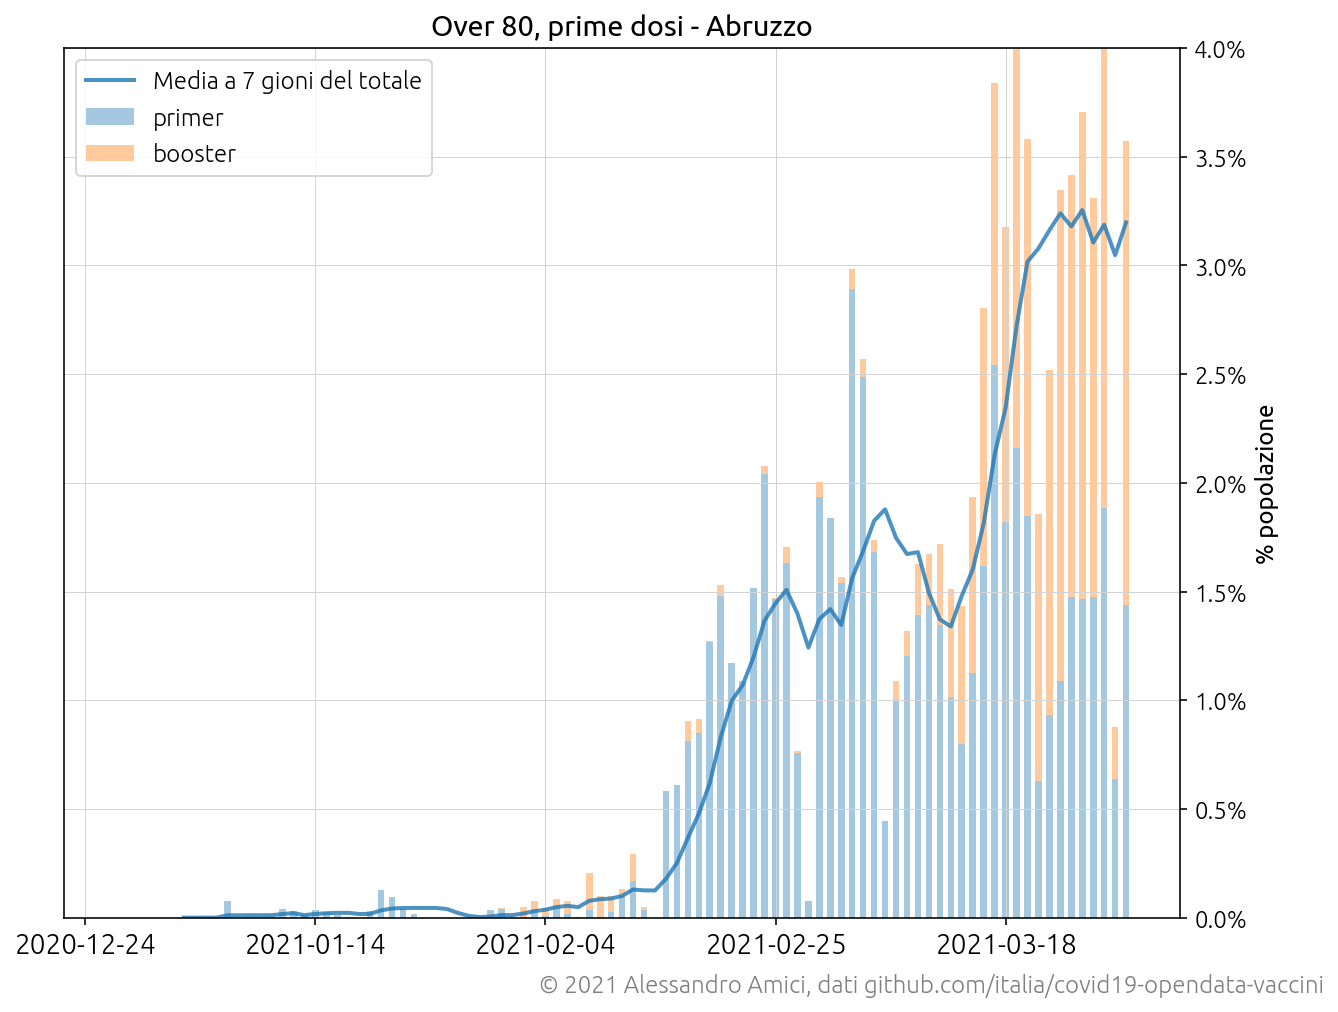

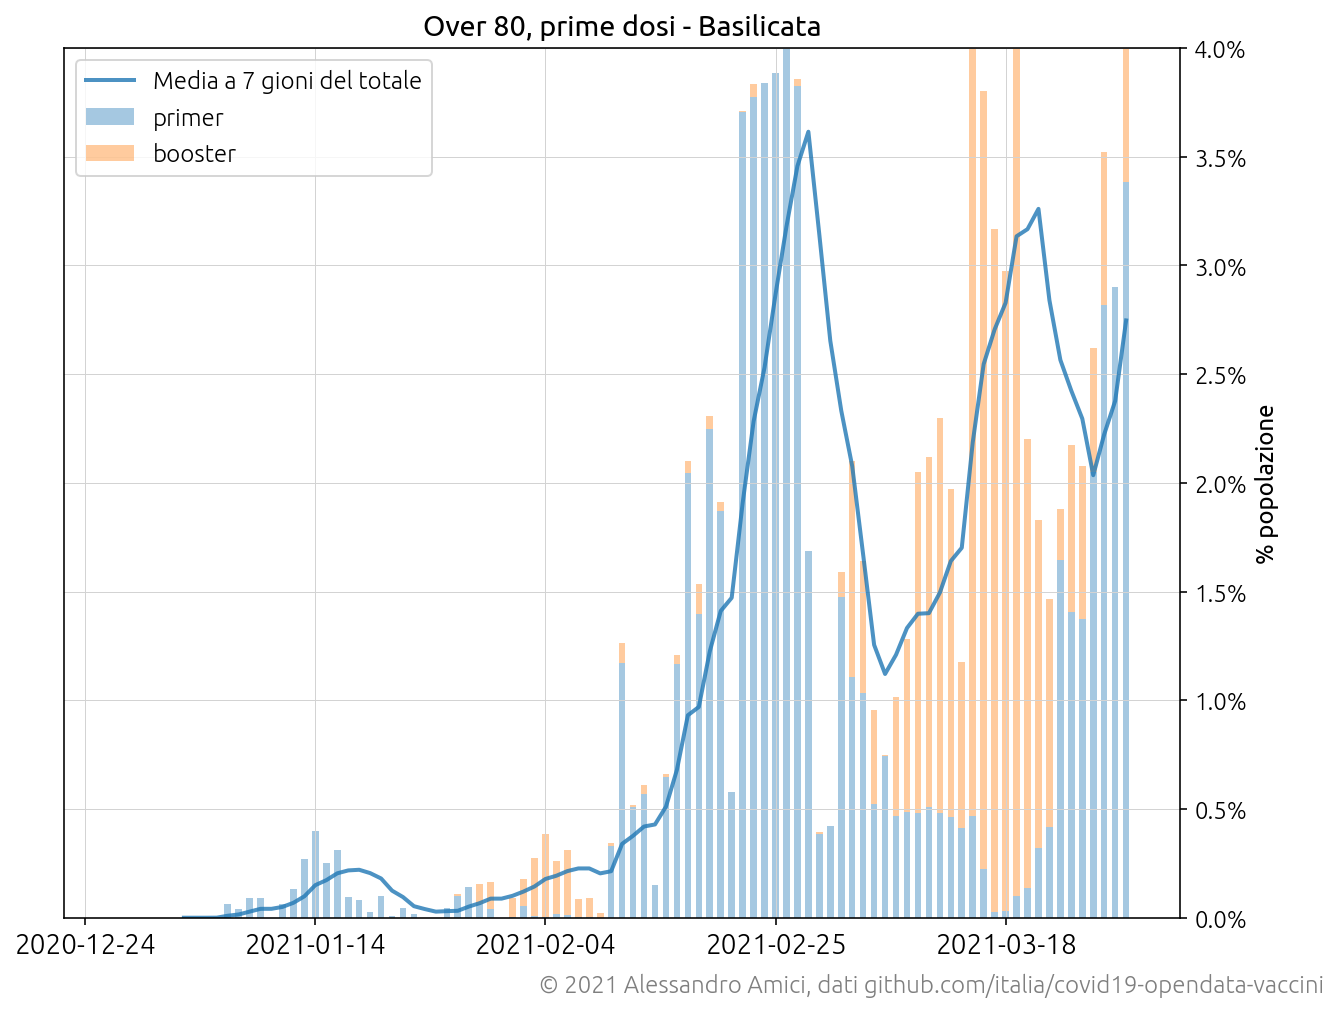

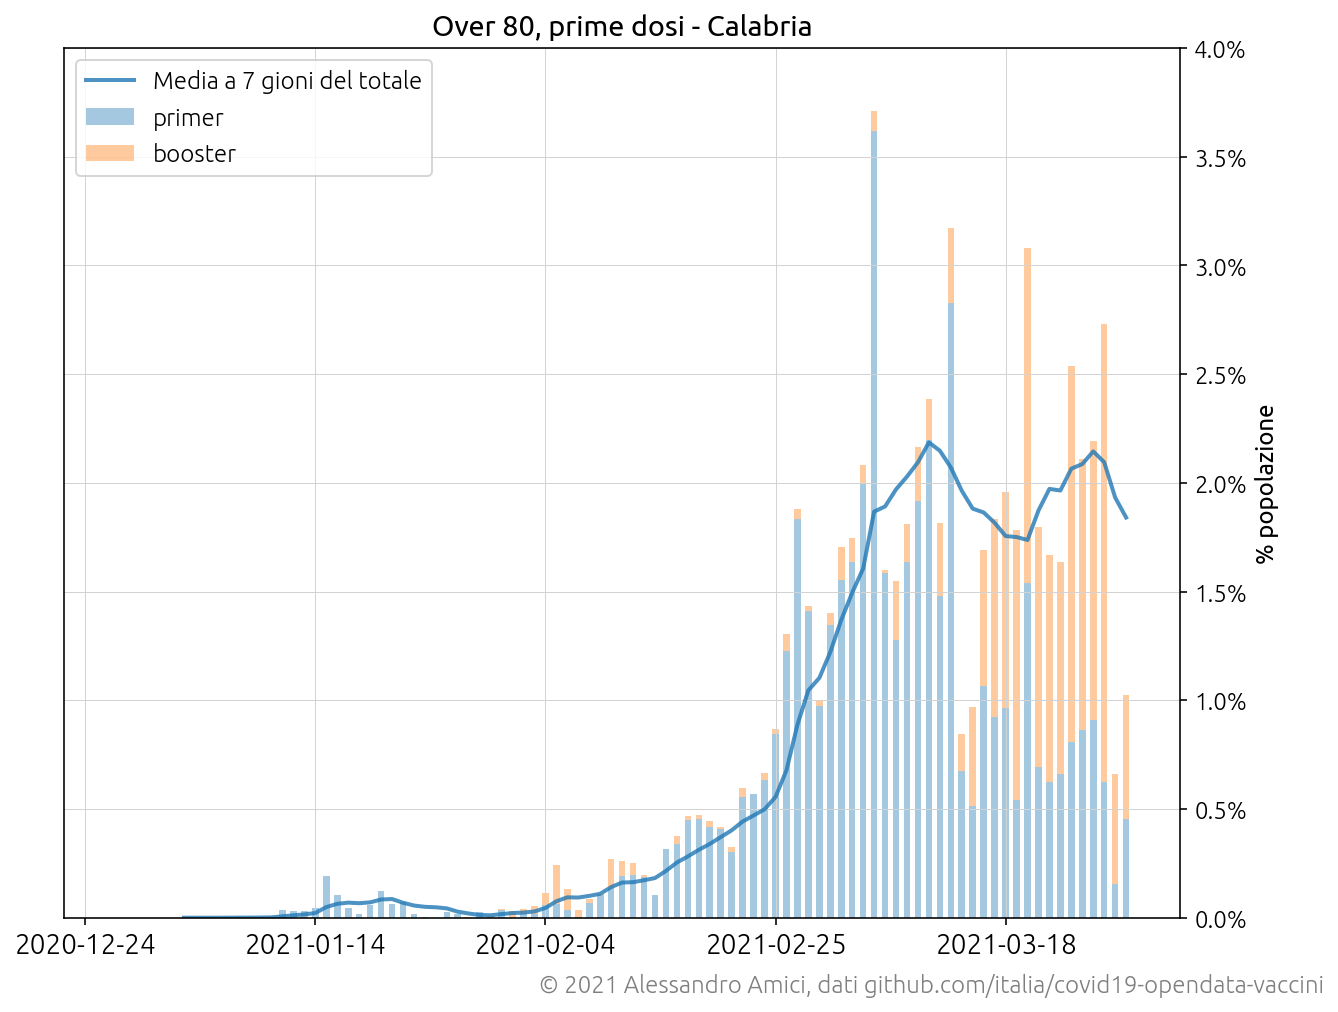

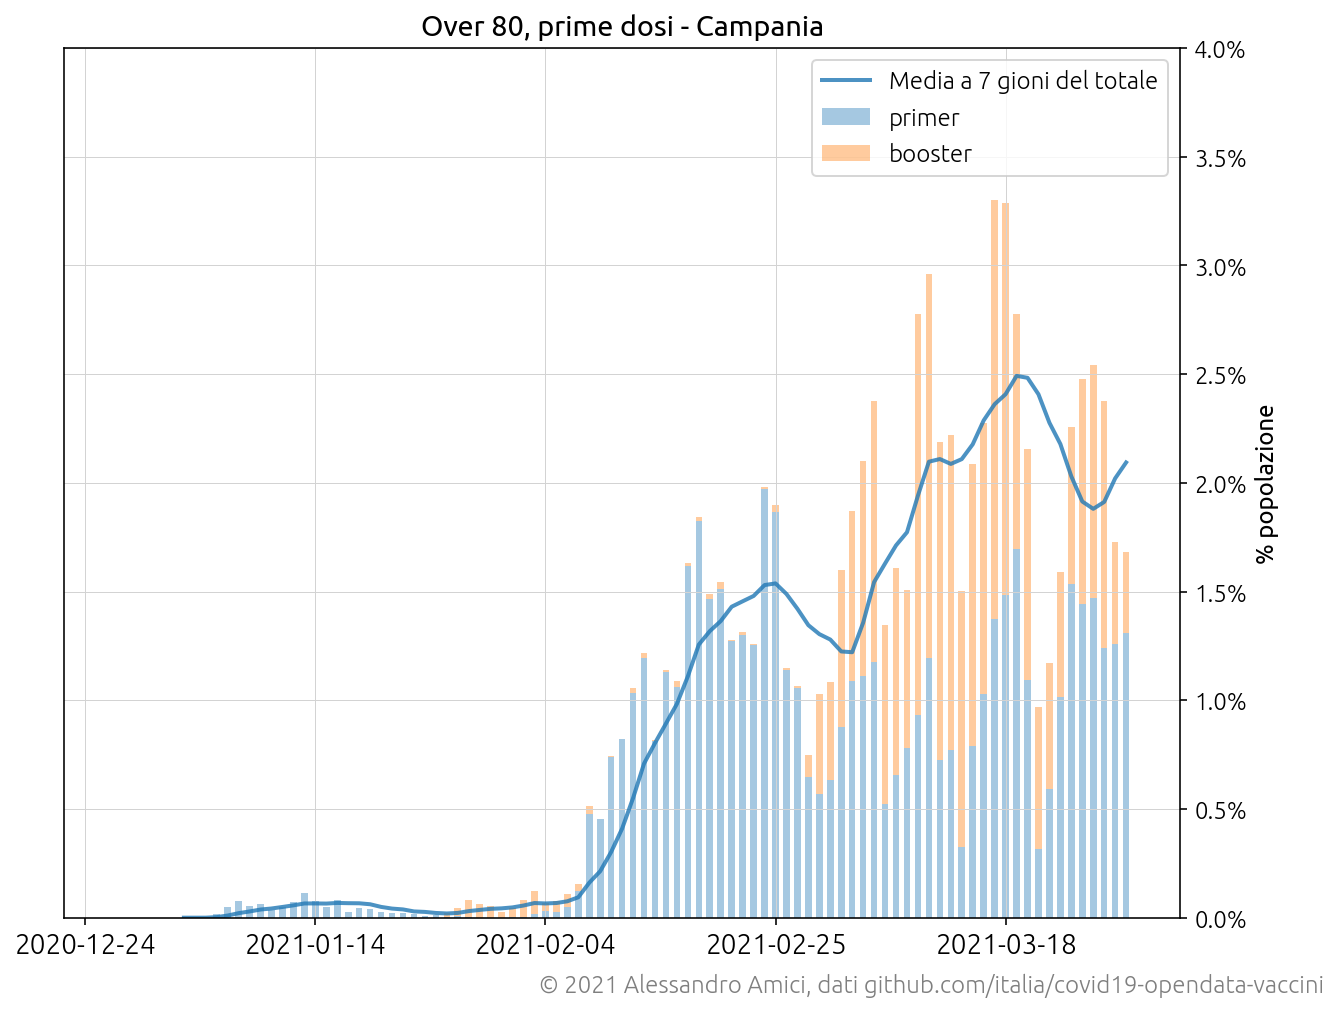

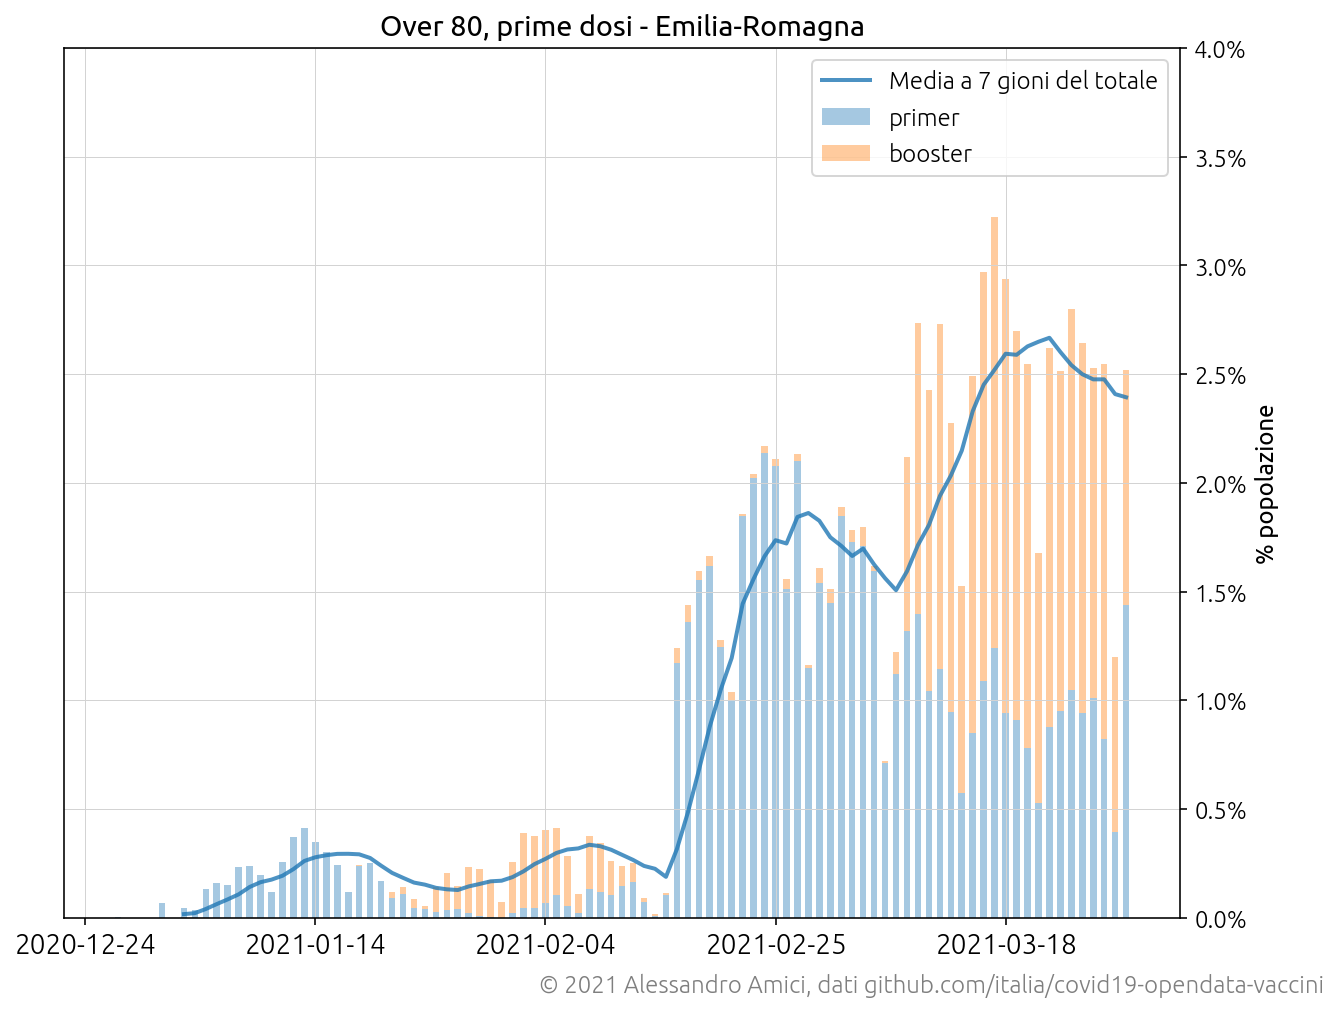

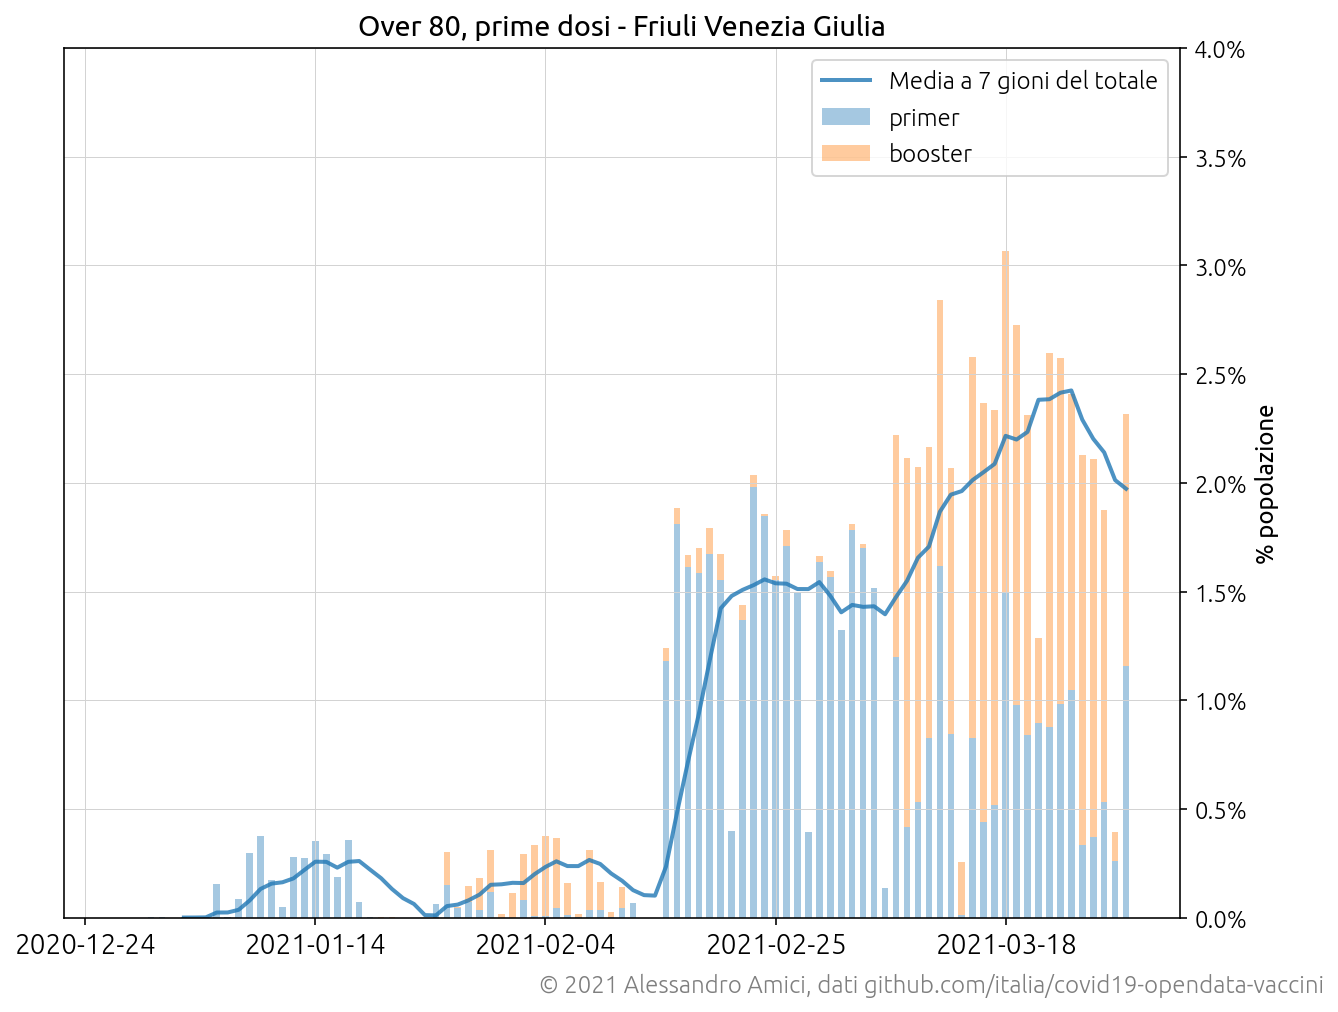

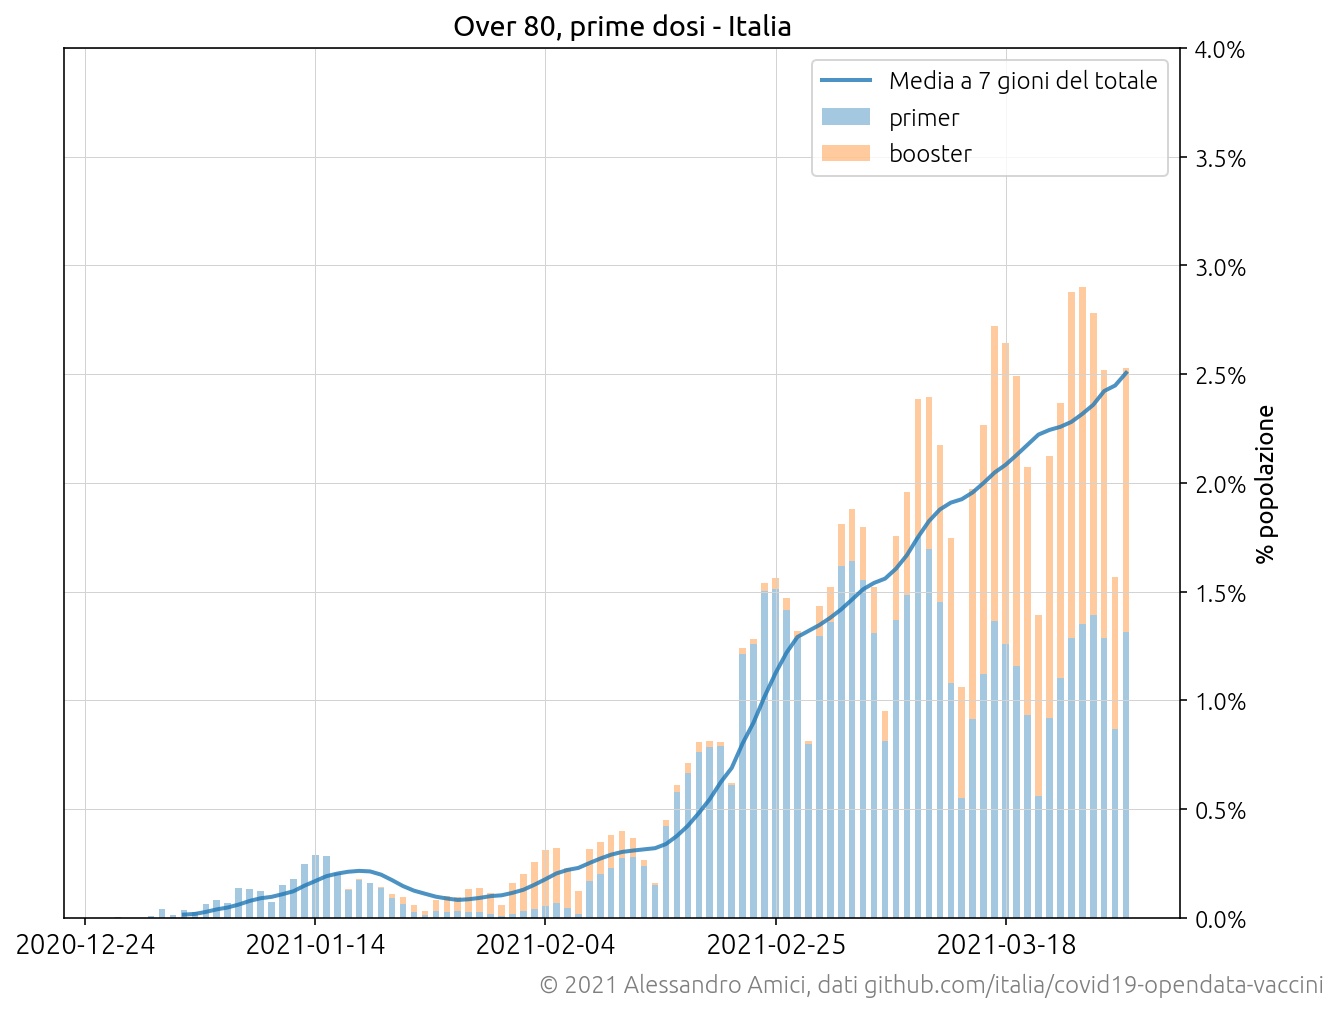

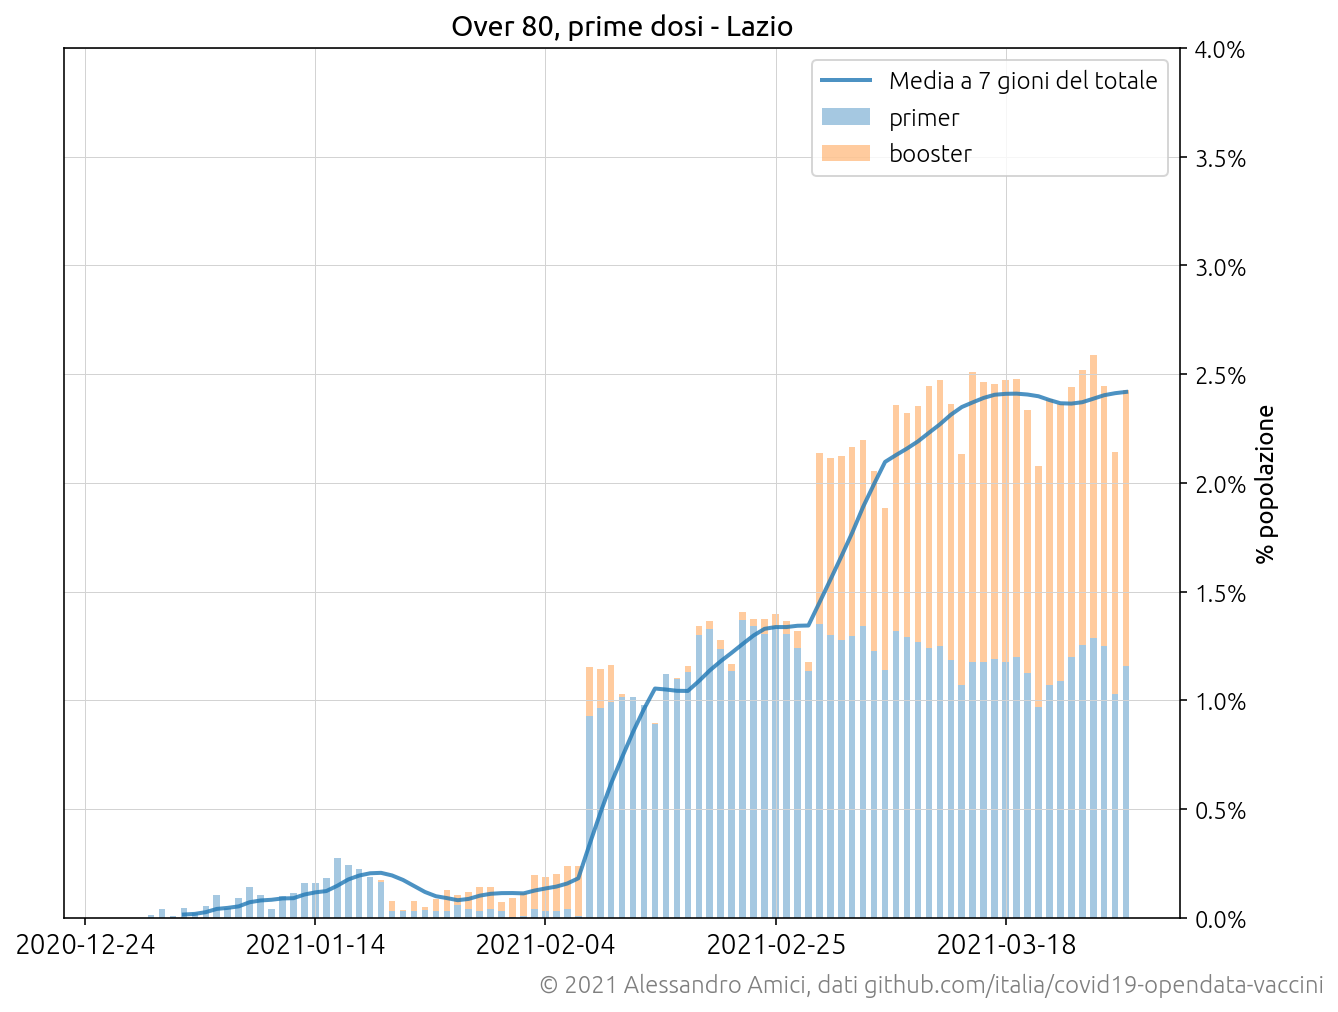

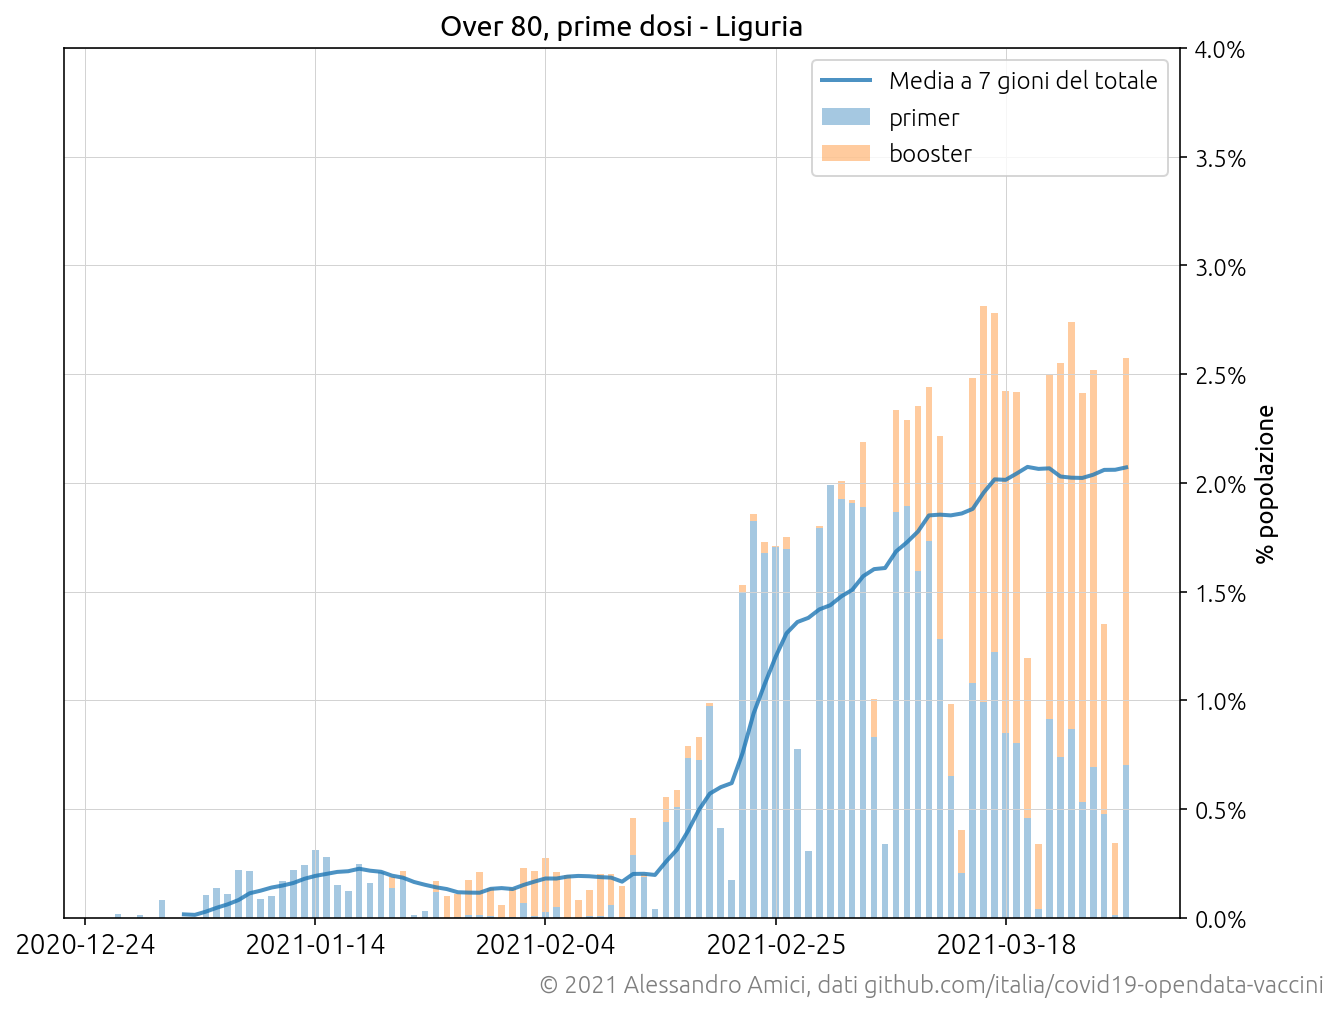

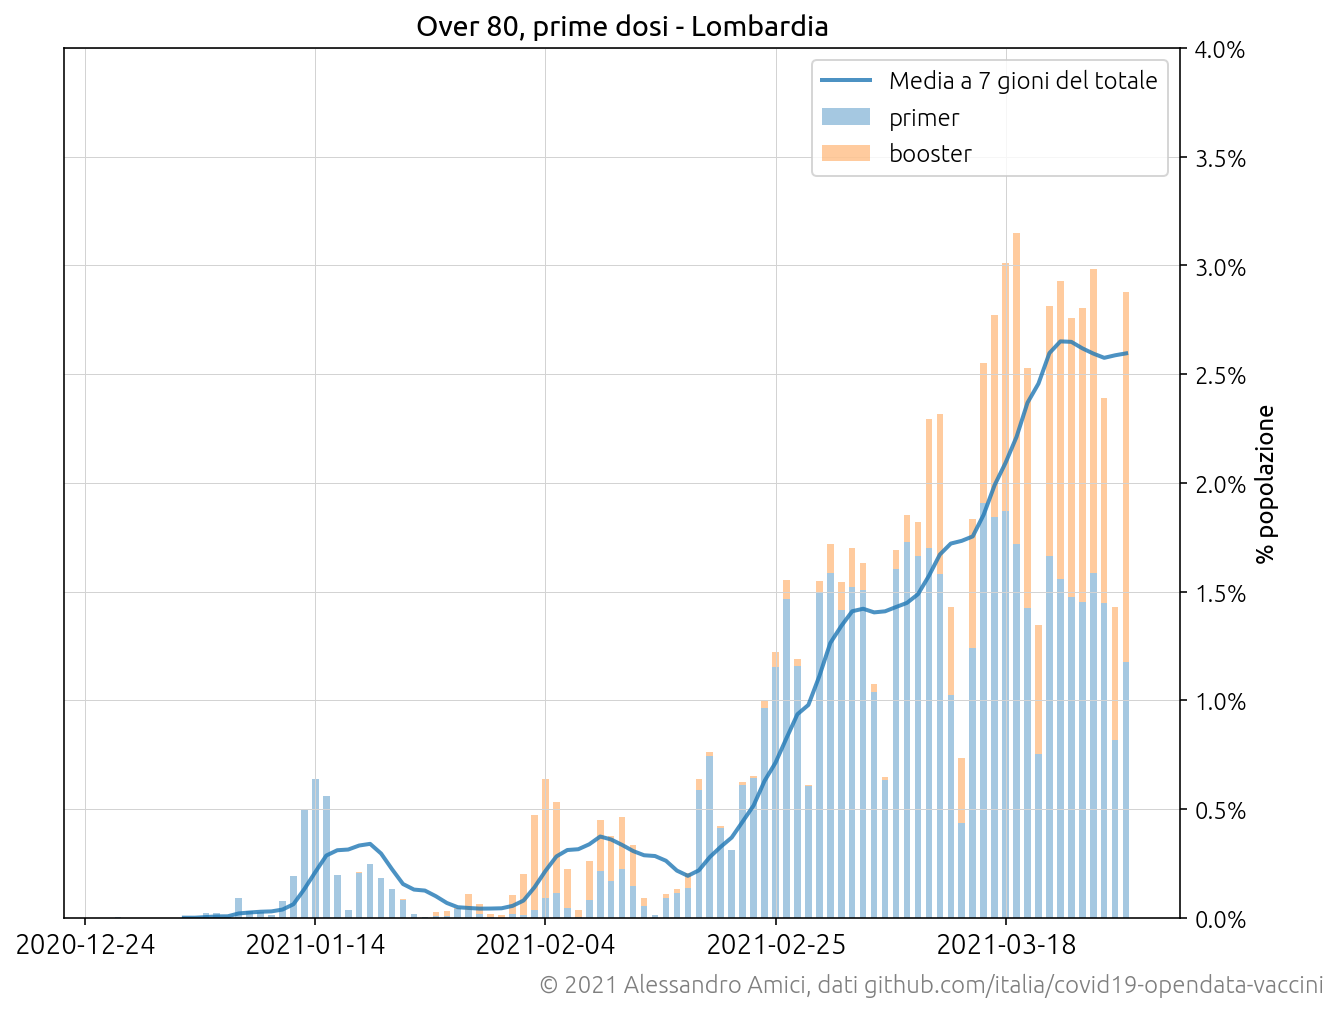

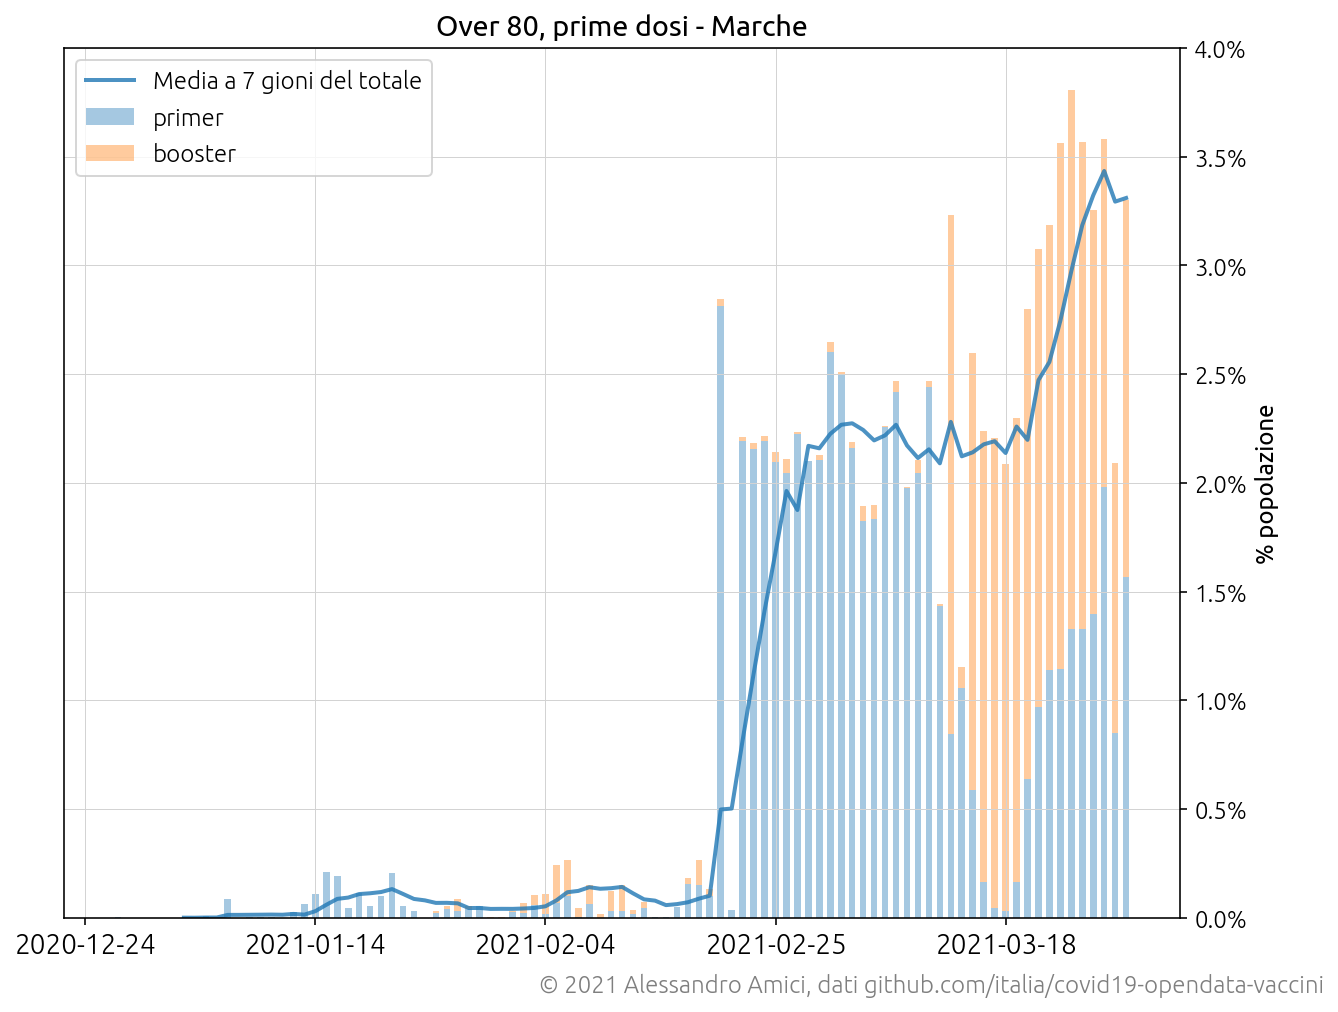

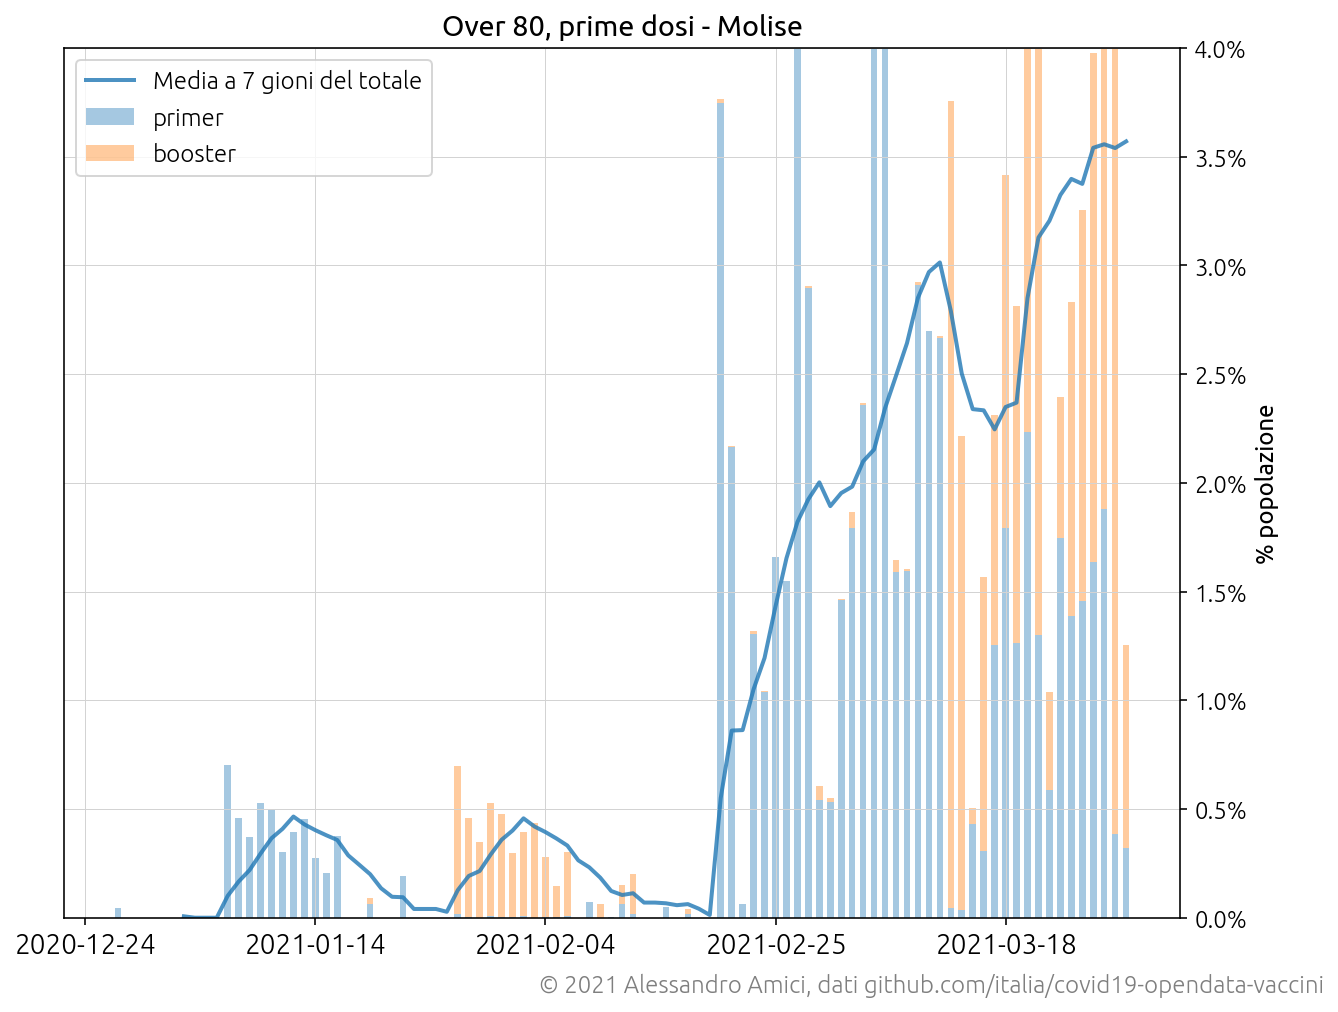

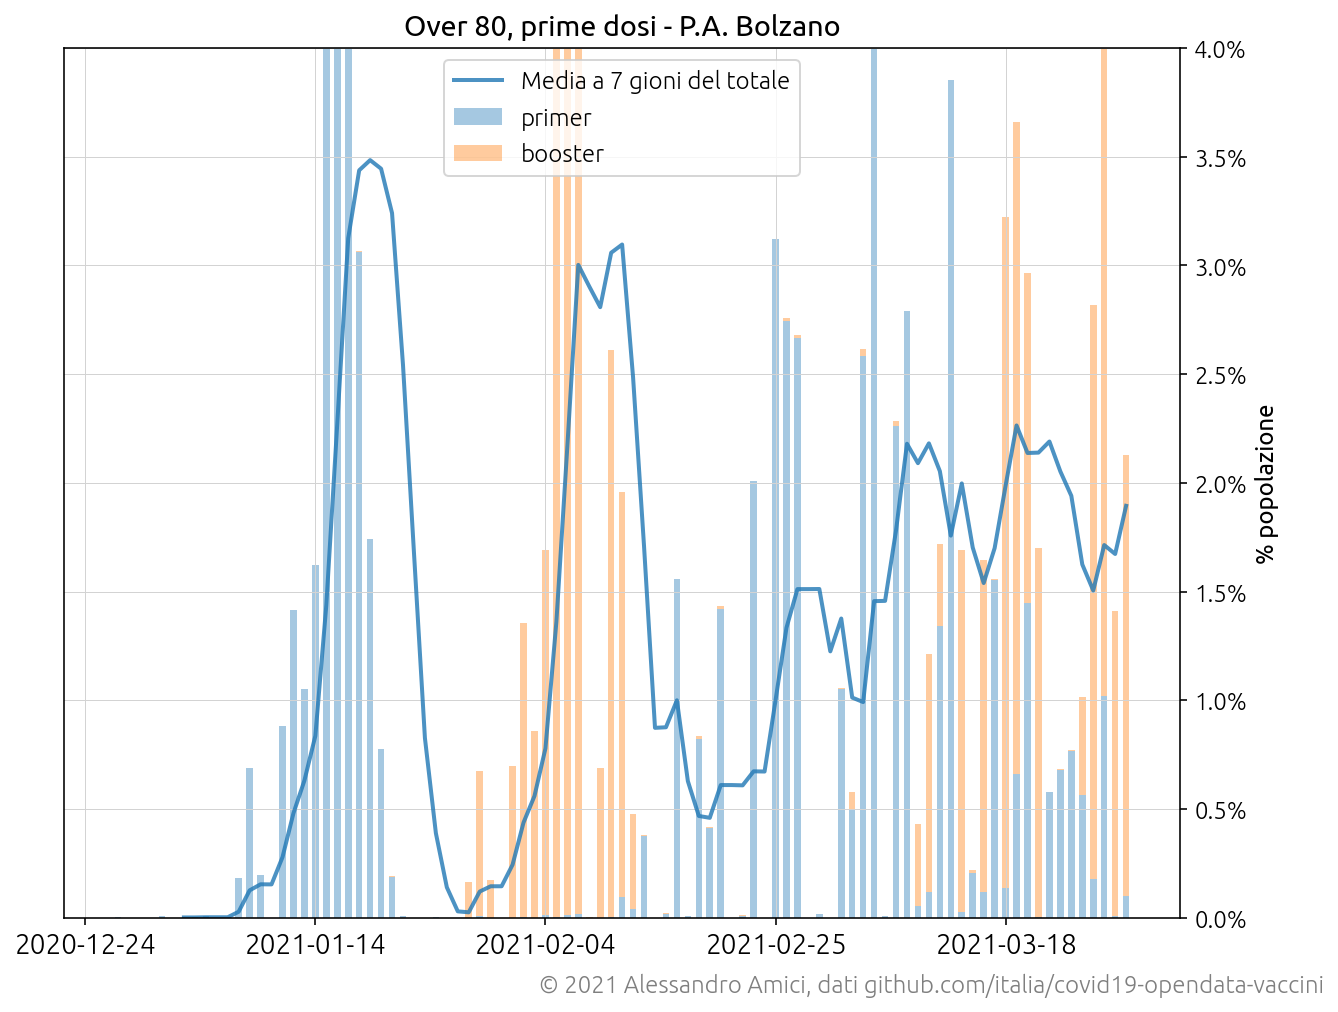

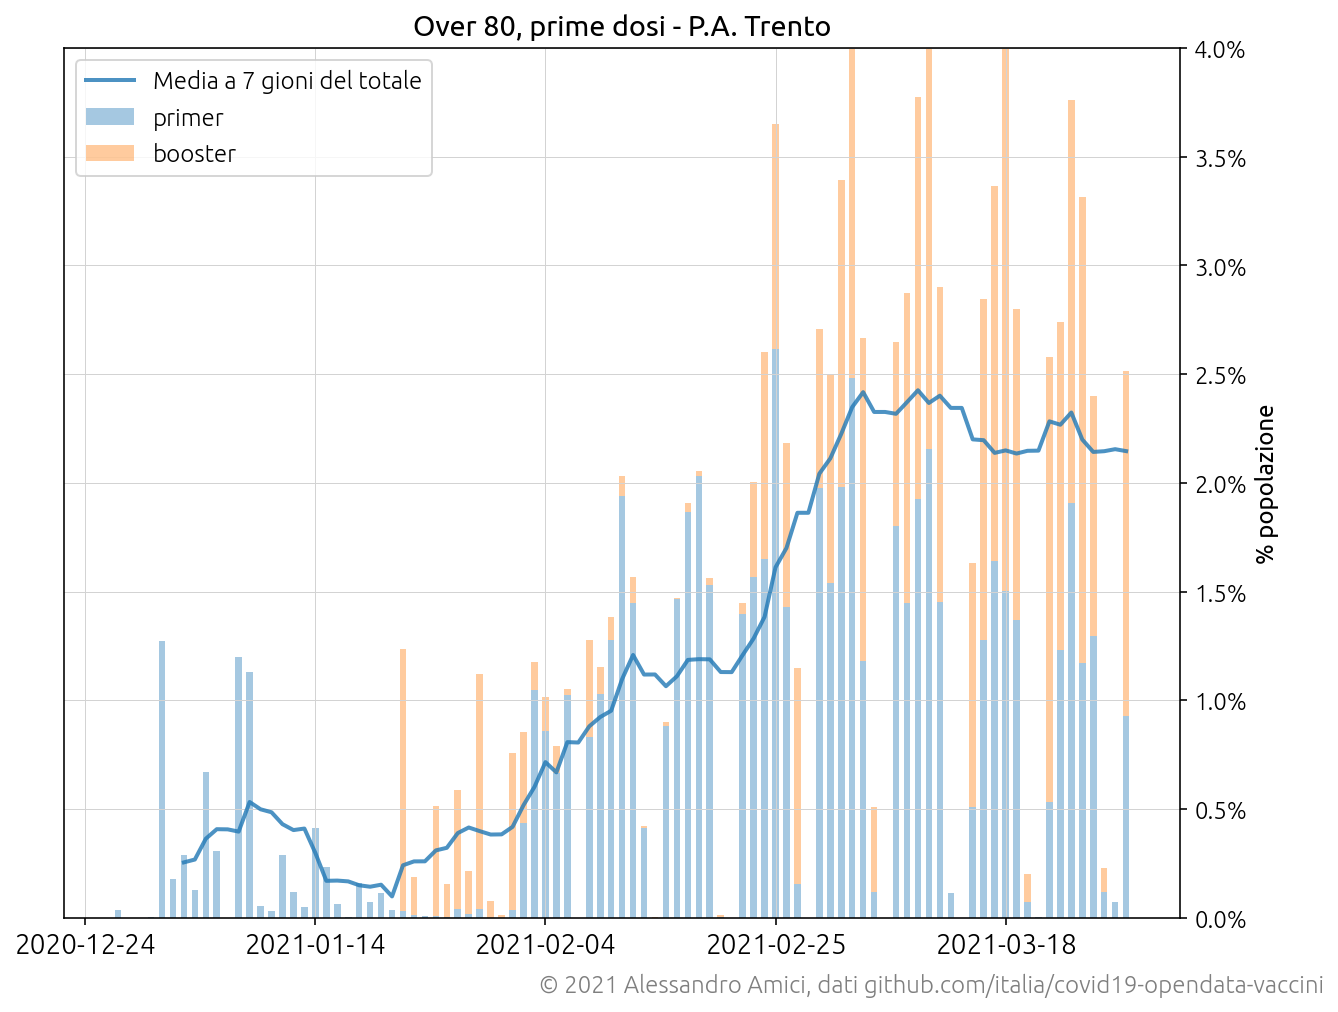

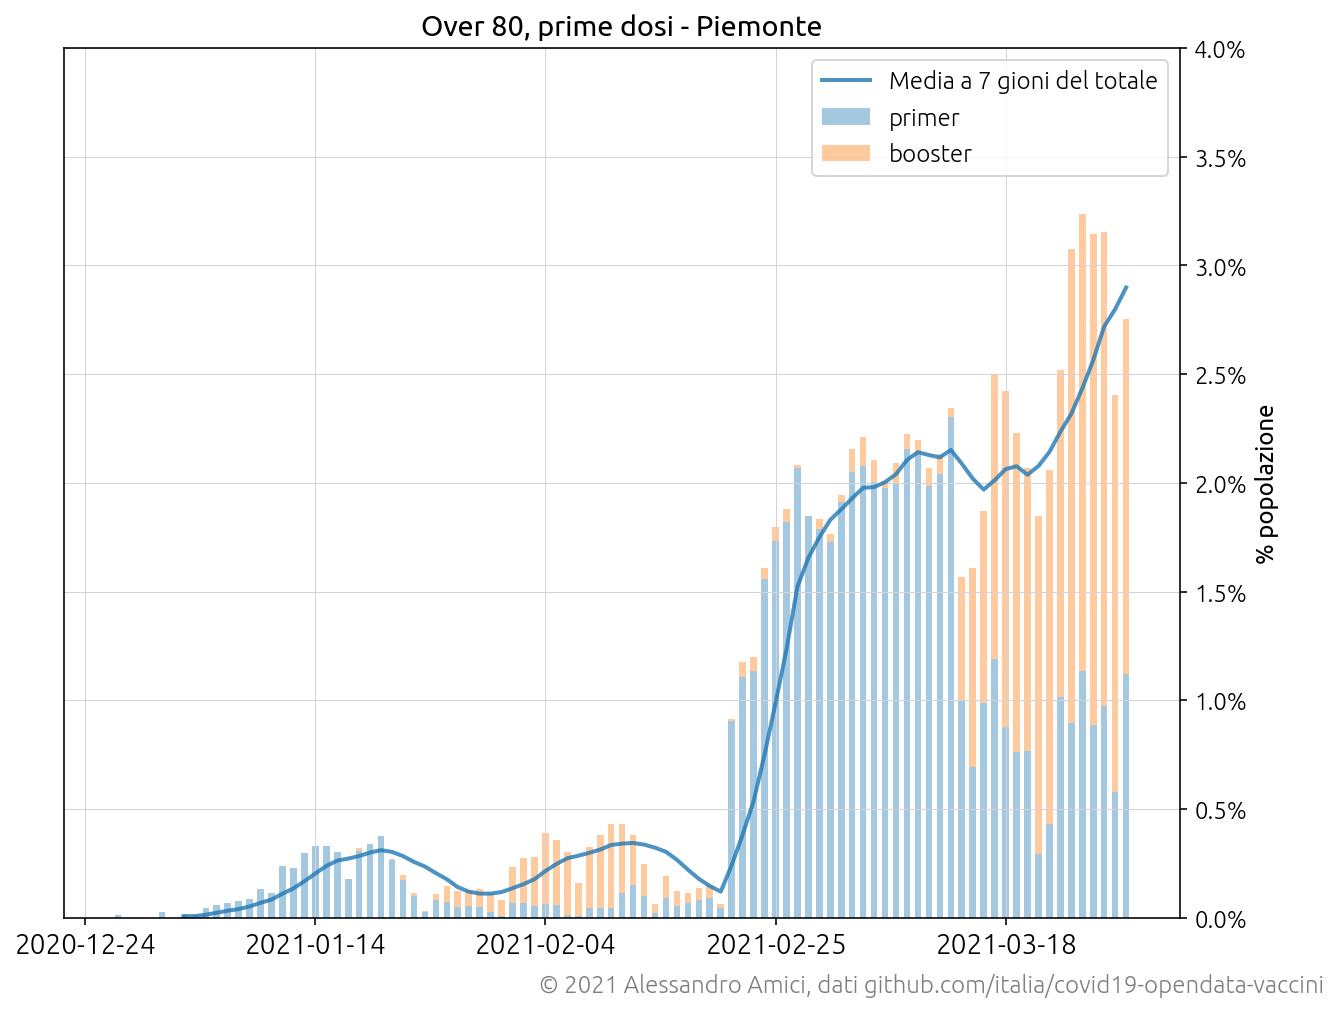

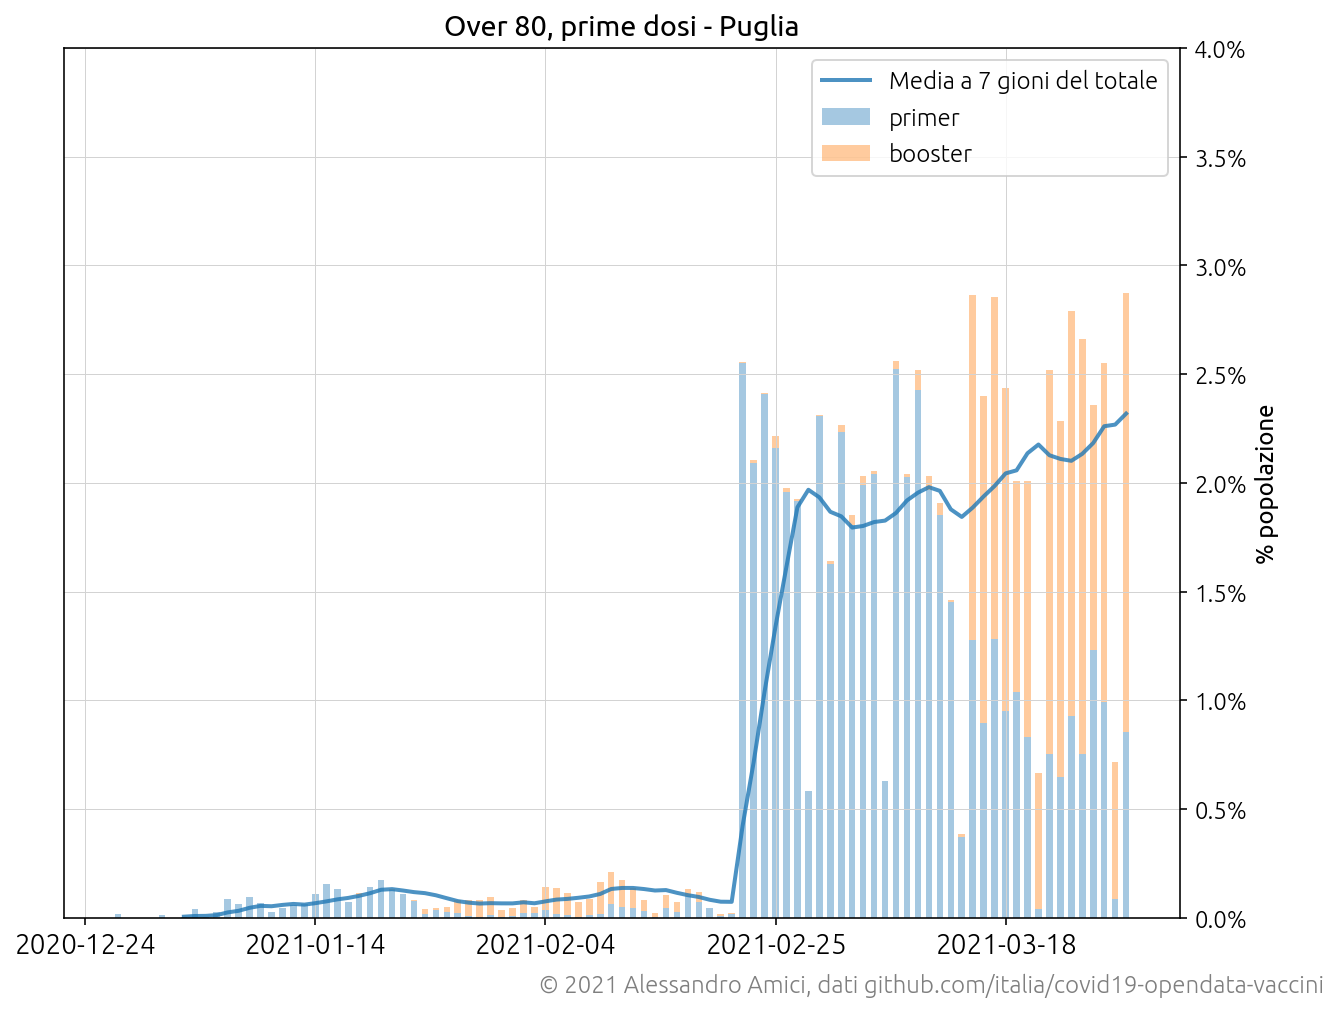

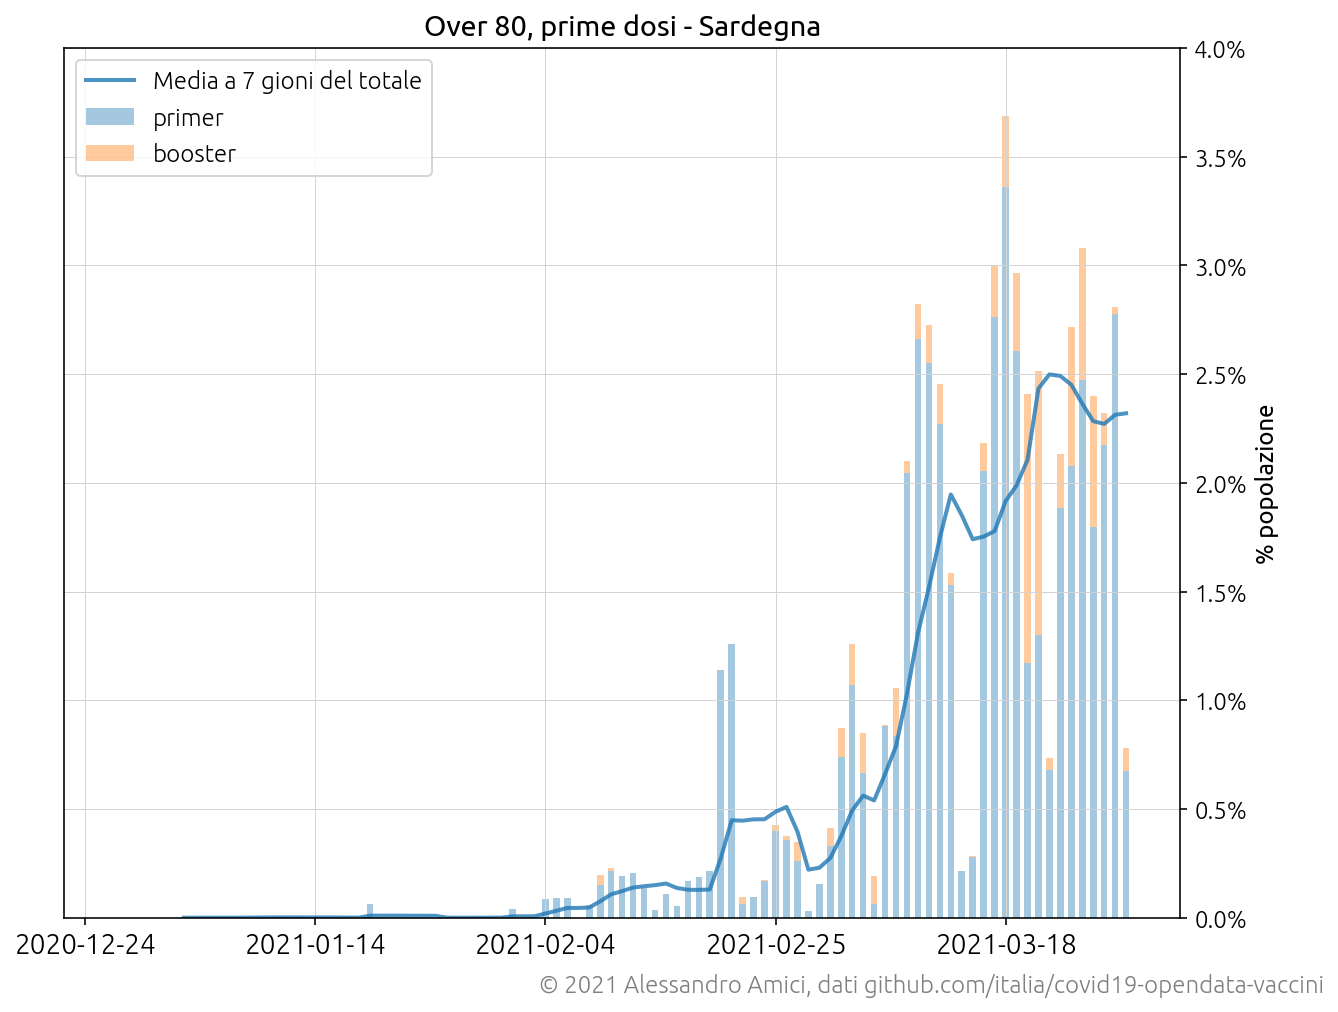

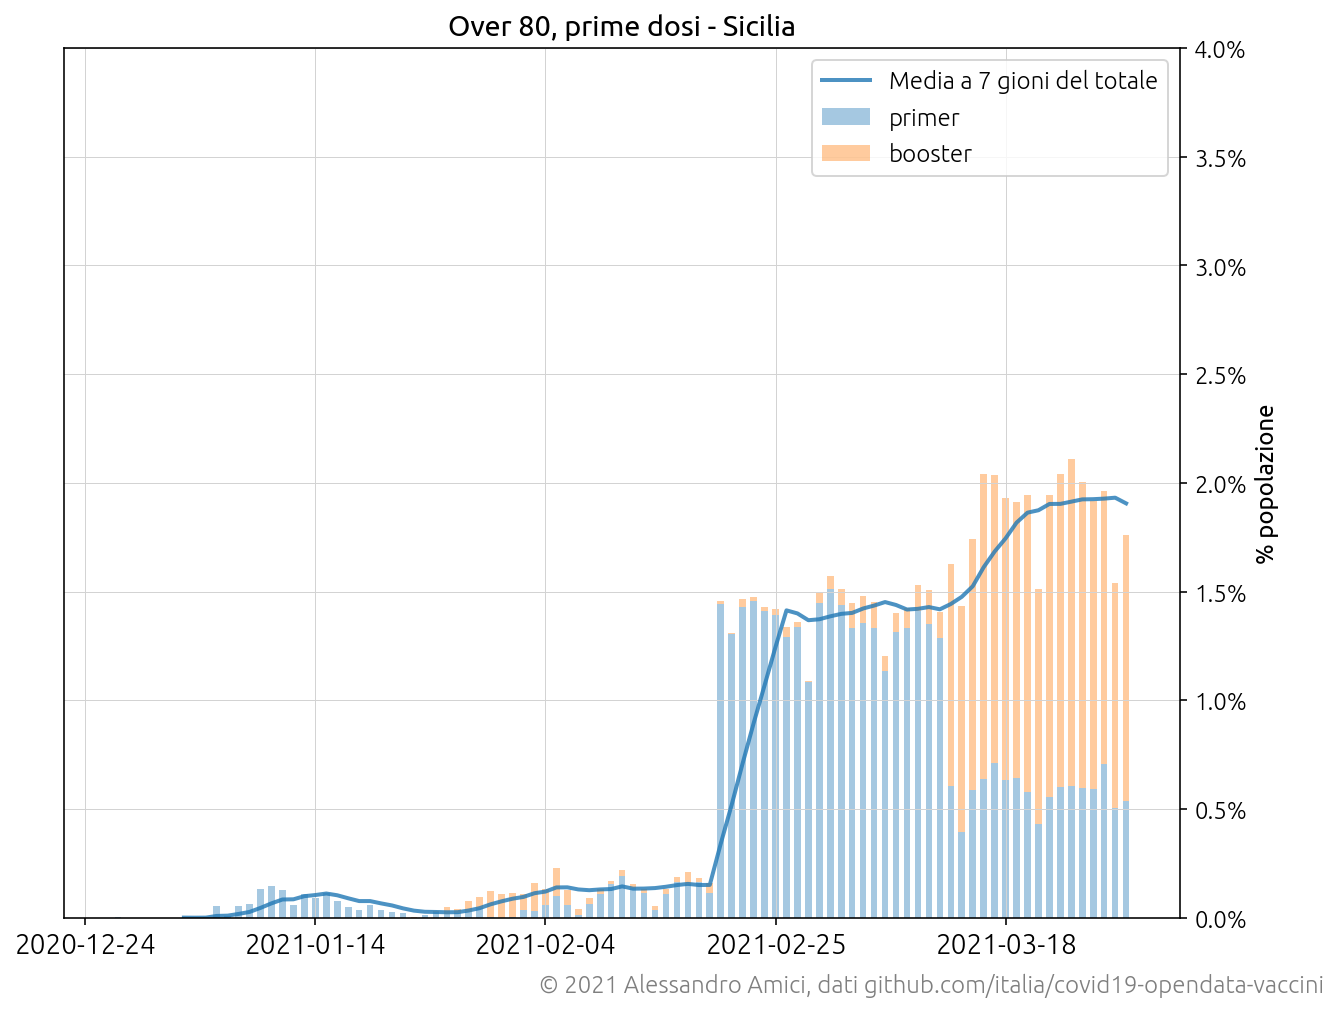

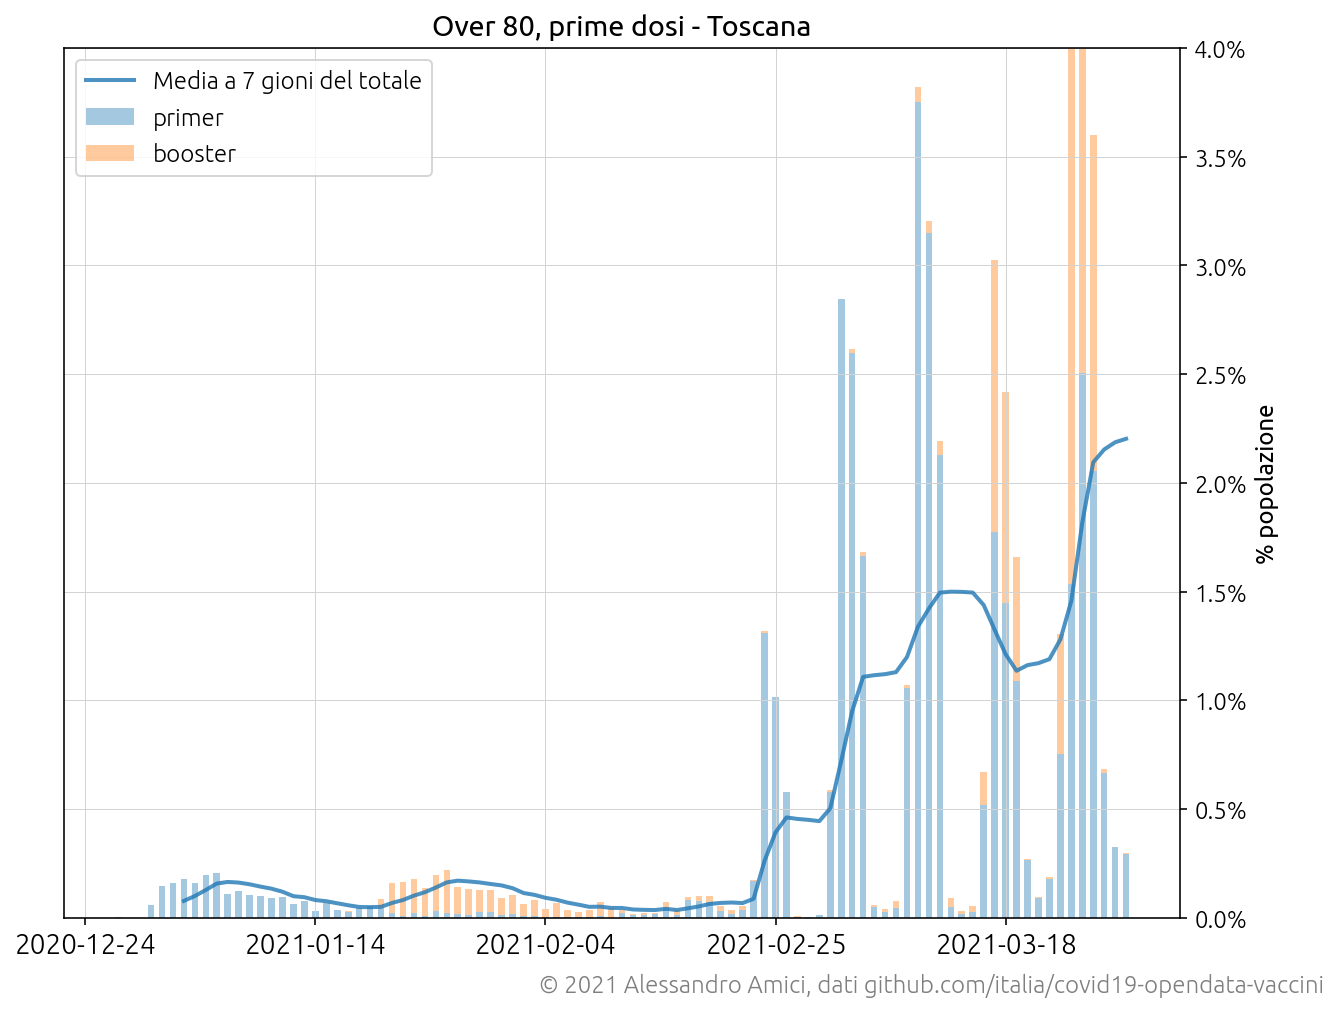

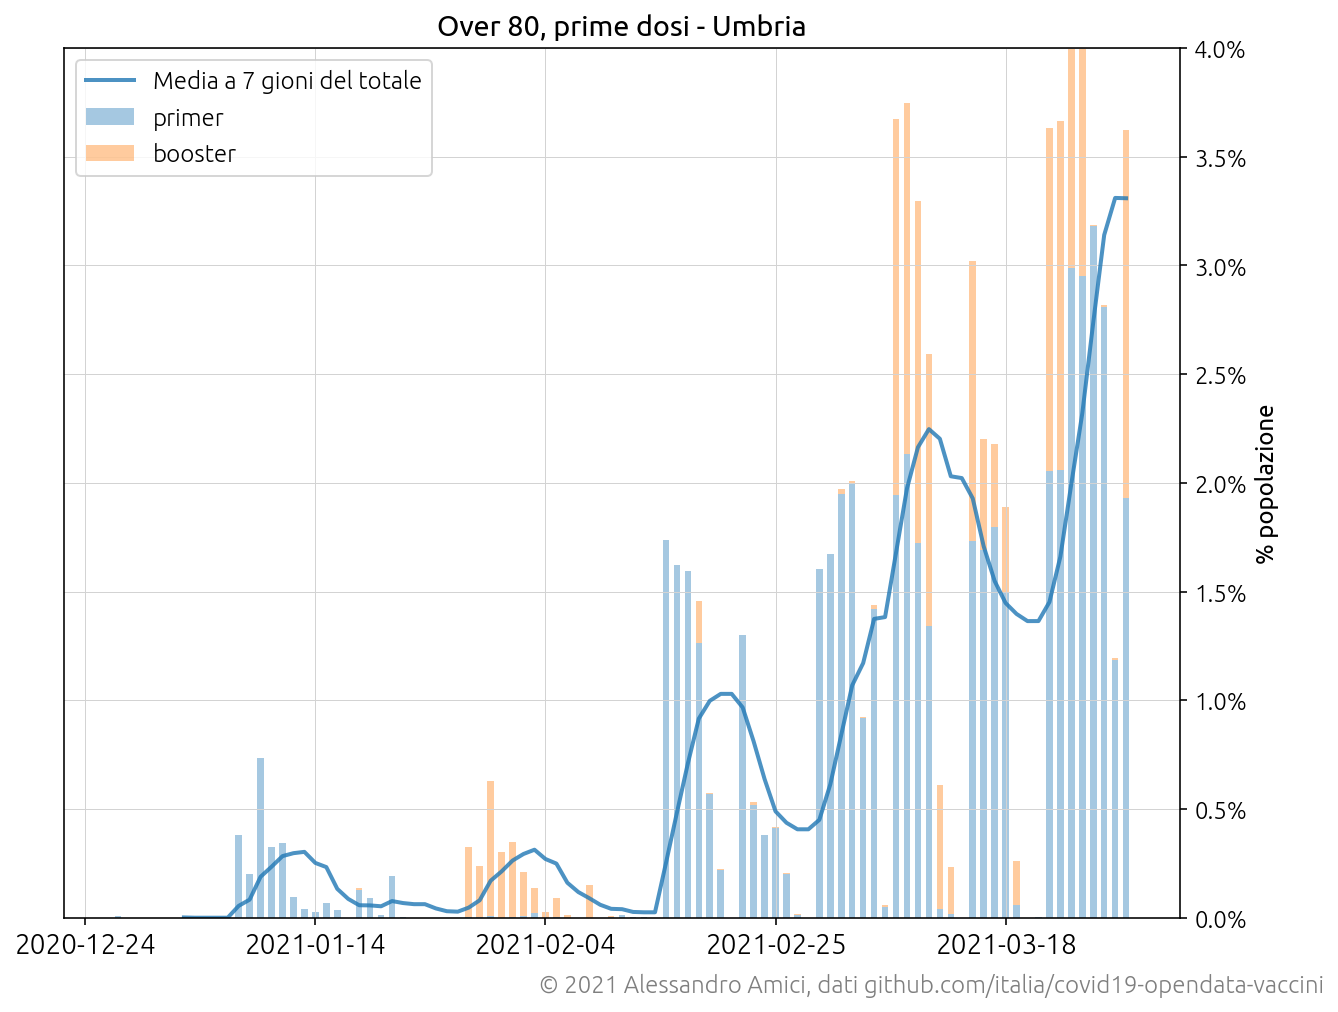

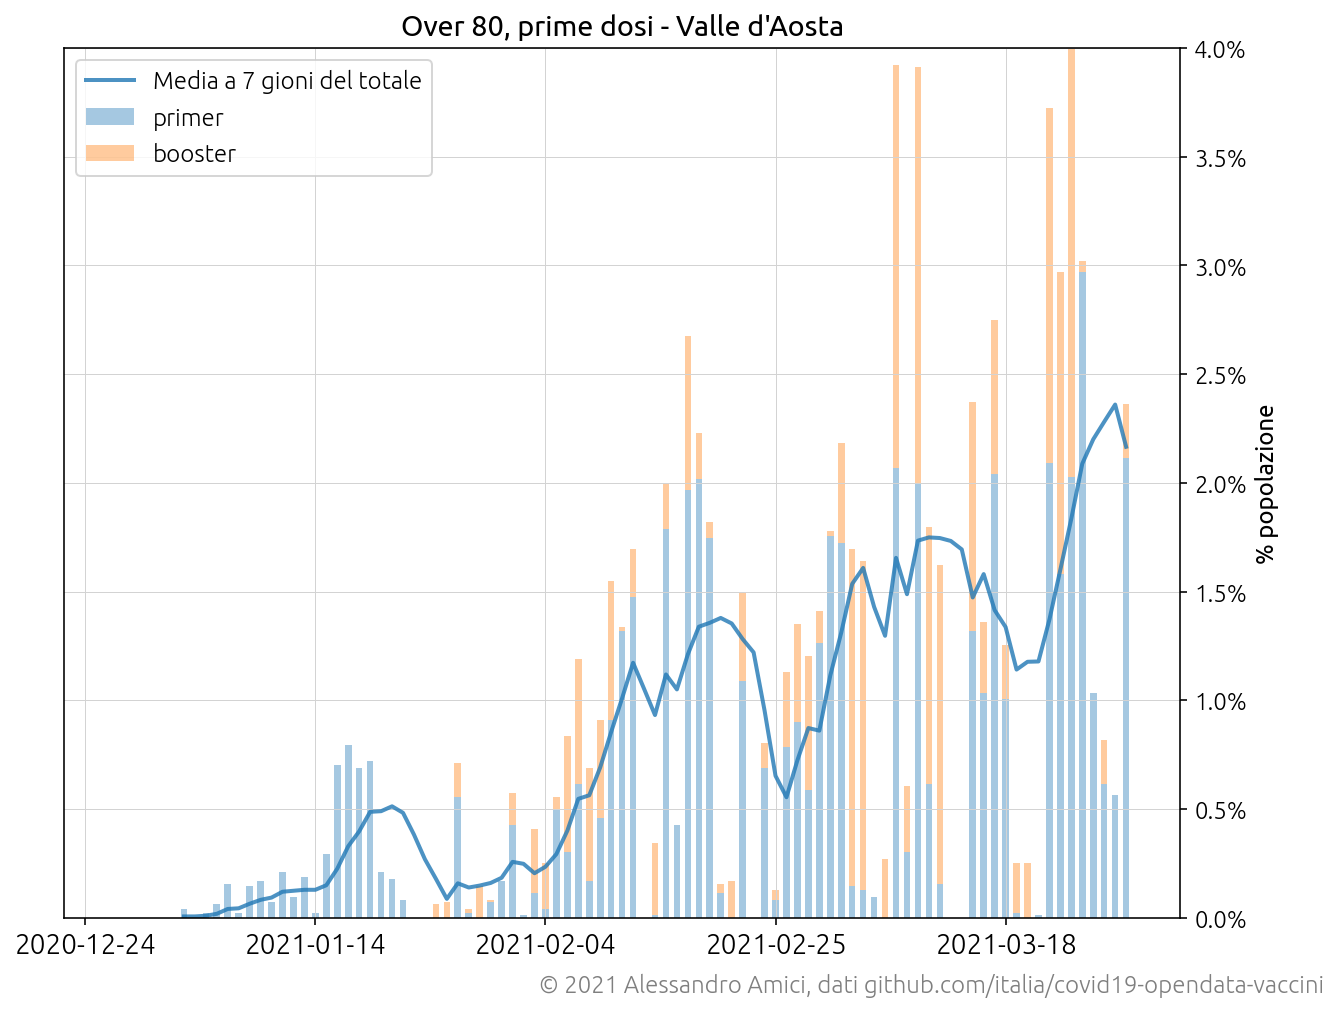

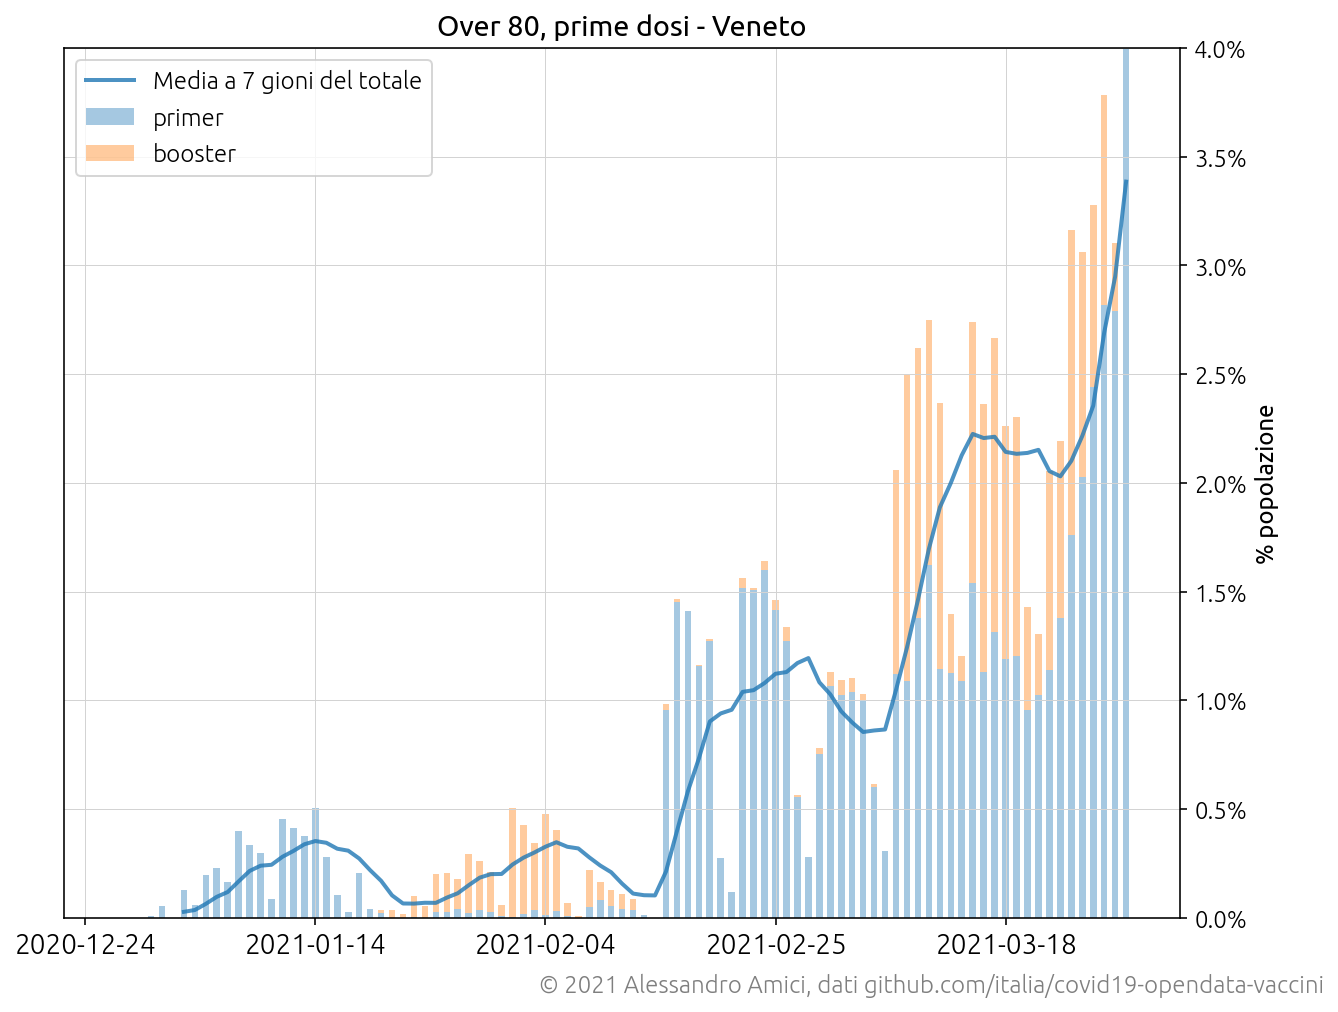

In [1045]:
data = vaccines_italy.sel(age_class=slice("80-89", None)).sum(["age_class", "provider"]).doses / vaccines_italy.population_80
for location in primers80.location.values:
    fig, ax = covid19.plot.subplots(note=COPYRIGHT)
    covid19.plot.stack_xarray(data.sel(location=location), hue="dose_type", window=7, title=f"Over 80, prime dosi - {location}", ylim=(0, 0.04), label_total="Media a 7 gioni del totale", ax=ax)
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1, 1))
    ax.set(ylabel="% popolazione")
    ax.legend()

../covid19/plot.py:196: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(*args, **kwargs)


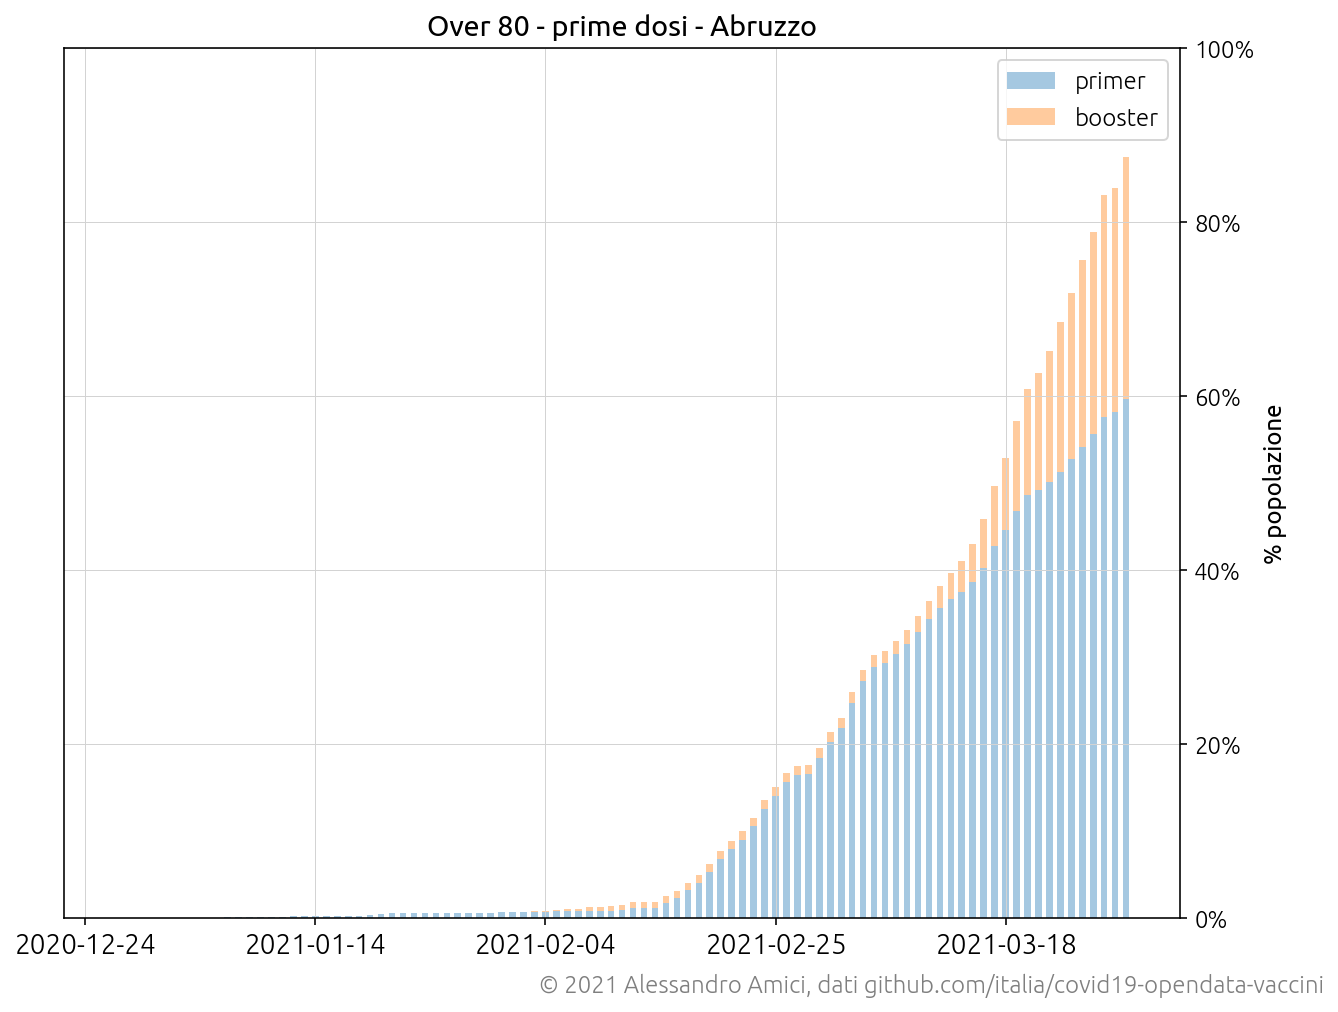

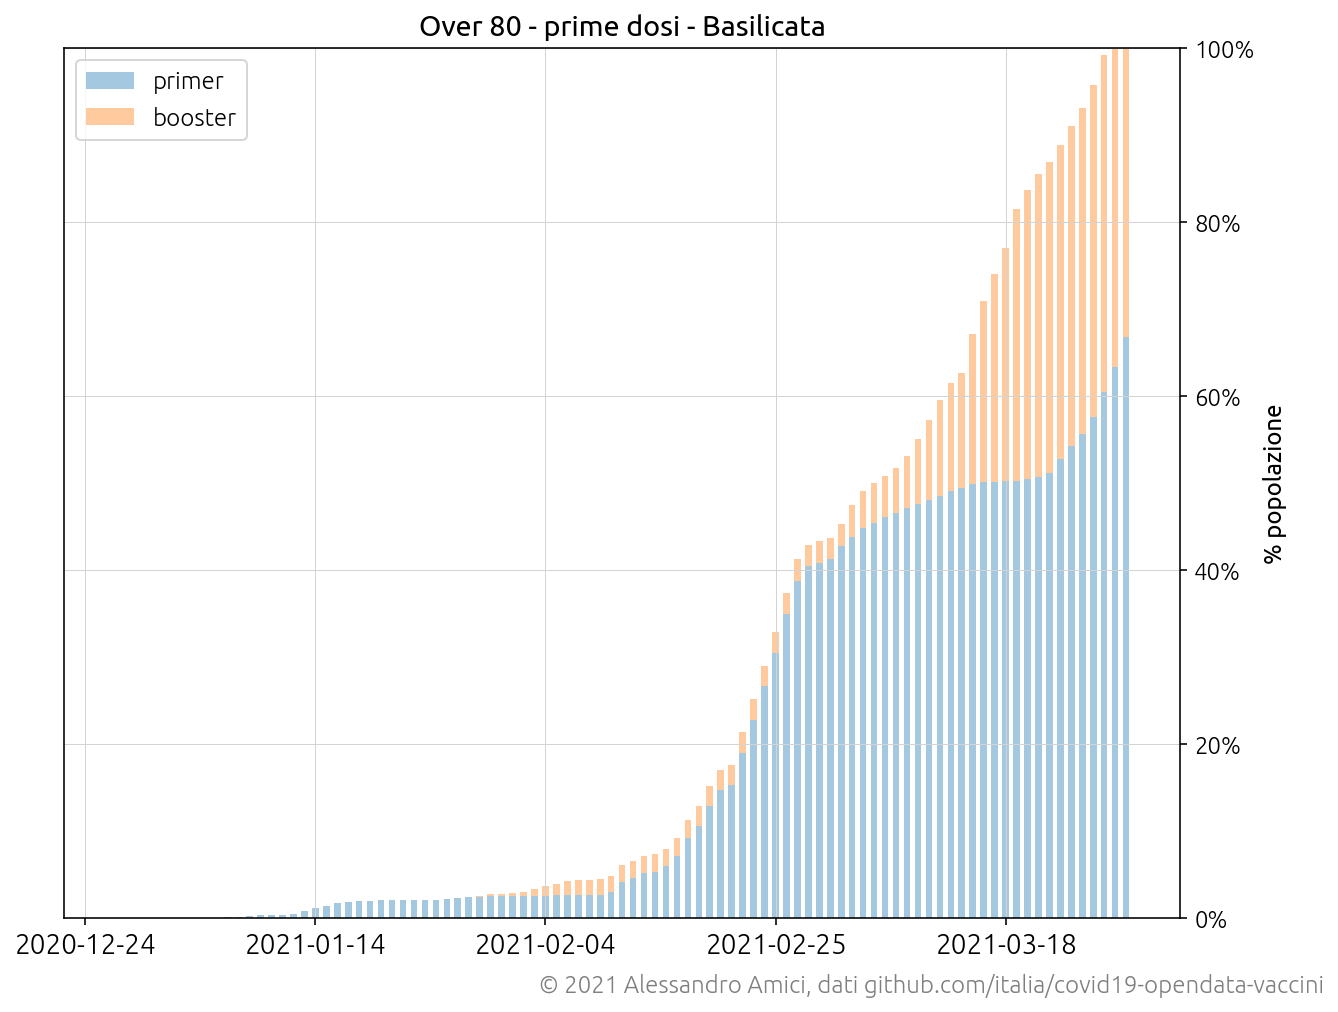

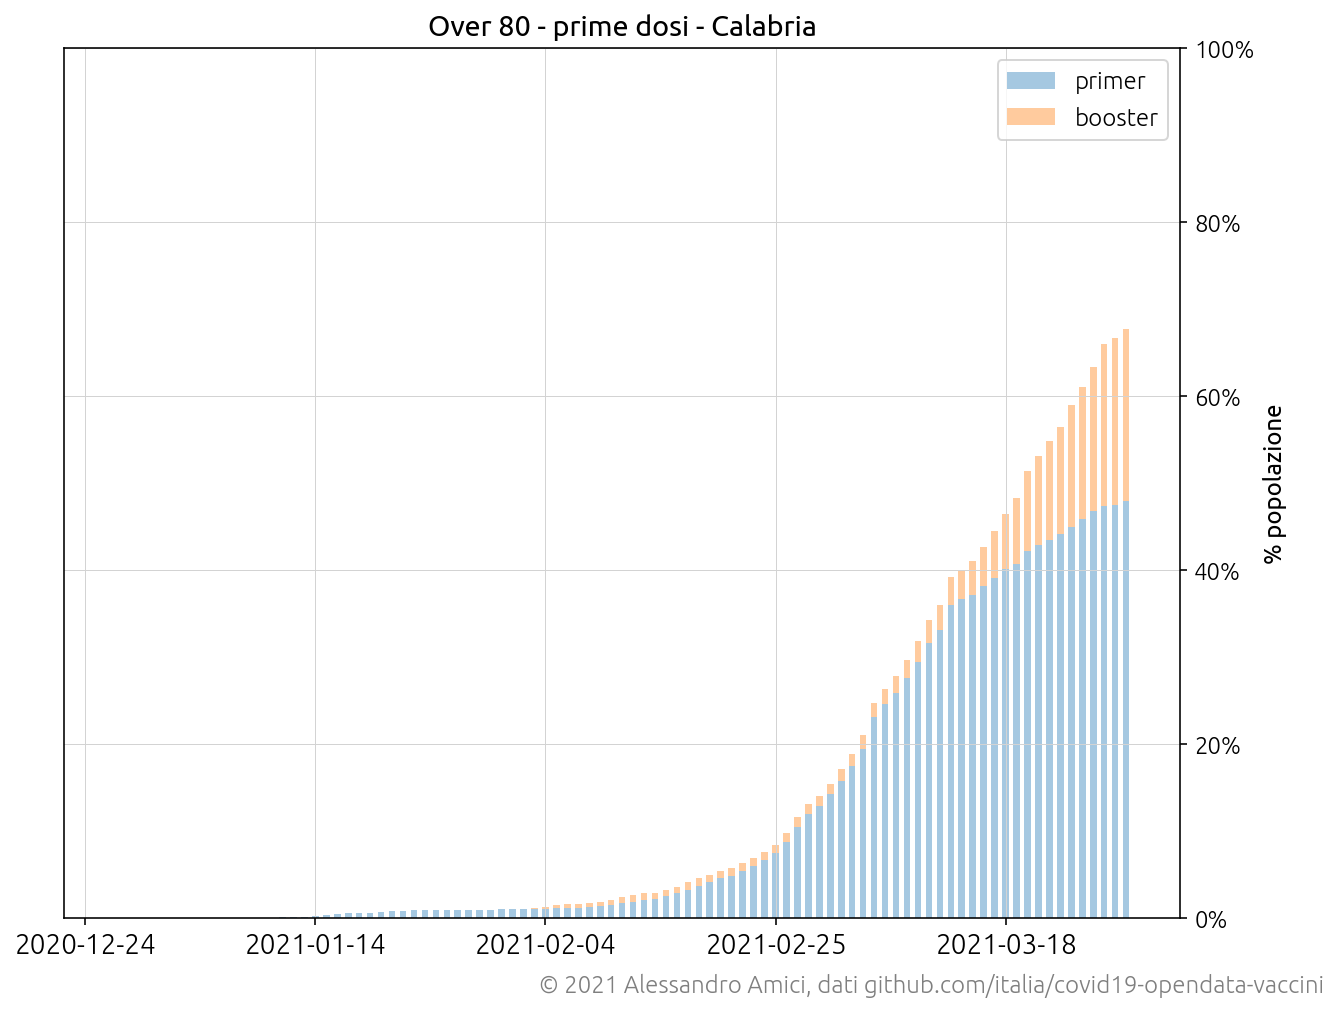

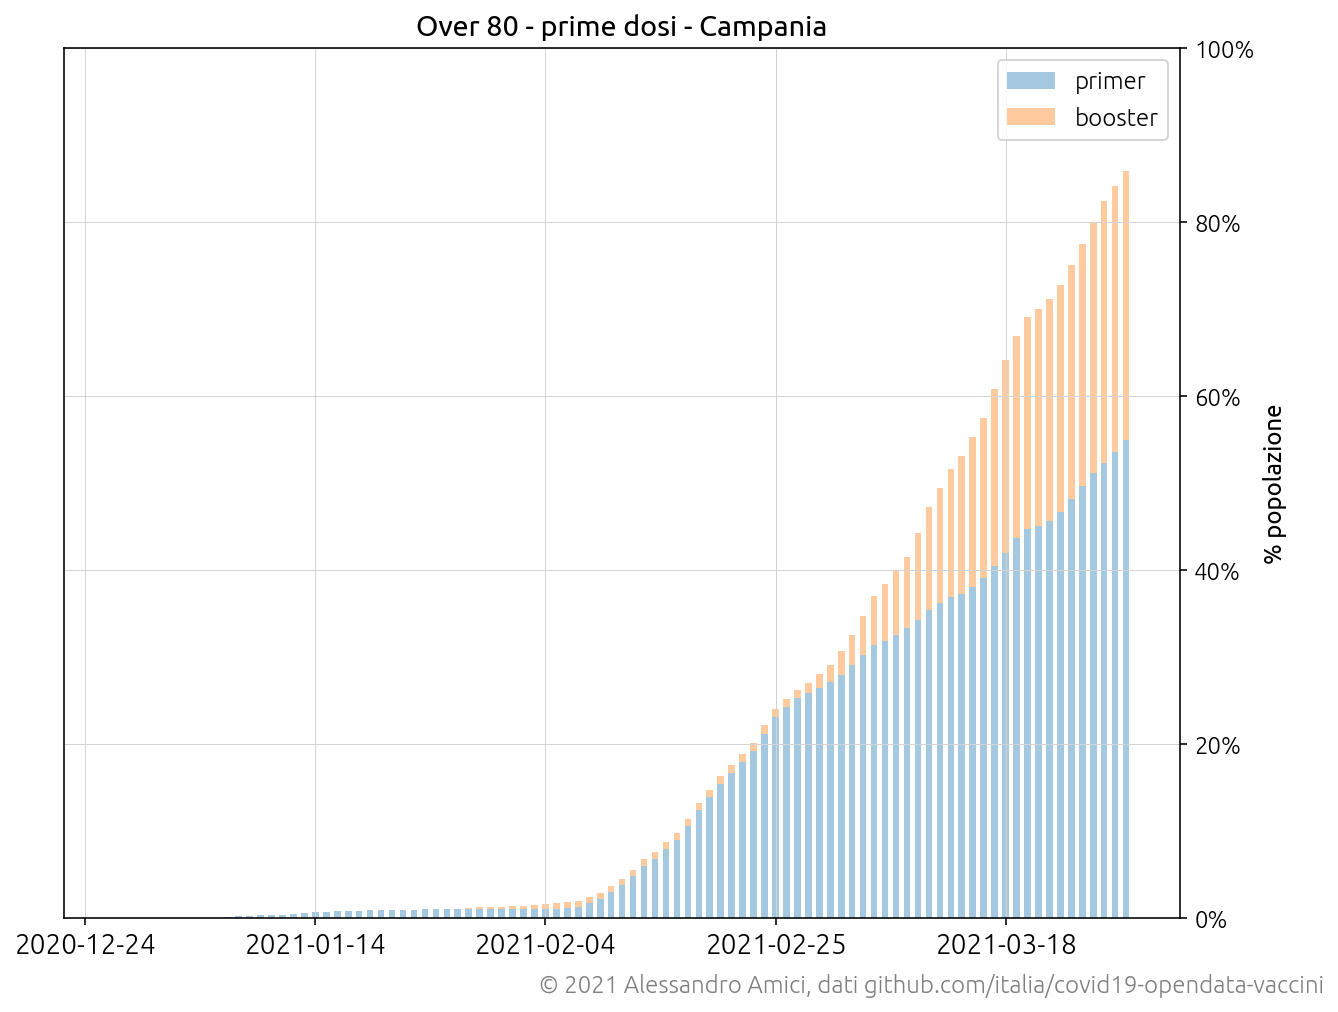

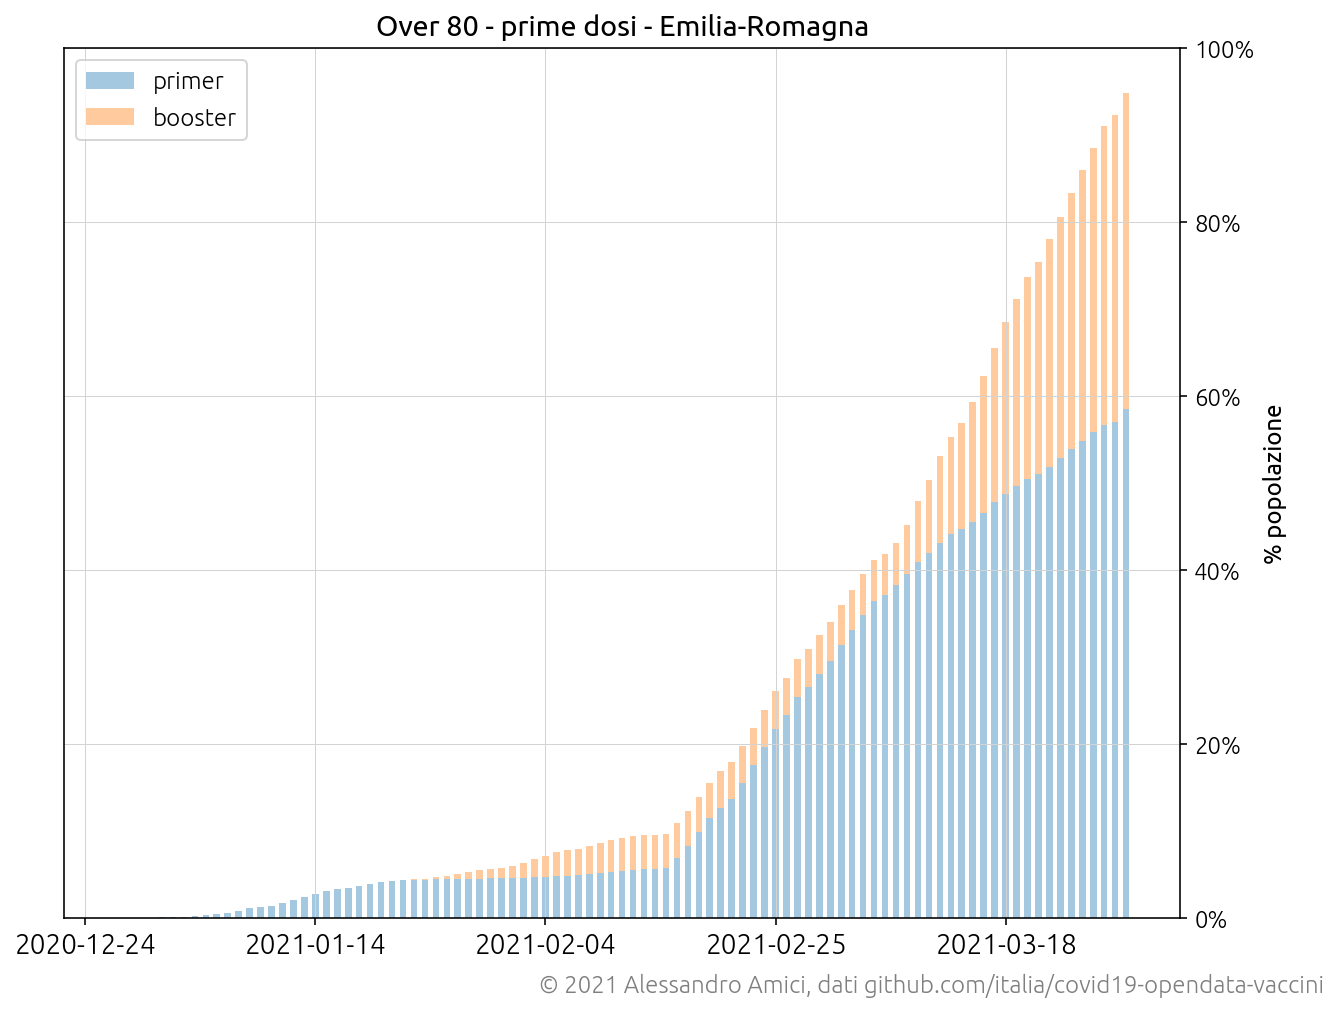

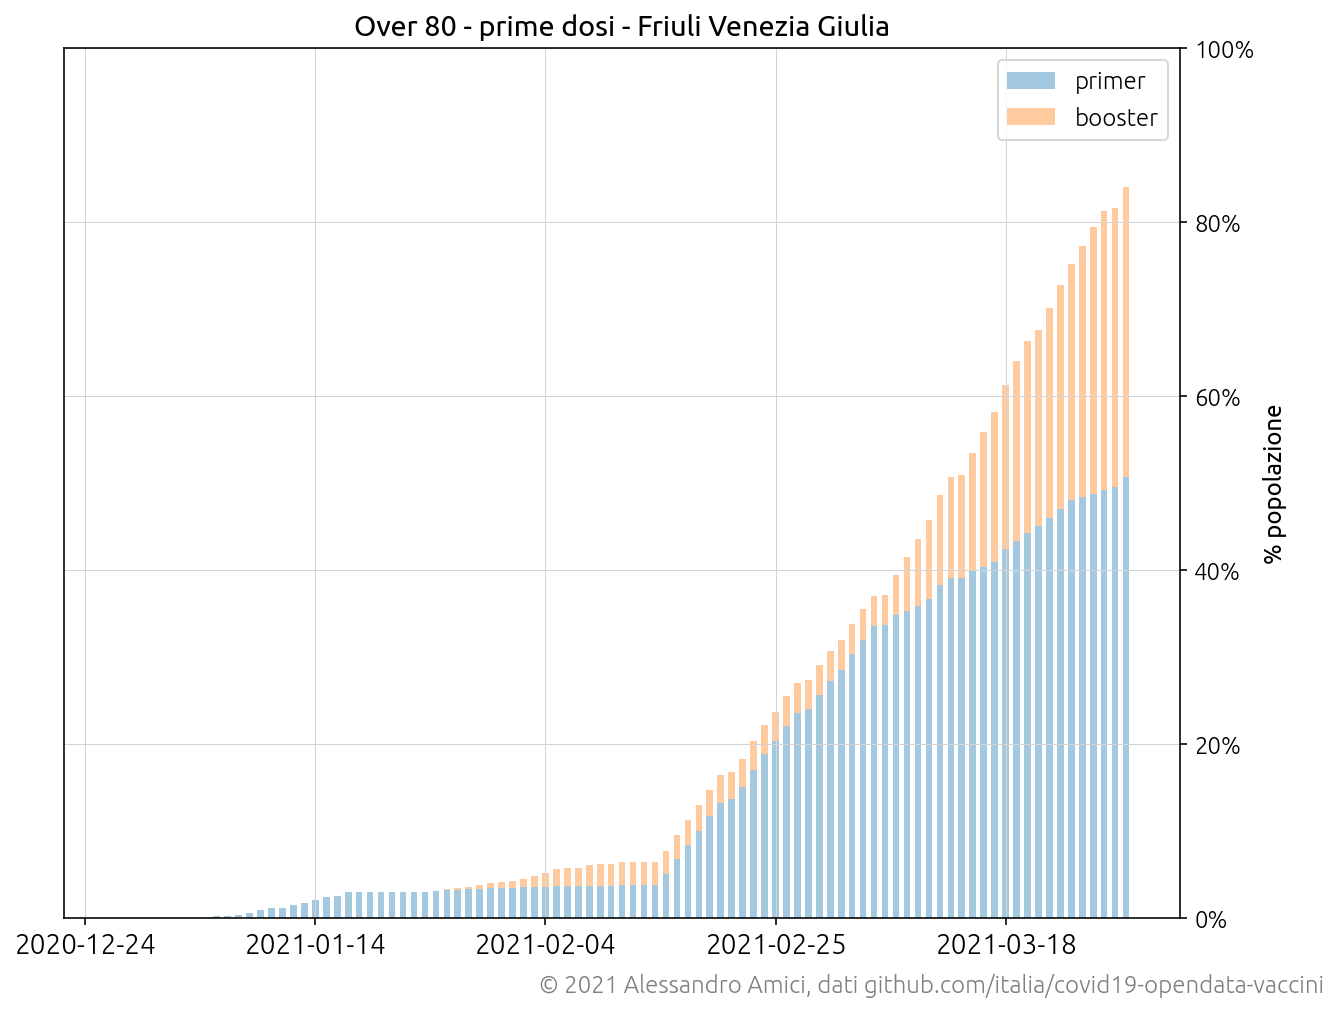

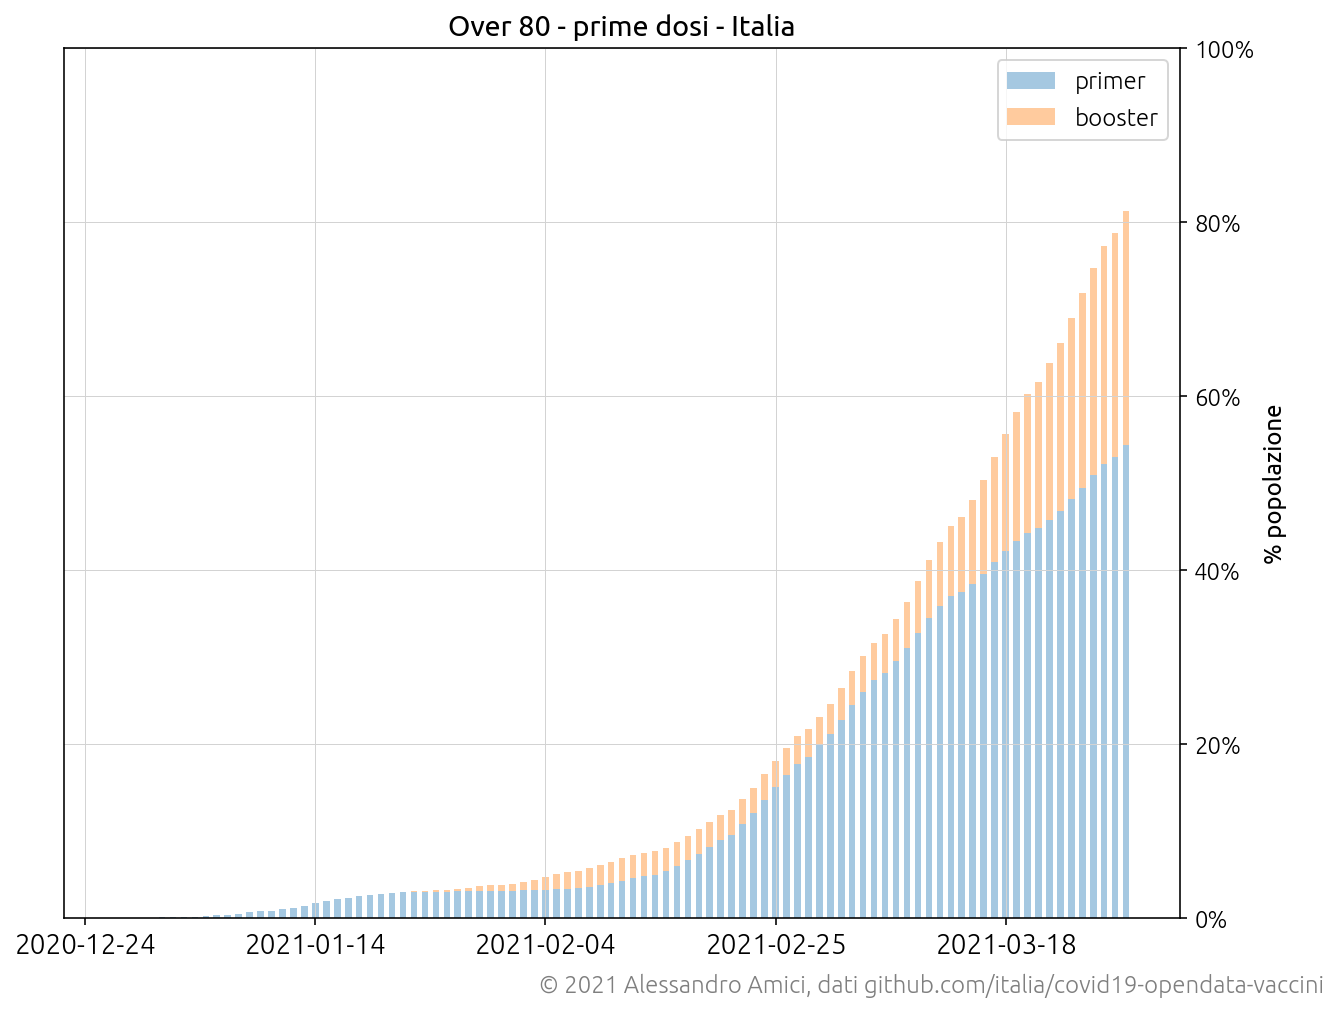

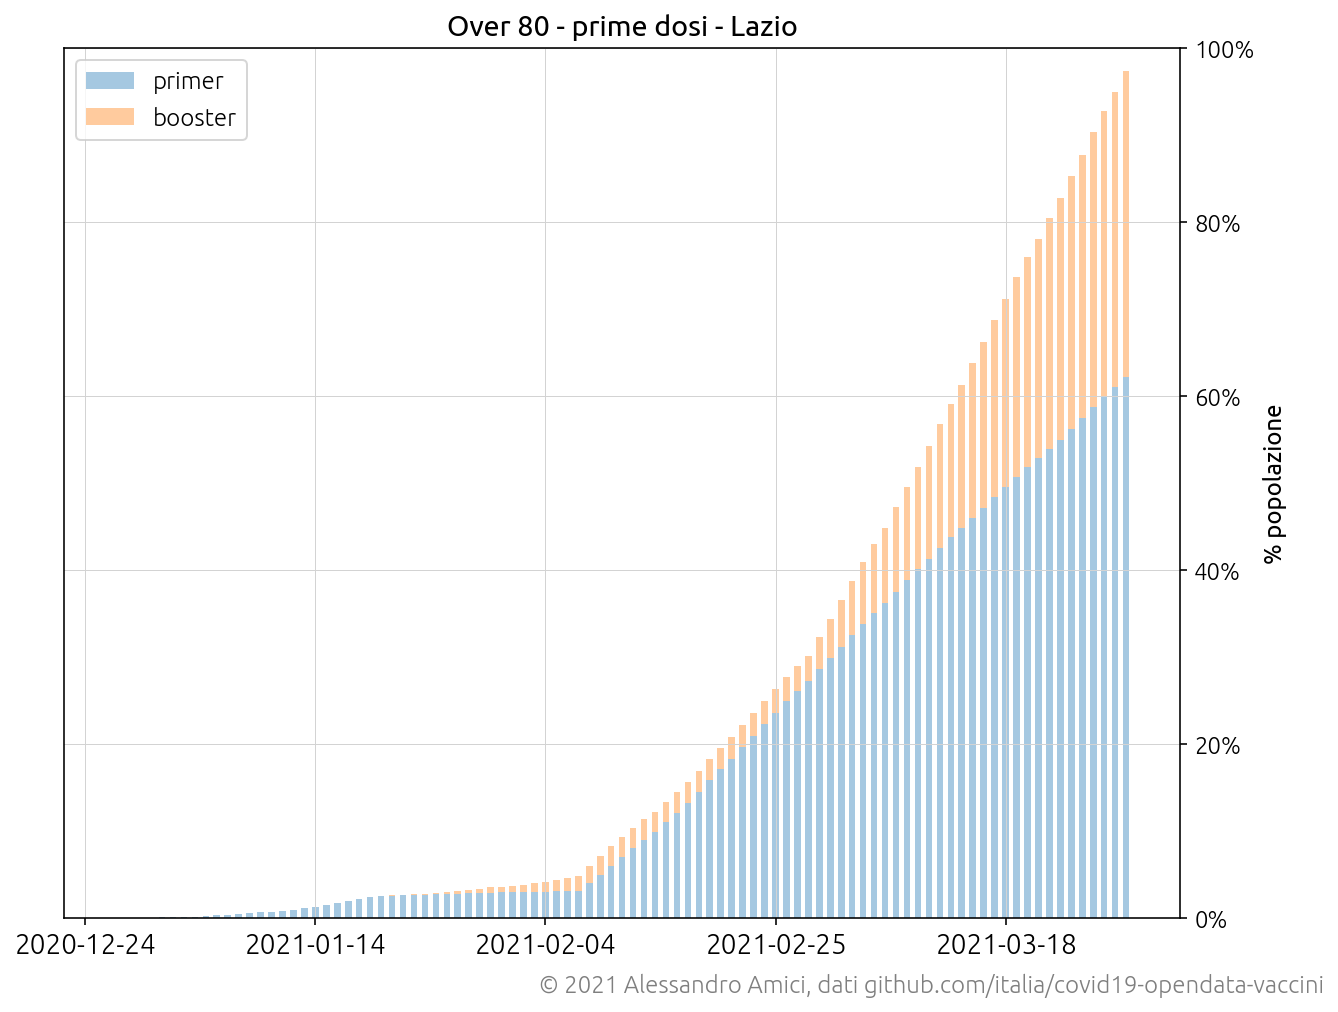

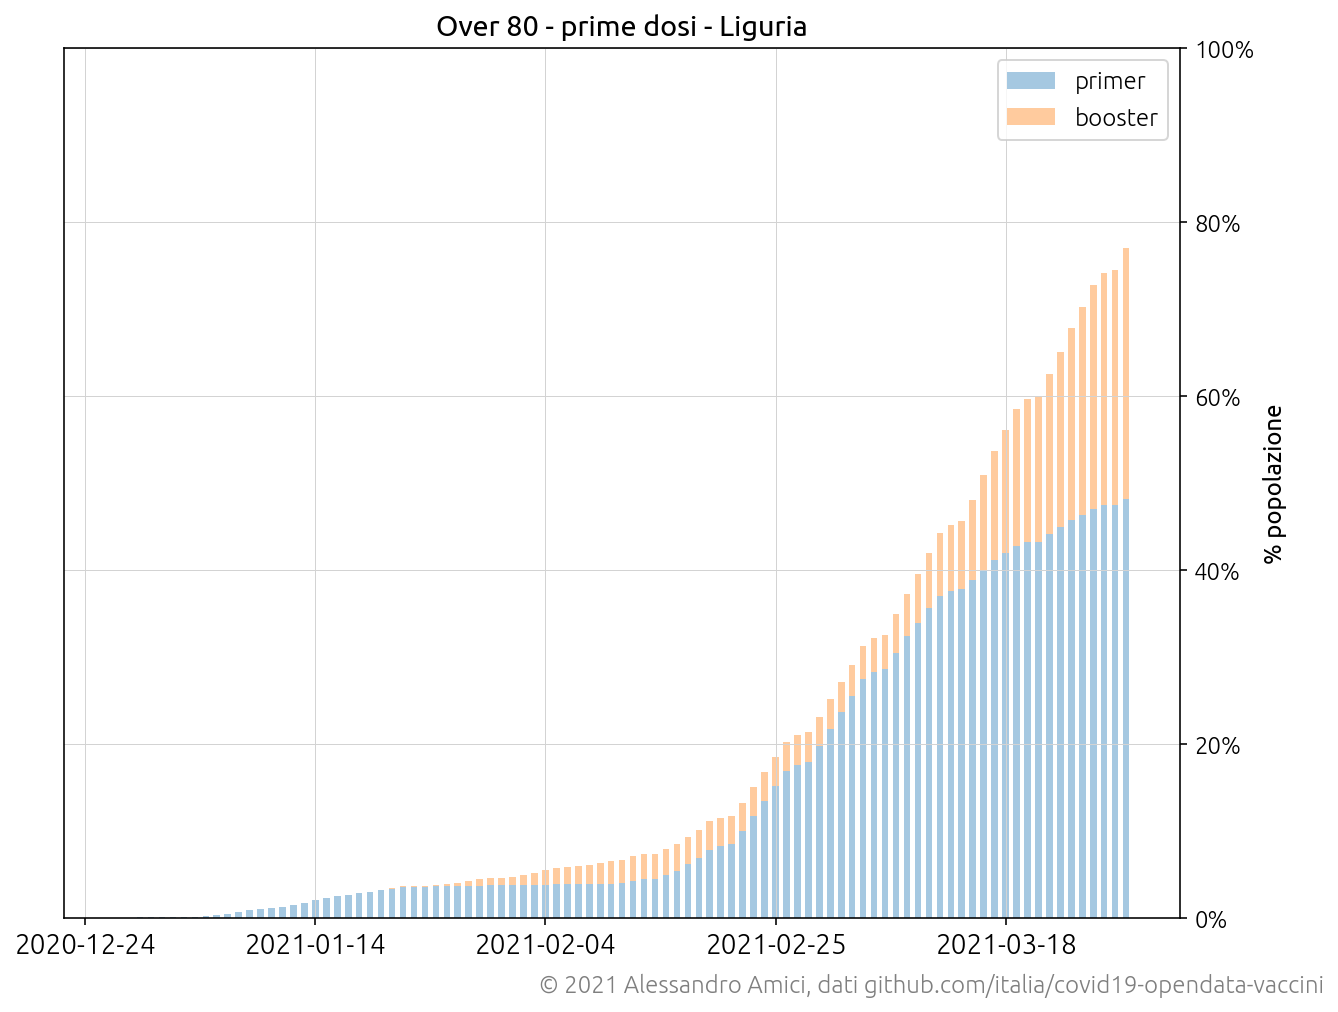

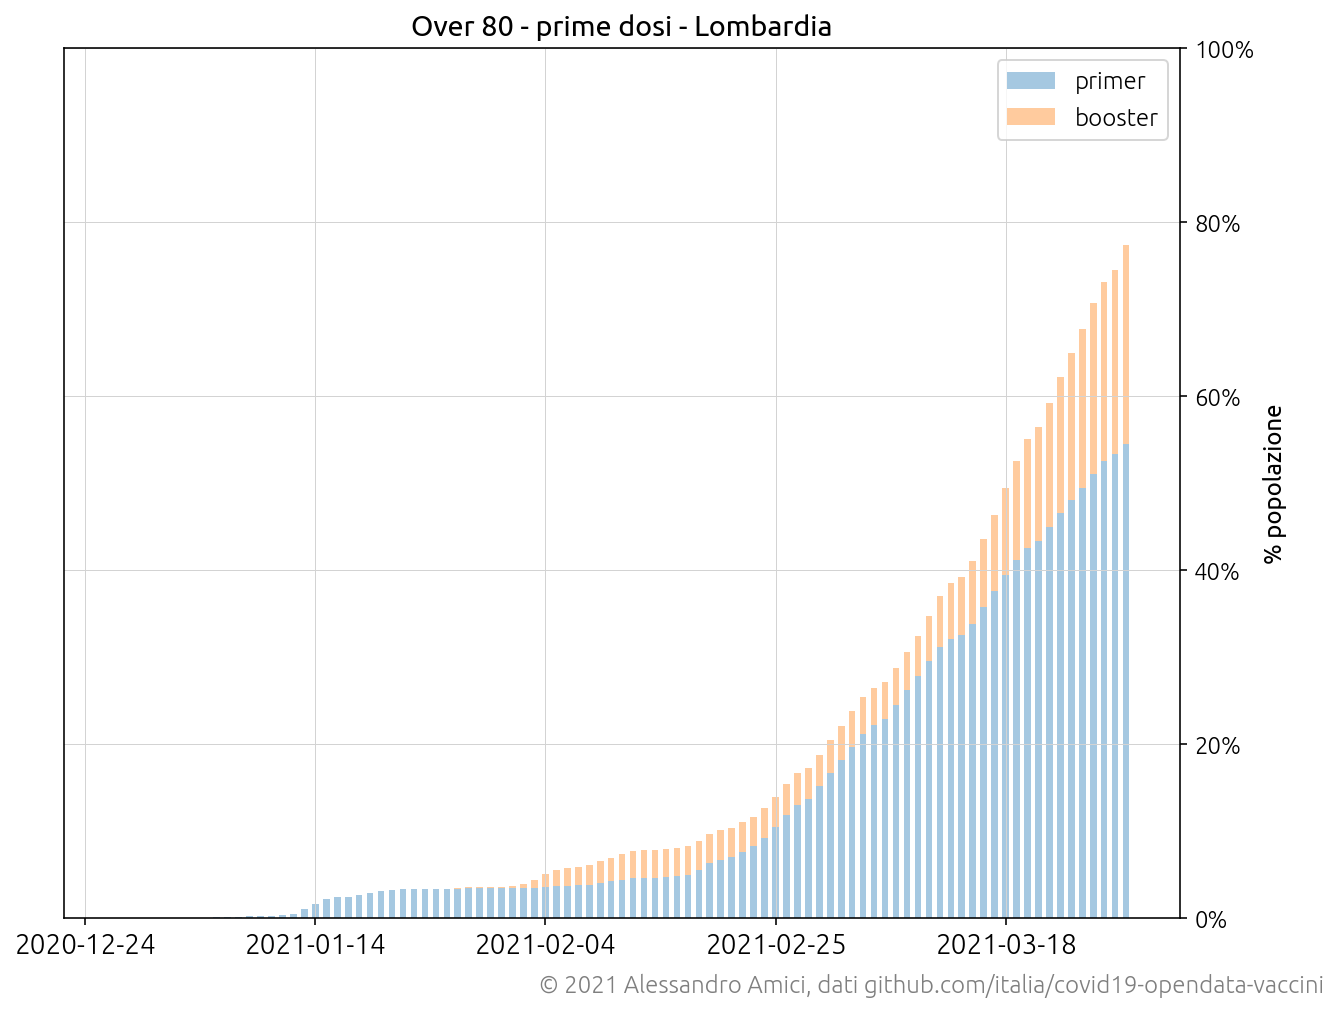

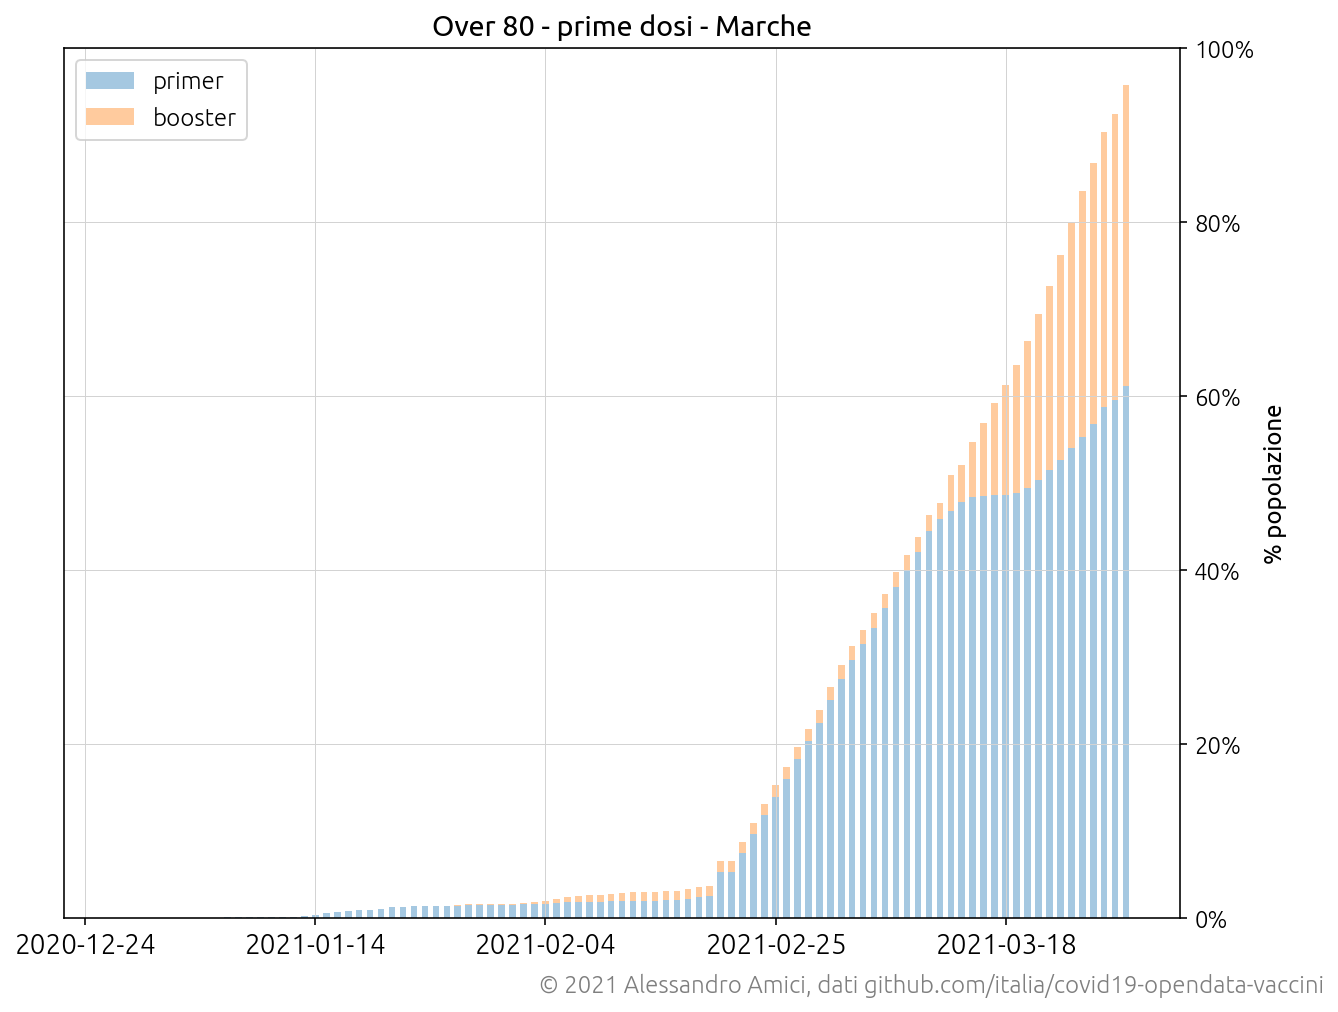

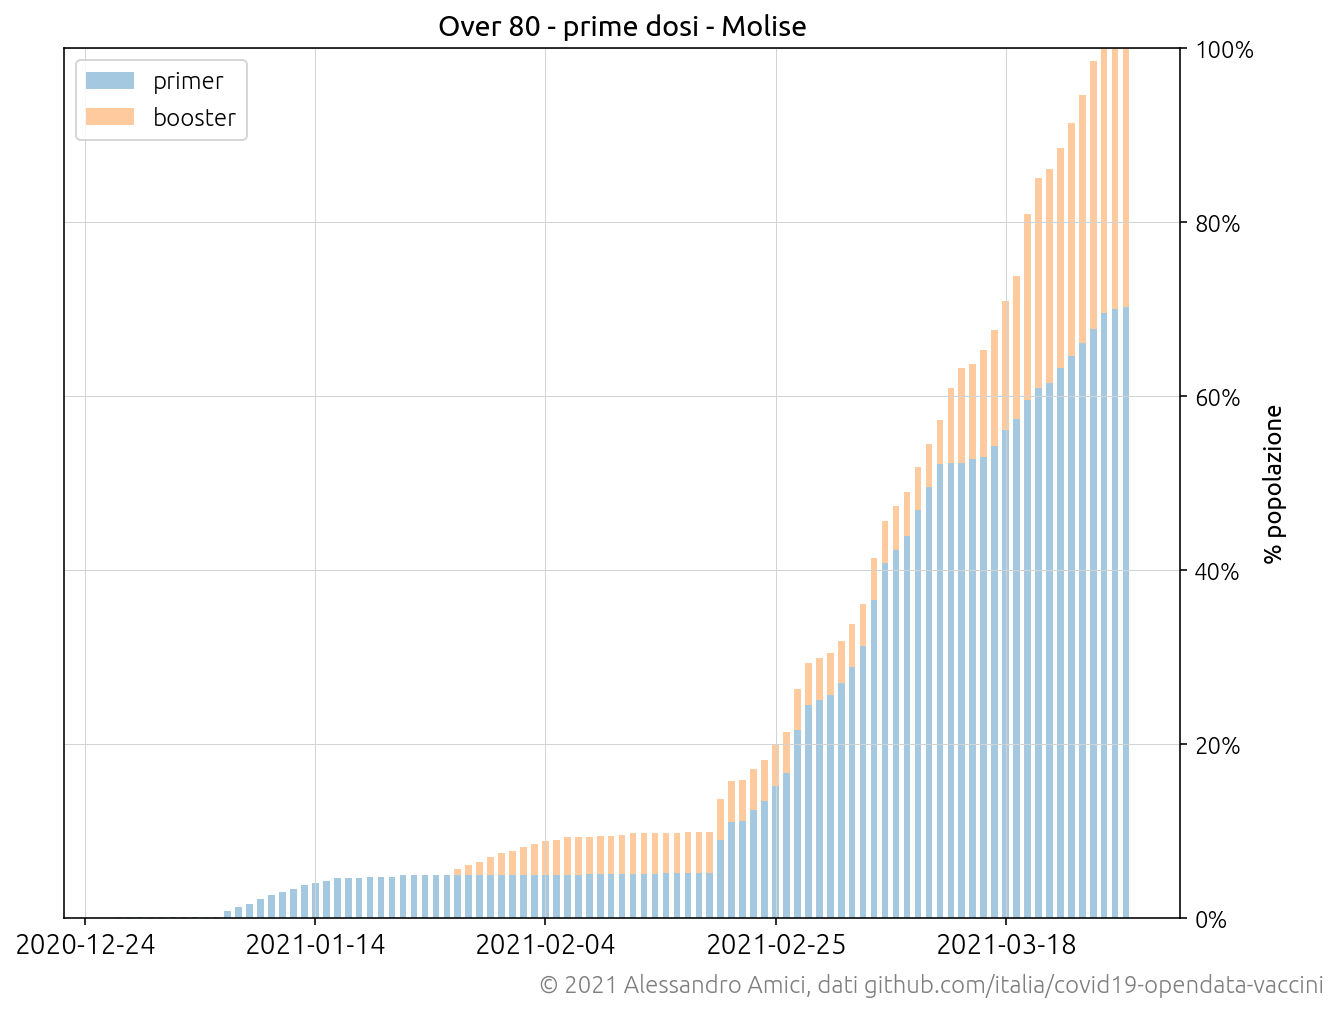

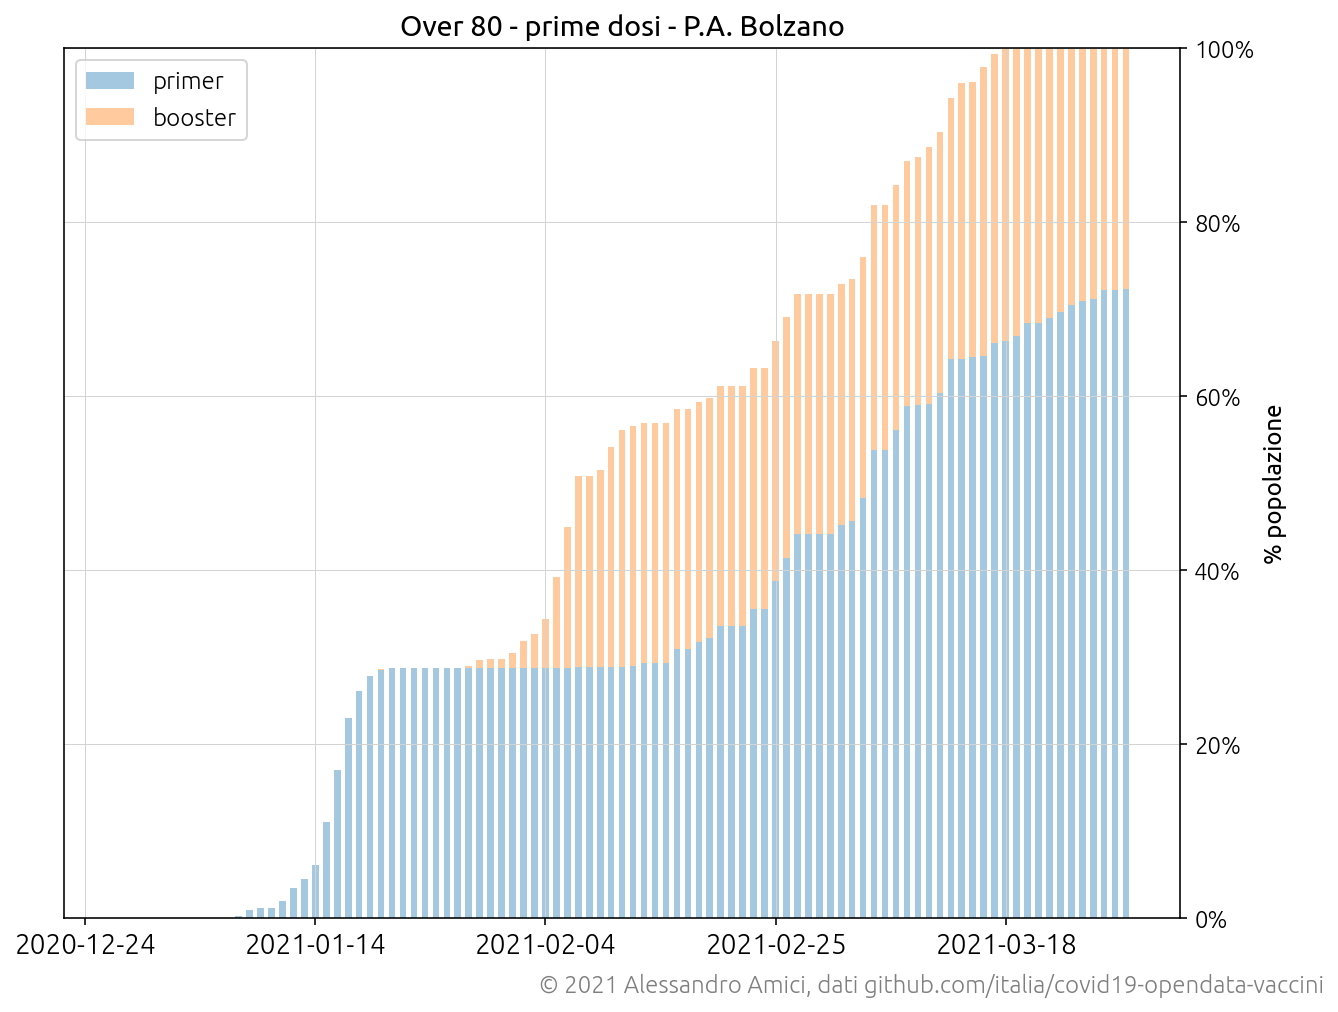

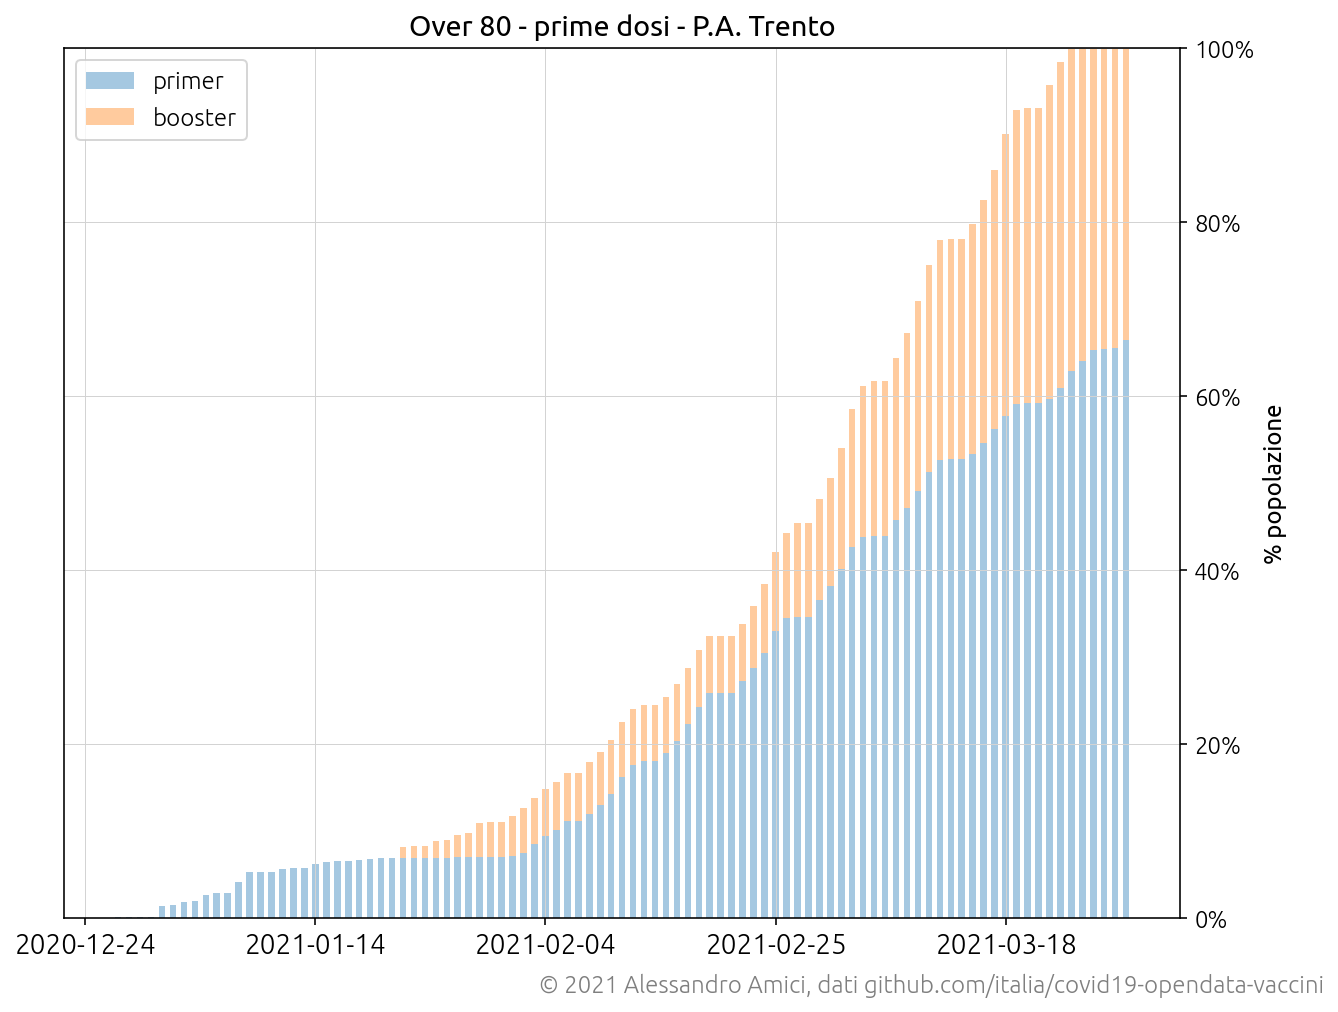

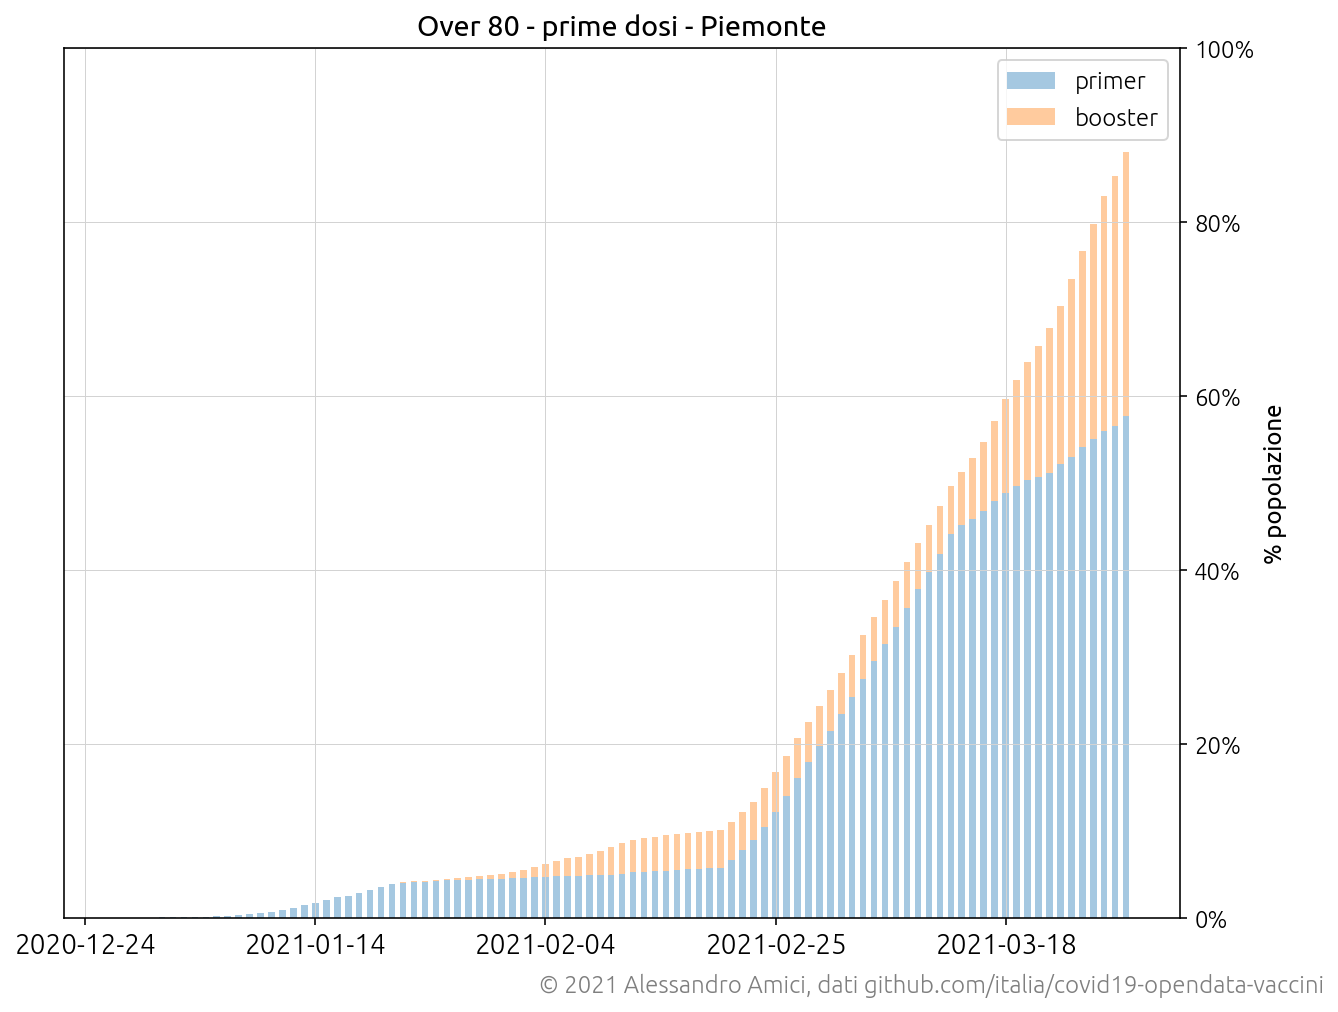

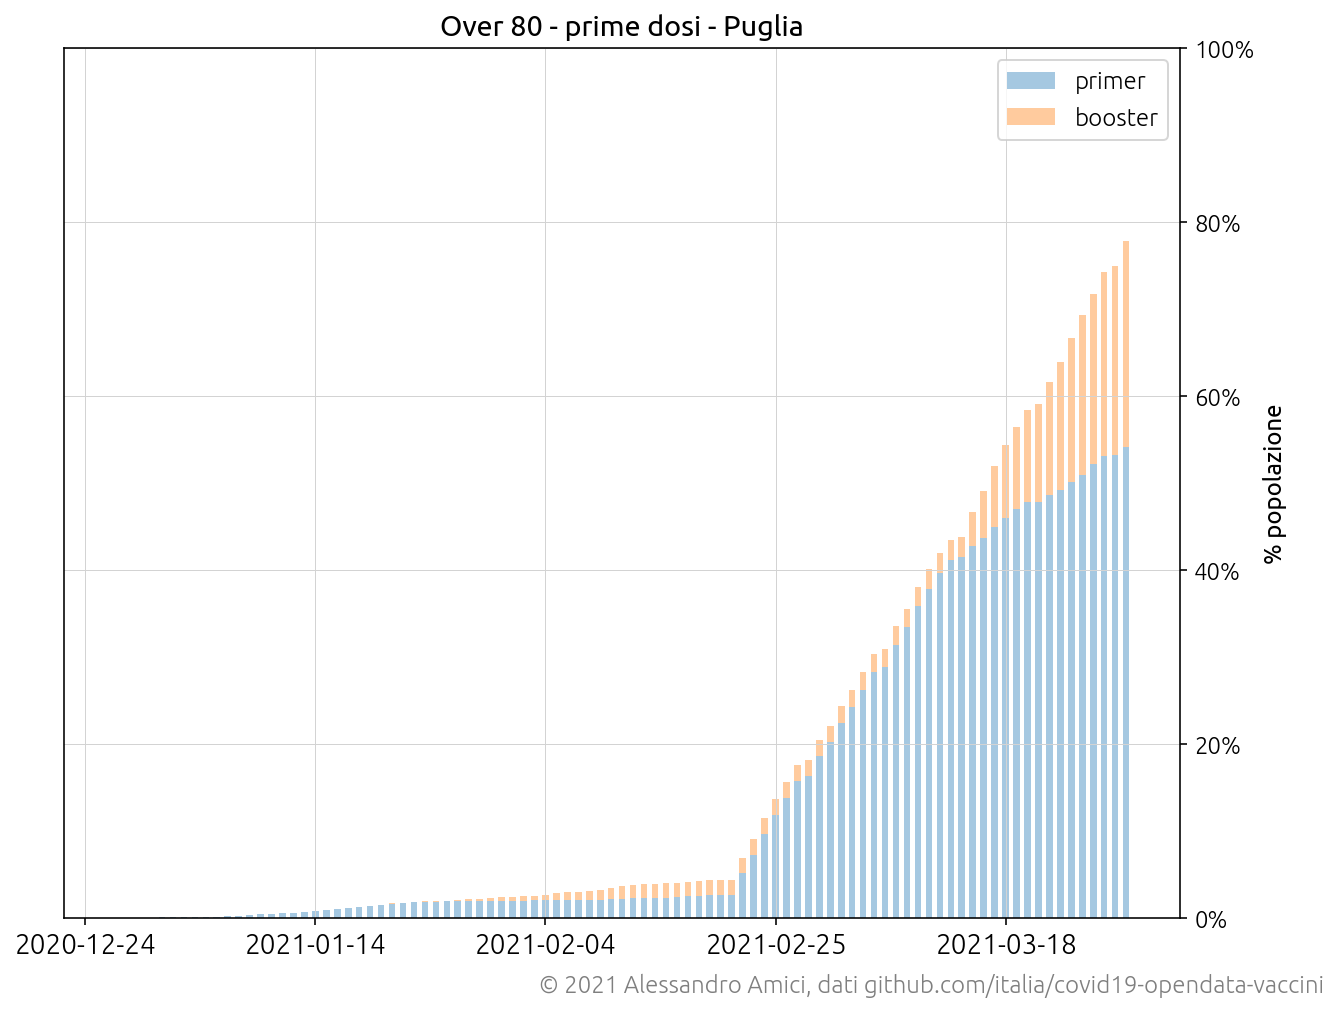

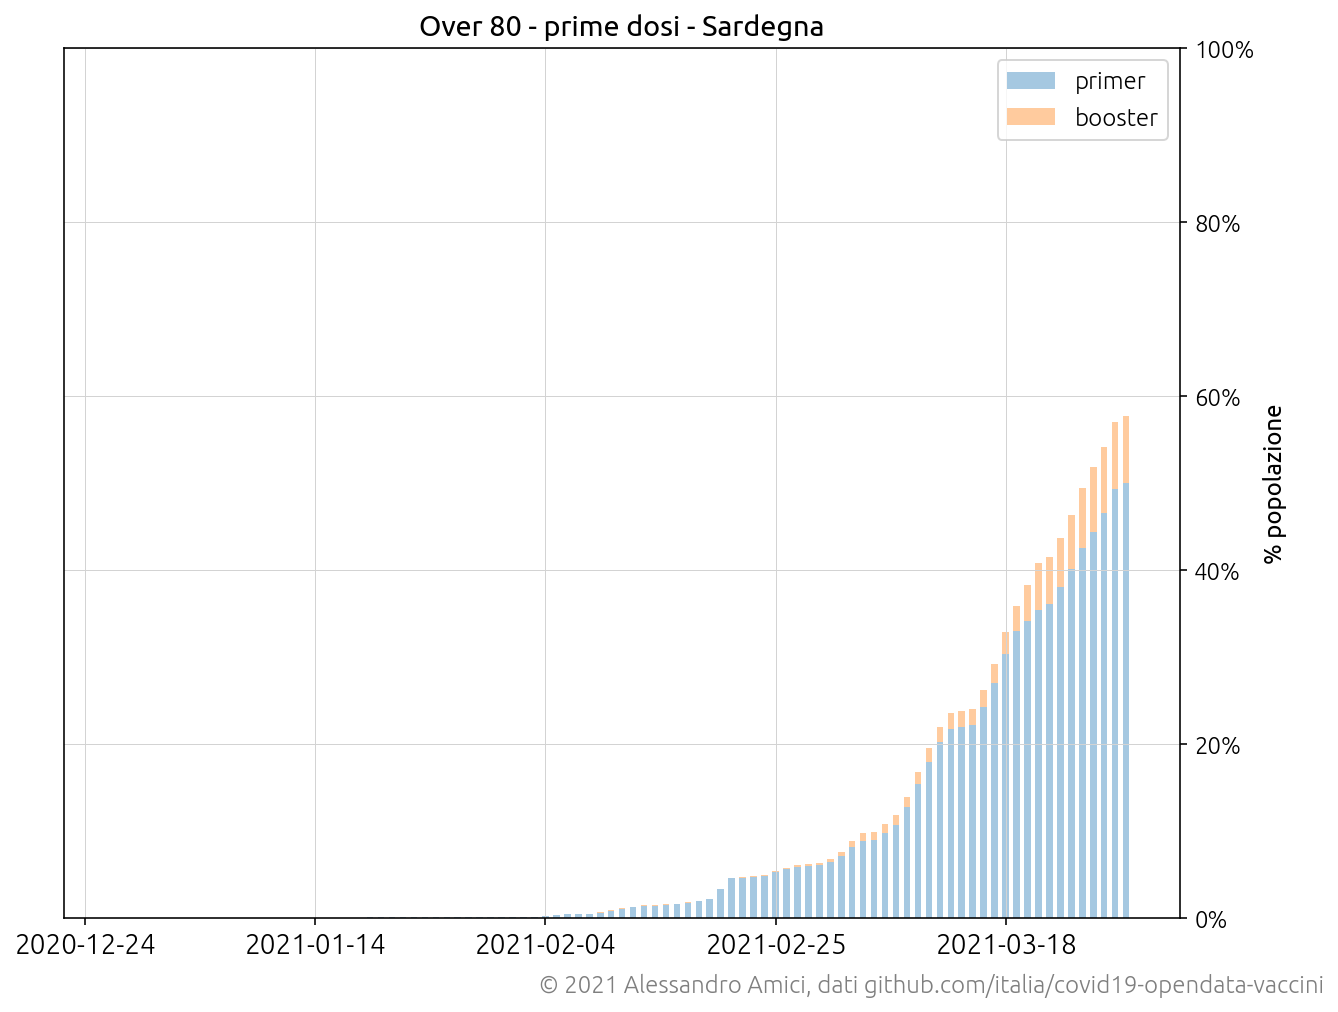

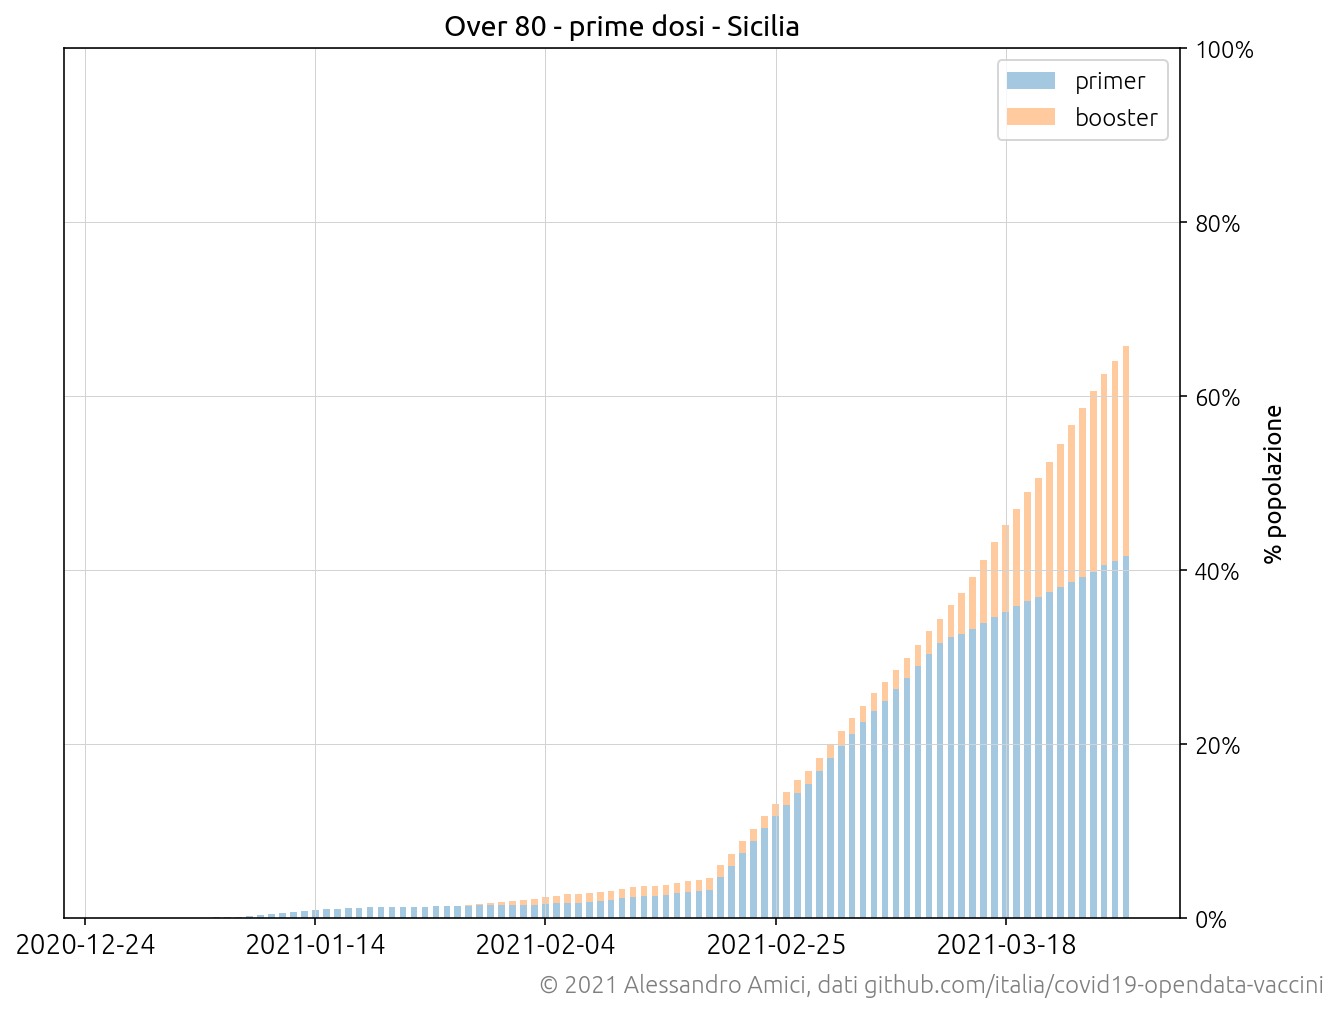

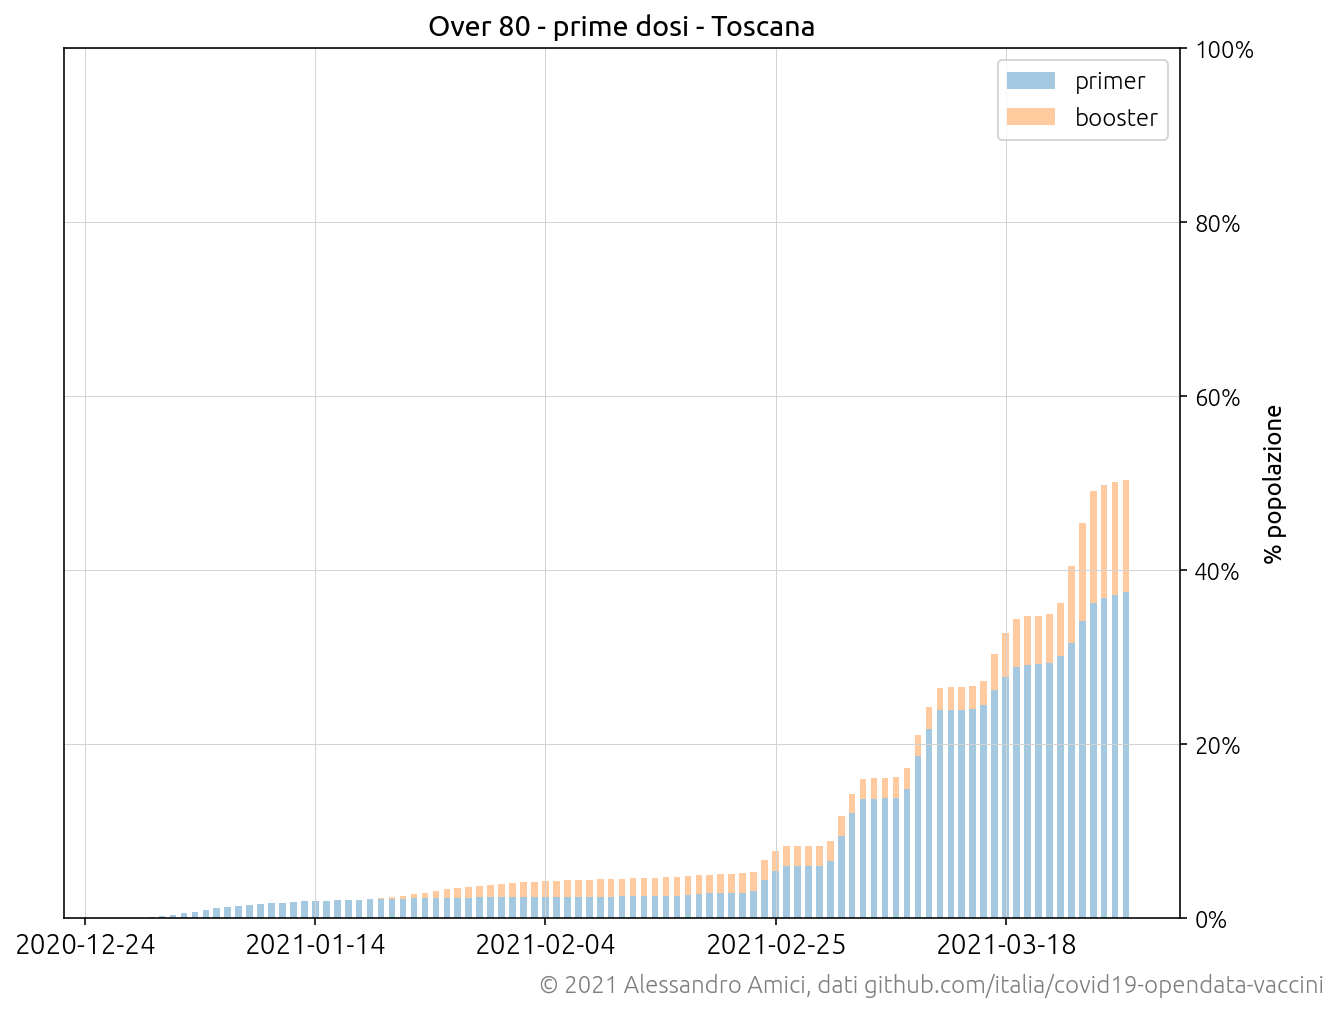

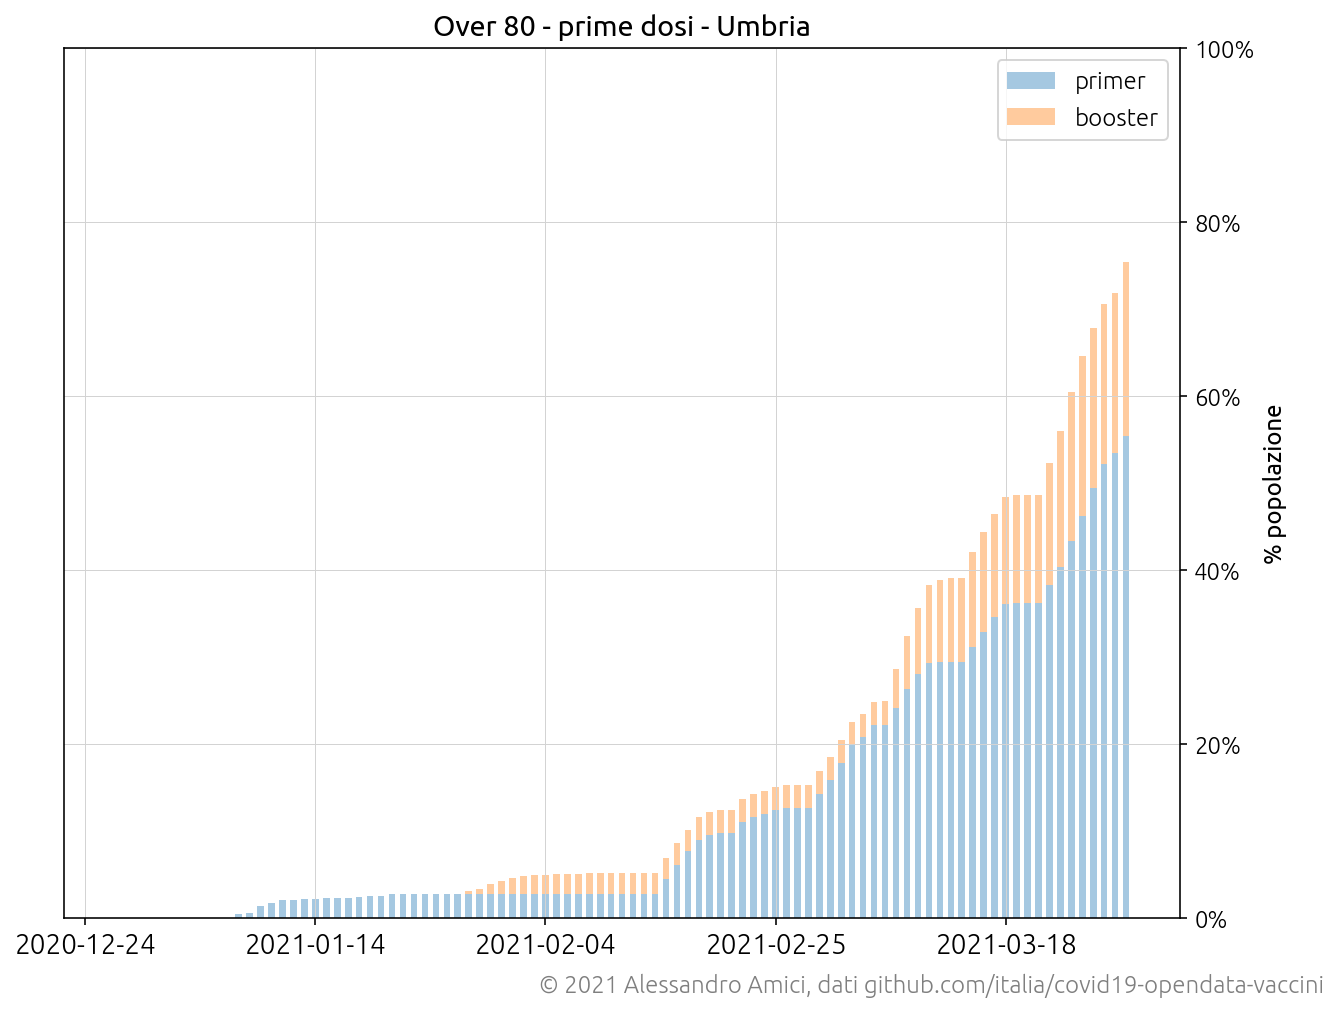

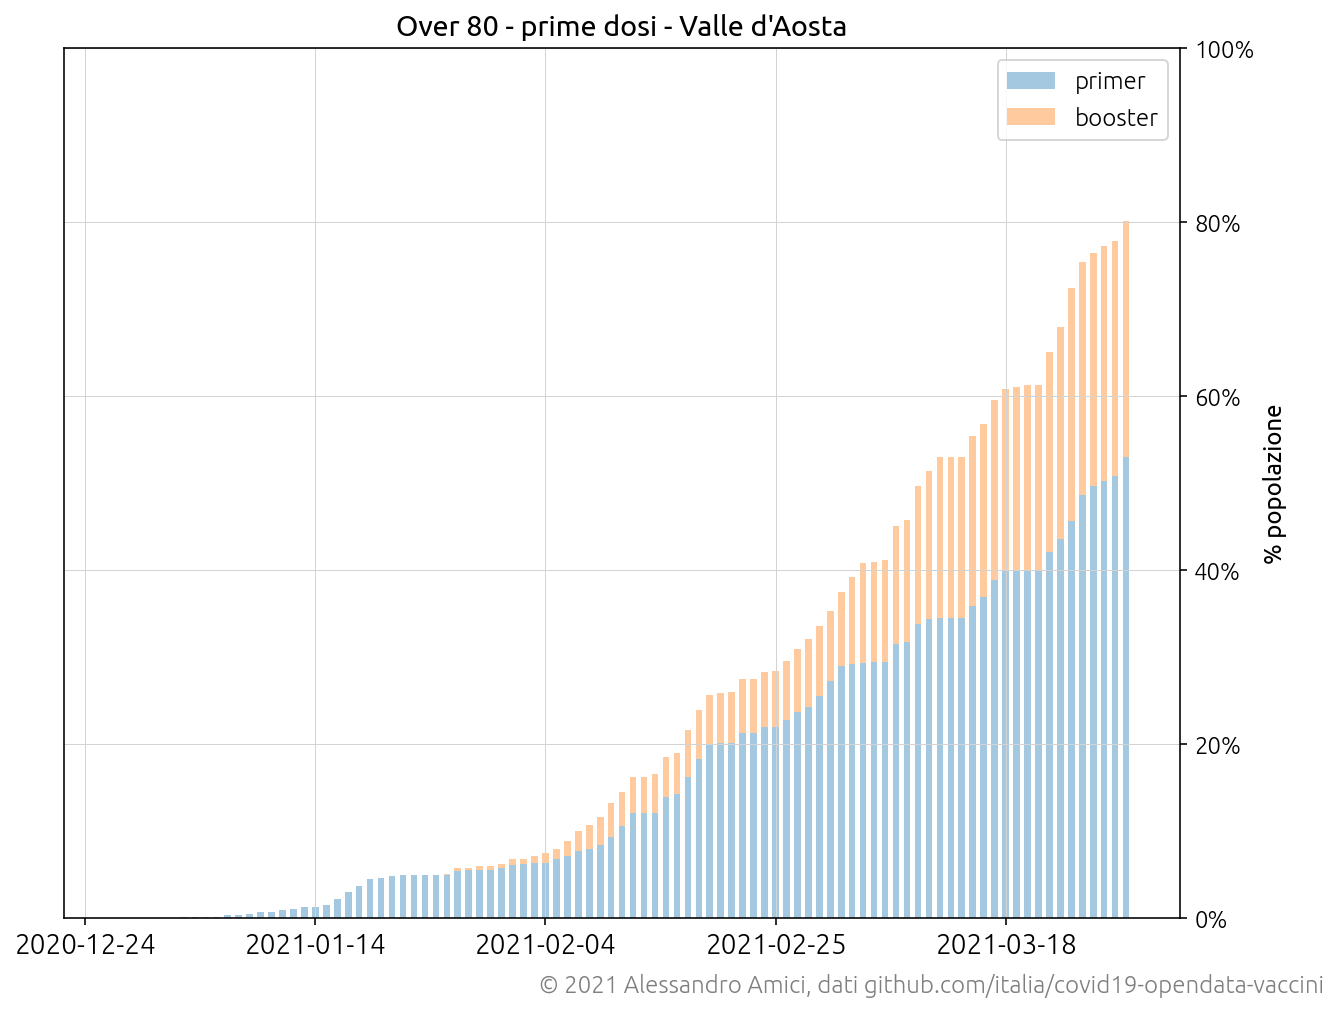

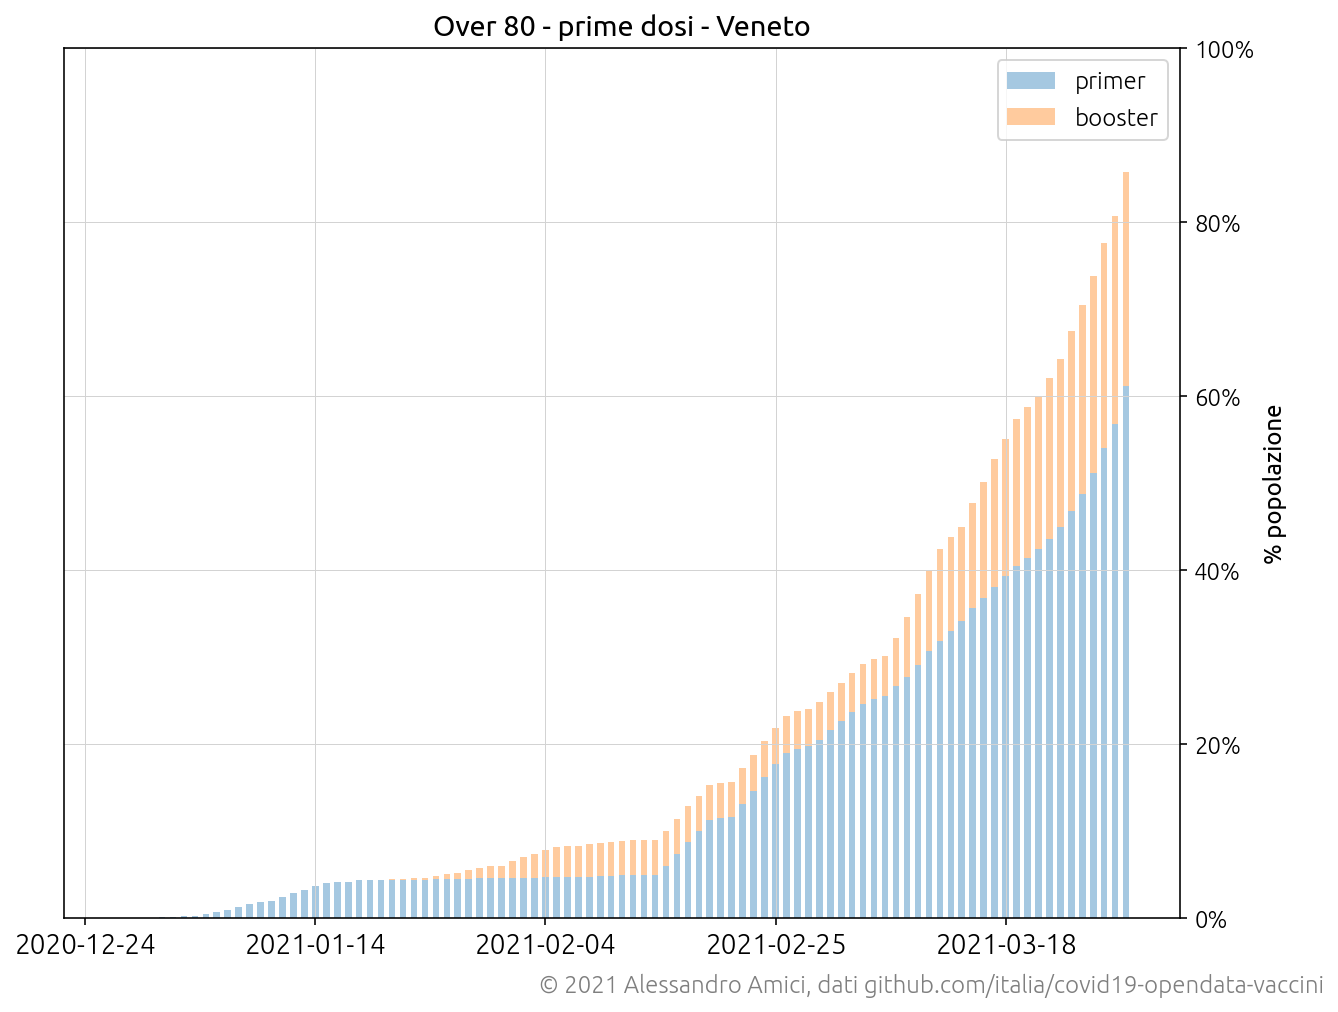

In [1046]:
primed_and_boosted = primers80_pm.cumsum("time").sum("provider")
boosted = vaccines_italy.doses.sel(dose_type="booster").sel(age_class=slice("80-89", None)).cumsum("time").sum(["age_class", "provider"]) / vaccines_italy.population_80
data1 = xr.merge([boosted.rename("vaccinati"), (primed_and_boosted - boosted).rename("solo prima dose")]).to_array("a")
data2 = vaccines_italy.doses.sel(age_class=slice("80-89", None)).cumsum("time").sum(["age_class", "provider"]) / vaccines_italy.population_80
for location in primers80.location.values:
    fig, ax = covid19.plot.subplots(note=COPYRIGHT)
    covid19.plot.stack_xarray(data2.sel(location=location), hue="dose_type", title=f"Over 80 - prime dosi - {location}", ylim=(0, 1), alpha=0.4, ax=ax)
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1, 0))
    ax.set(ylabel="% popolazione")
    ax.legend()